### **Consumo y Demanda de Energía en Sistemas de Potencia**

#### **Objeto**

Poner en práctica los conceptos y temas vistos en el curso propedéutico, a fin de plantear propuestas de aproximación para el análisis del comportamiento del consumo y la demanda de Energía Eléctrica (EE) en un sistema de potencia.

#### **Contenido:**
+ Definiciones
+ Planteamientos de aproximación propuestos:
+ Pronóstico de la demanda y consumo
+ Cálculo de energía consumida
+ Análisis estadístico del perfil de demanda y consumo
+ Modelado del fenómeno (demanda/consumo de EE)
+ Interpolación/Extrapolación
+ Integrador de funciones
+ Series de tiempo
+ Conclusiones y trabajos futuros

#### **Planteamientos**

**1 - Pronóstico de la demanda y consumo**
Dada una estadística de valores de demanda y consumo (de septiembre de 2017 a julio de 2020 –BD de trabajo) se pretende caracterizar un modelo polinomial para estimar los valores de demanda/consumo de los próximos meses.

**¿Por qué?**
El pronóstico del consumo y la demanda de energía eléctrica es una actividad esencial para la operación y planeación de los sistemas de potencia, a fin de garantizar su correcta operación en los diferentes horizontes de tiempo.

**2 - Cálculo del consumo de energía**
La información de consumo recabada en la BD de trabajo se calcula utilizando promedios para cada intervalo de 1 hora. Se desea calcular la energía de el mismo periodo utilizando funciones aproximadas que se ajusten a la forma de la curva de demanda y compararlas.

**¿Por qué?**
Es importante definir la granularidad de la información que se puede obtener de los sistemas de registros. Considerar periodos menores a 1 hora podría significar una gran cantidad de recursos para su almacenamiento y procesamiento. Por eso es importante definir hasta qué grado se pueden obtener estimaciones adecuadas con diferentes espaciamiento en las muestras. 

**3 - Análisis estadístico del perfil de demanda/consumo**
La forma que tiene una curva de demanda presenta ciertos patrones que sugieren comportamientos repetitivos en diferentes horizontes de tiempo (día, semana, año). Se plantea analizar el fenómeno de demanda de energía y consumo como una serie de tiempo para obtener más información de su comportamiento.

**¿Por qué?**
Debido a las variaciones que presenta el fenómeno de demanda y consumo de EE es de interés dar una representación estadística para identificar patrones que se puedan predecir y ayuden en la toma de decisiones en la operación y planeación del sistema de potencia.

#### **Visualización**



In [1]:
import numpy as np
import pandas as pd

In [2]:
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [3]:
from utils import MSE

In [4]:
def Tcf(f,a,b,n): #Tcf: Función creada para calcular la integral con el método del trapecio
    """
    Mediante la regla trapezoidal, calcula la integral de la función en unintérvalo dado, 
    considerando un número dado de intérvalos y un intérvalo deseado.
    Los nodos de los subintérvalos se crean mediante: 
        x_i = a+ih_hat for i=0,1,...,n and h_hat=(b-a)/n
    Argumentos de la función:
        f (función): función de la cual se quiere calcular su integral
        a (float): Extremo inferior del intérvalo
        b (float): Extremo superior del intérvalo
        n (float): número de subintérvalos
    Returns:
        sum_res (float): Cálculo númerico de la integral de f en el intérvalo a,b
    """
    h = b-a
    h_hat = h/n
    
    sum_res = 0
    for i in np.arange(n-1): # Número de subintérvalos
        x = a + (i+1/2)*h_hat # Se crea cada nodo de los subintérvalos
        sum_res+= f(x) # Sumatoria del valor de la función en cada nodo (integral)
    Tcf=f(a)+f(b)+2*sum_res
    return 1/2*h_hat*Tcf

In [5]:
# Dataset de trabajo
data_horas = pd.read_csv("Datos_csv.csv")
data_horas.head(5)

muestras  anio   fecha  hora_inicio  hora_fin     dema_int     dem_inst  \
0         1  2017  01-sep            0         1  6872.013385  6976.172363   
1         2  2017  01-sep            1         2  6660.573651  6709.388672   
2         3  2017  01-sep            2         3  6504.232961  6568.017090   
3         4  2017  01-sep            3         4  6435.836442  6502.294434   
4         5  2017  01-sep            4         5  6437.741557  6384.402344   

   aniomovil  
0          1  
1          1  
2          1  
3          1  
4          1

Cuyos datos estadísticos descriptivos son los siguientes

In [5]:
list_int = np.array(list(data_horas["dema_int"]))
list_inst = np.array(list(data_horas["dem_inst"]))

In [6]:
data_int = pd.DataFrame(list_int , columns = ['Demanda Integrada']) 
data_inst = pd.DataFrame(list_inst , columns = ['Demanda Instantánea']) 
data_int['Demanda Instantánea'] = data_inst['Demanda Instantánea']
data_int.head(5)

Demanda Integrada  Demanda Instantánea
0        6872.013385          6976.172363
1        6660.573651          6709.388672
2        6504.232961          6568.017090
3        6435.836442          6502.294434
4        6437.741557          6384.402344

In [7]:
data_int.describe()

Demanda Integrada  Demanda Instantánea
count       25152.000000         25152.000000
mean         7745.438583          7734.933778
std           974.363777           977.956108
min          4288.339301          4230.882324
25%          7011.455212          6998.106567
50%          7807.317117          7794.049072
75%          8484.490007          8478.522950
max         10567.494660         11267.710940

### **Visualización de Valores Representativos de Diferentes Periodos**

Algunos datos relevantes son los siguientes
- 25,152 registros horaios de la demanda y su respectivo consumo
- Periodo de las muestras recolectadas (01-sep-2017 a 14-jul-2020)
- Demandas máximas del periodo:
  > 10,567 MWh (integrada)
  > 11,267 MW  (instantánea)
- Demandas mínimas del periodo:
  > 4,288 MWh (integrada)
  > 4,230 MW  (instantánea)
- Demandas promedio del periodo:
  > 7, MWh (integrada)
  > 4,230 MW  (instantánea)

+ **Considerando valores por día (cada 24 muestras horarias)**

In [6]:
data_2 = pd.read_csv("Datos_csv.csv")

In [140]:
n_datos = len(data_2.muestras)
rango = 1*24 # (número de muestras horarias en el periodo de 1 día = 24 horas)
aux = round(len(data_2.muestras)/rango)-1
print(" Muestras > muestras en subperiodos? \n", n_datos > rango*aux) # Para saber el número de datos que se utilizarían
print(" Muestras faltantes: ", n_datos-rango*aux, "\n Subperiodos considerados: ", aux)

 Muestras > muestras en subperiodos? 
 True
 Muestras faltantes:  24 
 Subperiodos considerados:  1047


Recopilando la información por subperiodo, considerando:
+ Valor Máximo
+ Promedio
+ Valor Mínimo

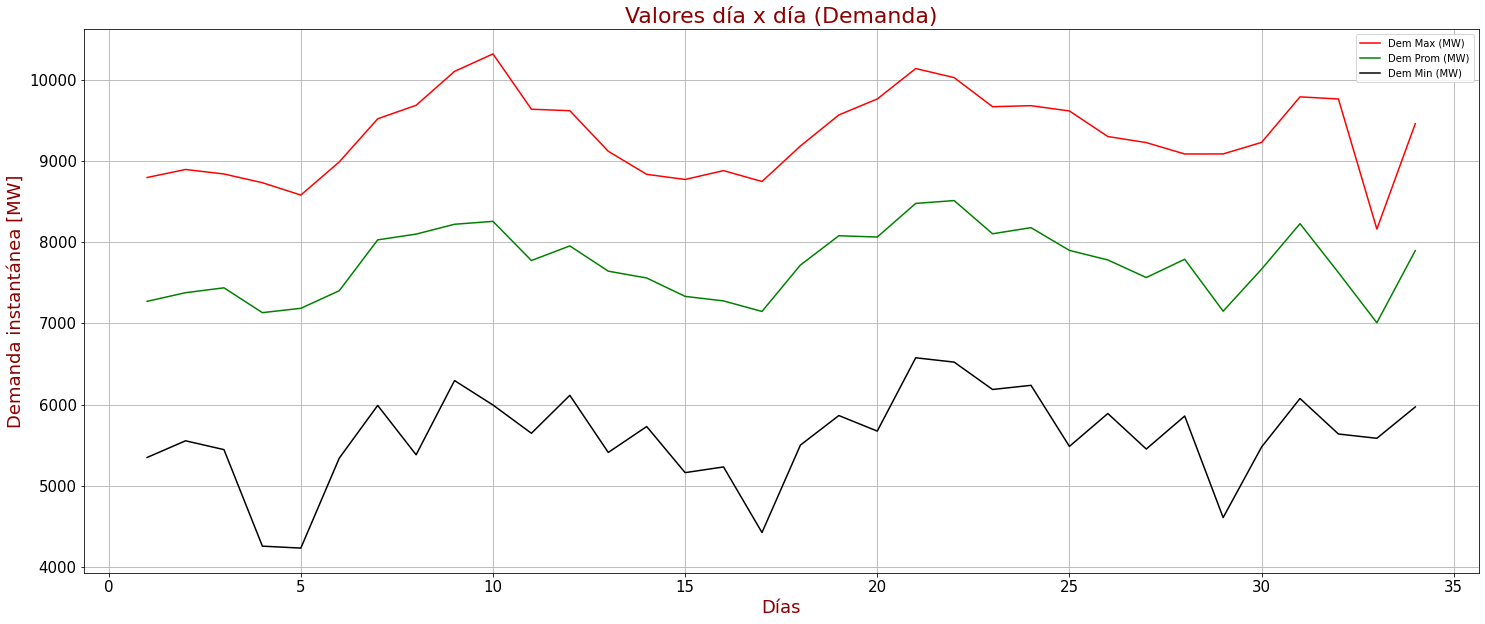

In [185]:
# Arreglos con las demandas integradas máxima, promedios y mínimas del rango seleccionado
max_itg = []
prom_itg = []
min_itg = []

dem_sub = []

# Arreglos con las demandas instantáneas máxima, promedios y mínimas del rango seleccionado
max_ins = []
prom_ins = []
min_ins = []
aux2 = 0

for i in range(aux):
    piv = []
    piv2 = []
    for k in range(rango):
        piv.append(data_2.dema_int[aux2])
        piv2.append(data_2.dem_inst[aux2])
        aux2 = aux2 + 1
    max_itg.append(max(piv))
    min_itg.append(min(piv))
    prom_itg.append(np.array(piv).mean())
    dem_sub.append(sum(piv)/1000) # En GWh
    max_ins.append(max(piv2))
    min_ins.append(min(piv2))
    prom_ins.append(np.array(piv2).mean())
    
x_d = np.linspace(1, len(max_ins), len(max_ins))

plt.figure(figsize=(25,10))
plt.plot(x_d, max_ins, 'r-', x_d, prom_ins, 'g-', x_d, min_ins, 'k-')
plt.legend(['Dem Max (MW)','Dem Prom (MW)','Dem Min (MW)'], loc='best')
plt.title("Valores día x día (Demanda)", fontsize = 22, color ='darkred')
plt.xlabel('Días', fontsize = 18 , color = 'darkred')
plt.ylabel('Demanda instantánea [MW]', fontsize = 18 , color = 'darkred')
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.savefig('Demanda_1.png')
plt.grid(True)

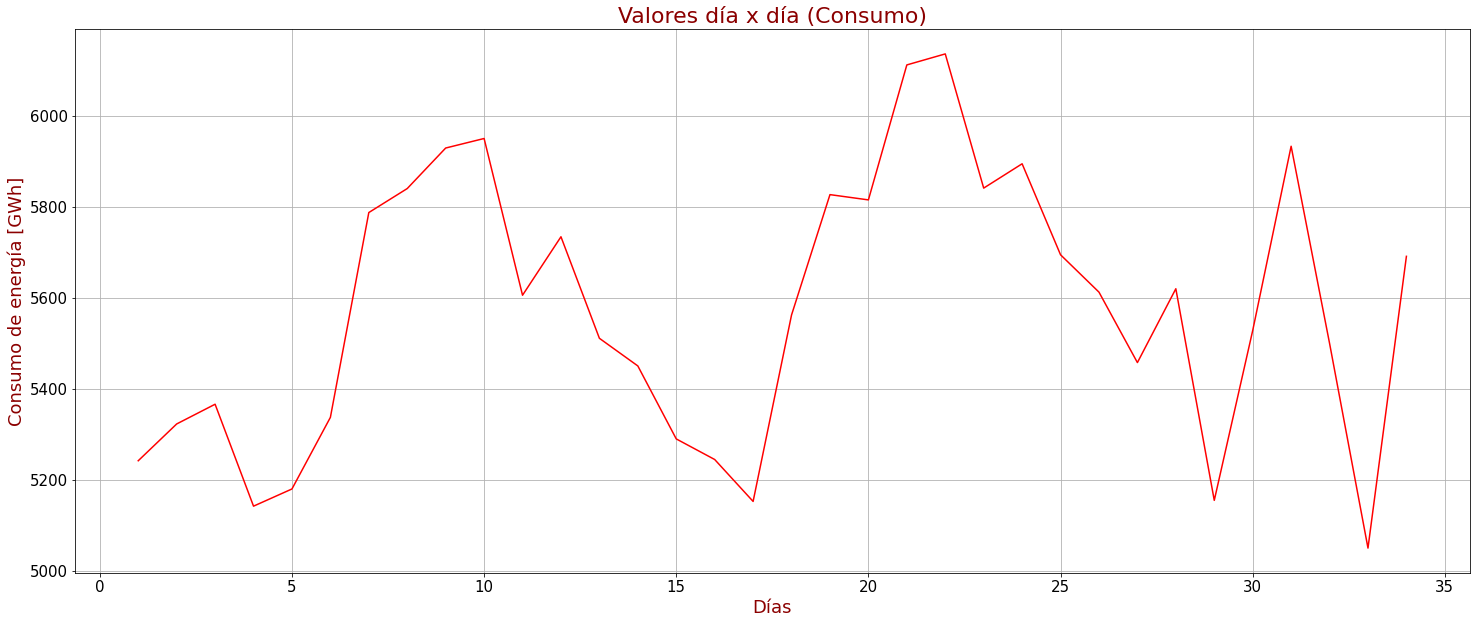

In [186]:
plt.figure(figsize=(25,10))
plt.plot(x_d, dem_sub, 'r-')
plt.title("Valores día x día (Consumo)", fontsize = 22 , color = 'darkred')
plt.xlabel('Días', fontsize = 18 , color = 'darkred')
plt.ylabel('Consumo de energía [GWh]', fontsize = 18 , color = 'darkred')
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Demanda_2.png')
plt.show()

+ **Considerando valores por semana (cada 7 días)**

In [143]:
n_datos = len(data_2.muestras)
rango = 7*24 # (número de muestras horarias en el periodo de 7 días = 1 semana)
aux = round(len(data_2.muestras)/rango)-1
print(" Muestras > muestras en subperiodos? \n", n_datos > rango*aux) # Para saber el número de datos que se utilizarían
print(" Muestras faltantes: ", n_datos-rango*aux, "\n Subperiodos considerados: ", aux)

 Muestras > muestras en subperiodos? 
 True
 Muestras faltantes:  120 
 Subperiodos considerados:  149


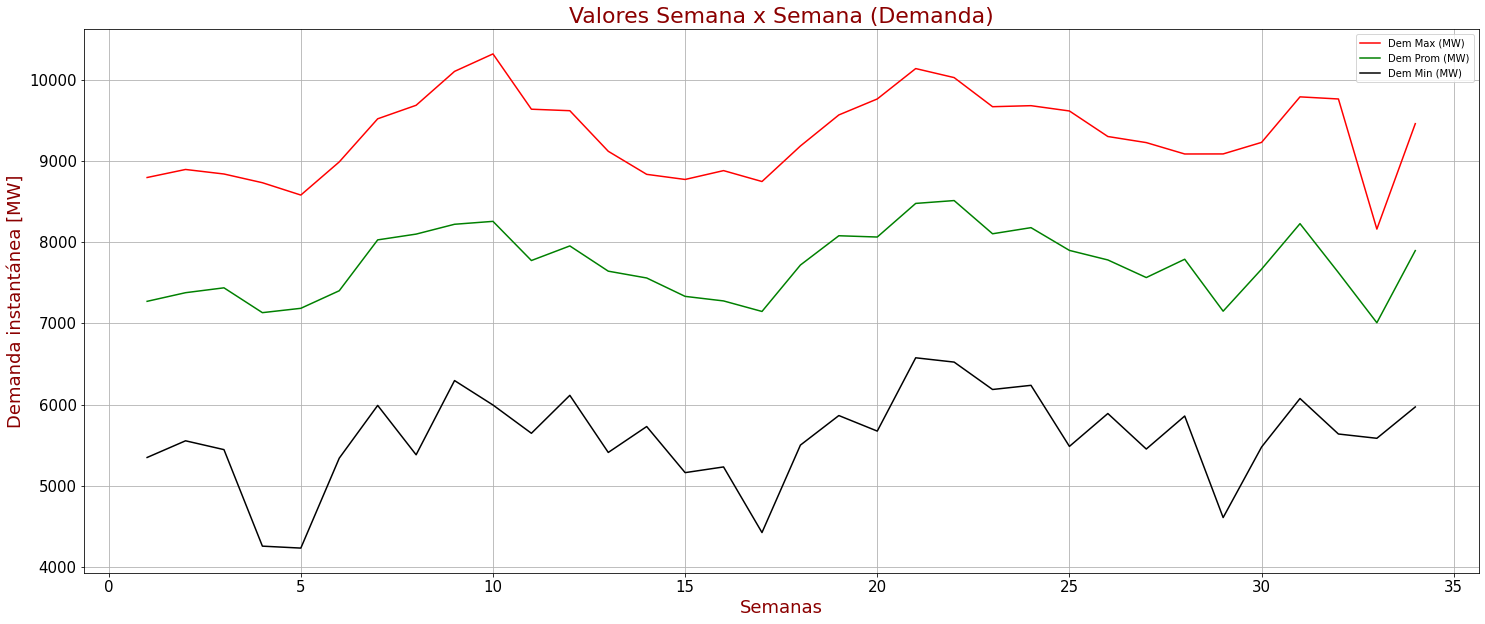

In [187]:
# Arreglos con las demandas integradas máxima, promedios y mínimas del rango seleccionado
max_itg = []
prom_itg = []
min_itg = []

dem_sub = []

# Arreglos con las demandas instantáneas máxima, promedios y mínimas del rango seleccionado
max_ins = []
prom_ins = []
min_ins = []
aux2 = 0

for i in range(aux):
    piv = []
    piv2 = []
    for k in range(rango):
        piv.append(data_2.dema_int[aux2])
        piv2.append(data_2.dem_inst[aux2])
        aux2 = aux2 + 1
    max_itg.append(max(piv))
    min_itg.append(min(piv))
    prom_itg.append(np.array(piv).mean())
    dem_sub.append(sum(piv)/1000)
    max_ins.append(max(piv2))
    min_ins.append(min(piv2))
    prom_ins.append(np.array(piv2).mean())
    
x_d = np.linspace(1, len(max_ins), len(max_ins))

plt.figure(figsize=(25,10))
plt.plot(x_d, max_ins, 'r-' , x_d, prom_ins, 'g-' , x_d, min_ins, 'k-')
plt.legend(['Dem Max (MW)','Dem Prom (MW)','Dem Min (MW)'], loc='best')
plt.title("Valores Semana x Semana (Demanda)", fontsize = 22 , color ='darkred')
plt.xlabel('Semanas', fontsize = 18 , color = 'darkred')
plt.ylabel('Demanda instantánea [MW]', fontsize = 18 , color = 'darkred')
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Demanda_3.png')
plt.show()

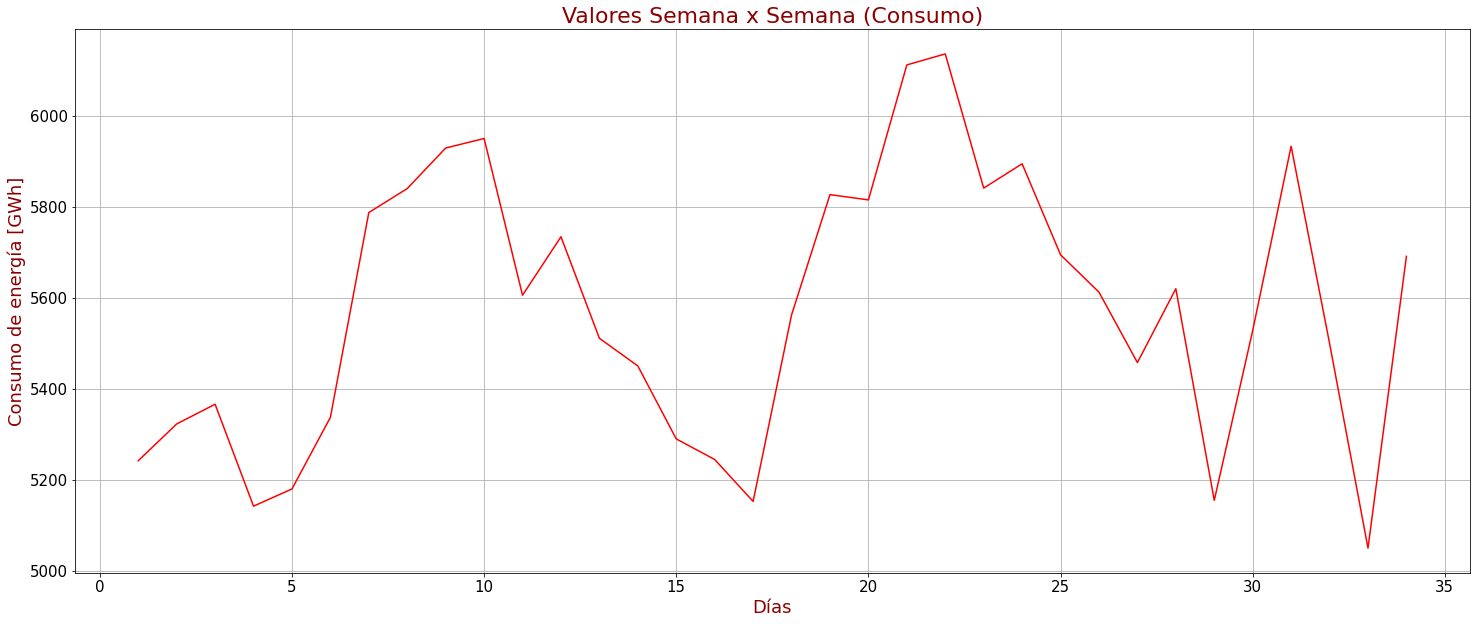

In [188]:
plt.figure(figsize=(25,10))
plt.plot(x_d, dem_sub, 'r-')
plt.title("Valores Semana x Semana (Consumo)", fontsize = 22 , color ='darkred')
plt.xlabel('Días', fontsize = 18 , color = "darkred")
plt.ylabel('Consumo de energía [GWh]', fontsize= 18, color = "darkred")
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Demanda_4.png')
plt.show()

**Considerando valores cada 30 días (~ cada mes)**

In [146]:
n_datos = len(data_2.muestras)
rango = 30*24 # (número de muestras horarias en el periodo de 7 días = 1 semana)
aux = round(len(data_2.muestras)/rango)-1
print(" Muestras > muestras en subperiodos? \n", n_datos > rango*aux) # Para saber el número de datos que se utilizarían
print(" Muestras faltantes: ", n_datos-rango*aux, "\n Subperiodos considerados: ", aux)

 Muestras > muestras en subperiodos? 
 True
 Muestras faltantes:  672 
 Subperiodos considerados:  34


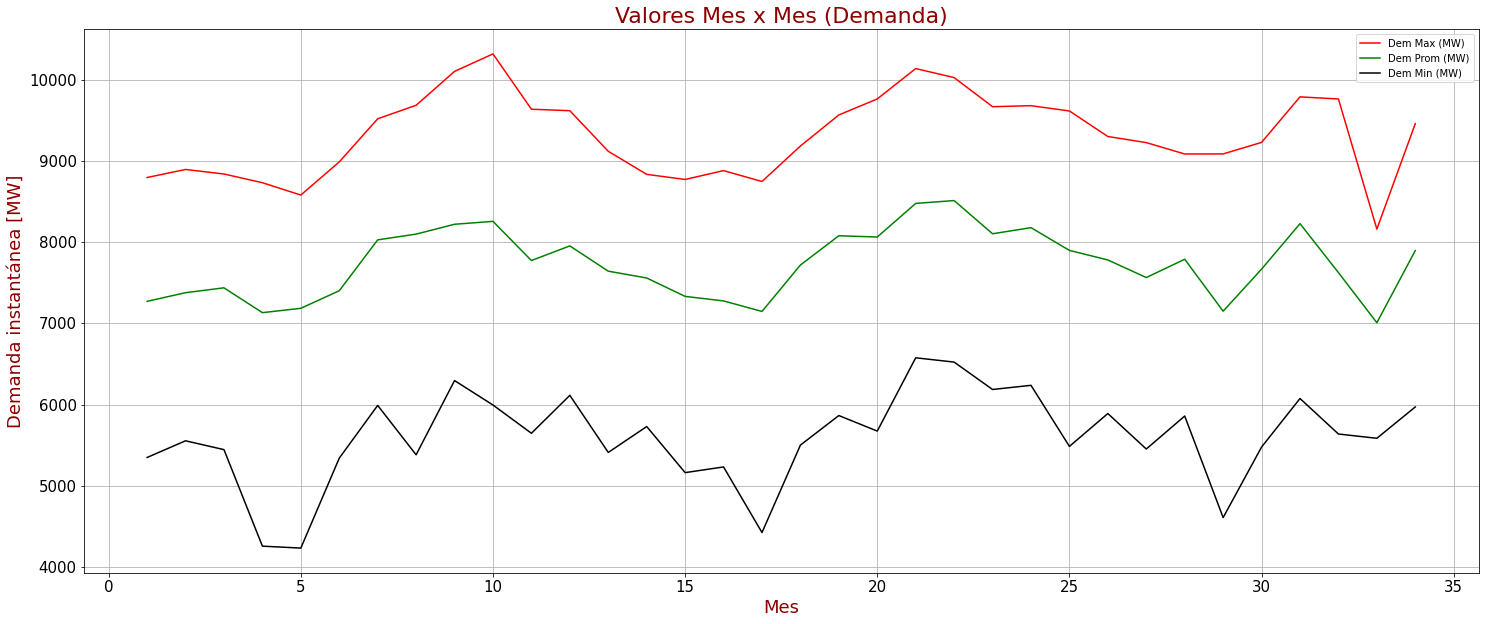

In [190]:
# Arreglos con las demandas integradas máxima, promedios y mínimas del rango seleccionado
max_itg = []
prom_itg = []
min_itg = []

dem_sub = []

# Arreglos con las demandas instantáneas máxima, promedios y mínimas del rango seleccionado
max_ins = []
prom_ins = []
min_ins = []
aux2 = 0

for i in range(aux):
    piv = []
    piv2 = []
    for k in range(rango):
        piv.append(data_2.dema_int[aux2])
        piv2.append(data_2.dem_inst[aux2])
        aux2 = aux2 + 1
    max_itg.append(max(piv))
    min_itg.append(min(piv))
    prom_itg.append(np.array(piv).mean())
    dem_sub.append(sum(piv)/1000)
    max_ins.append(max(piv2))
    min_ins.append(min(piv2))
    prom_ins.append(np.array(piv2).mean())
    
x_d = np.linspace(1, len(max_ins), len(max_ins))

plt.figure(figsize=(25,10))
plt.plot(x_d, max_ins, 'r-' , x_d, prom_ins, 'g-' , x_d, min_ins, 'k-')
plt.legend(['Dem Max (MW)','Dem Prom (MW)','Dem Min (MW)'], loc='best')
plt.title("Valores Mes x Mes (Demanda)", fontsize = 22 , color ='darkred')
plt.xlabel('Mes', fontsize = 18 , color = "darkred")
plt.ylabel('Demanda instantánea [MW]', fontsize = 18 , color = "darkred")
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Demanda_5.png')
plt.show()

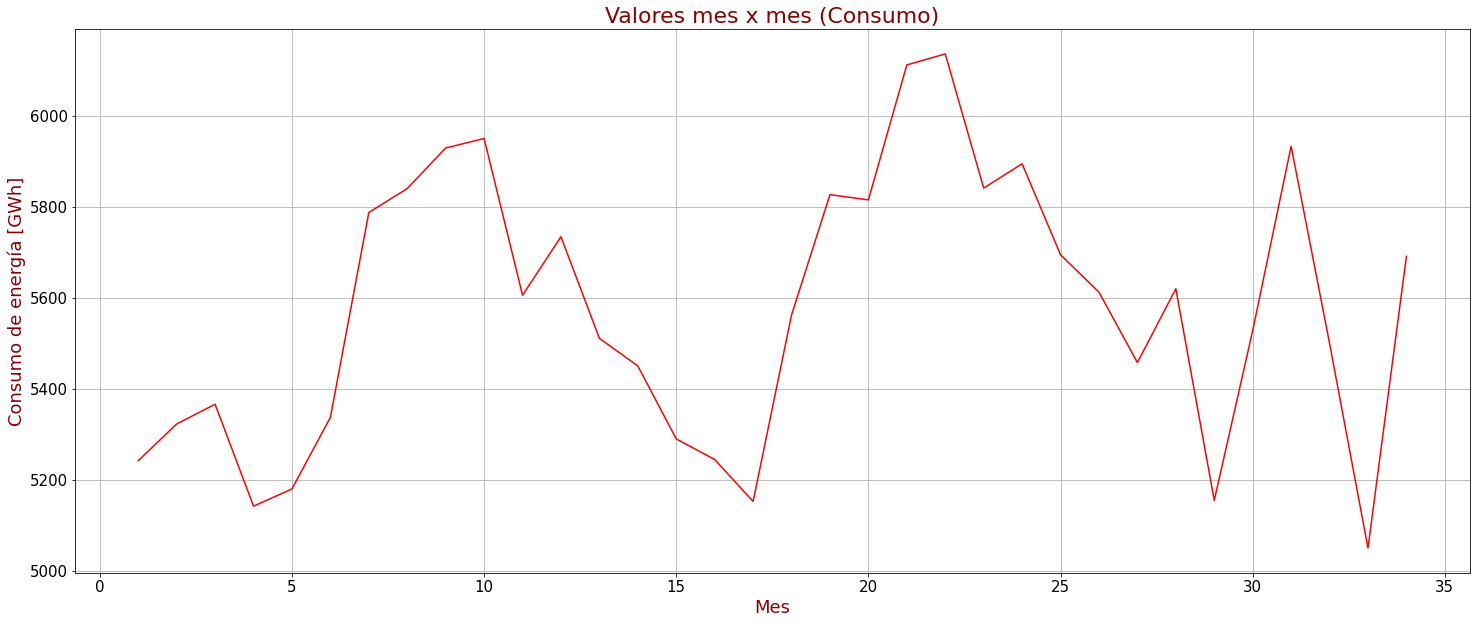

In [191]:
plt.figure(figsize=(25,10))
plt.plot(x_d, dem_sub, 'r-')
plt.title("Valores mes x mes (Consumo)", fontsize = 22 , color = 'darkred')
plt.xlabel('Mes', fontsize = 18 , color = "darkred")
plt.ylabel('Consumo de energía [GWh]' , fontsize = 18 , color = "darkred")
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Demanda_6.png')
plt.show()

A continuación se obtendrán los interpoladores para distintas medidas de tiempo con el objetivo de ver si se simplifican suficiente los datos para hallar un modelo simple que describa el conjunto de datos. En este caso, se usarán interpoladores y splines cúbicos.

### **Demanda Instantánea Promedio**

Nos interesa, de momento, encontrar un modelo fiable que se ajuste a los datos de la demanda instantánea, que es el promedio de la energía consumida en una hora

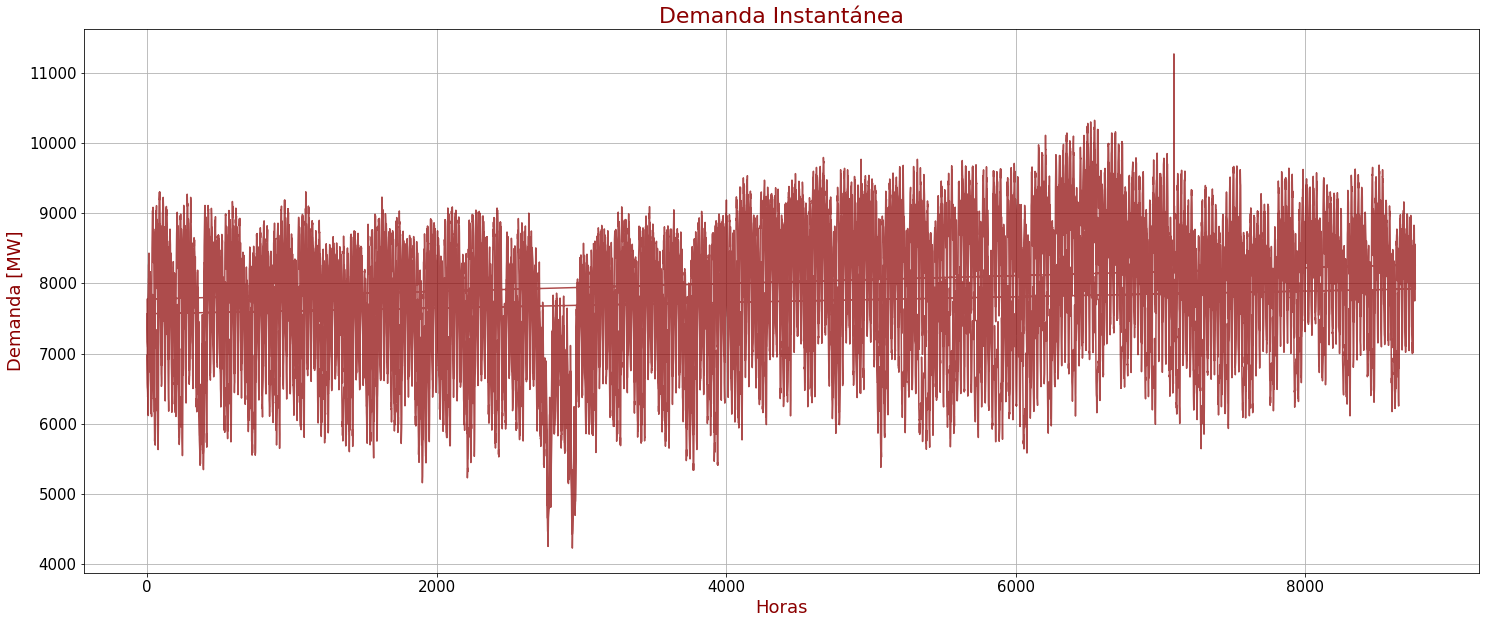

In [8]:
plt.figure(figsize=(25,10))
plt.plot(data_horas.muestras, data_horas.dem_inst, 'b-', color = 'darkred' , alpha = 0.7)
plt.title("Demanda Instantánea" , fontsize = 22 , color = 'darkred')
plt.xlabel("Horas" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Demanda_Instantanea.png')
plt.show()

Como vemos, los datos presentan muchas oscilaciones, debido a ello, tomaremos los promedios por día, semanas y meses con el objetivo de observar si los datos se simplifican lo suficiente como para hallar un modelo simple que se ajuste a ellos.

### **Interpoladores**

#### **Demanda Promedio Díaria** 

De acuerdo a los datos del análisis descriptivo se cuentan con 25152 registros de horas, por ello, sacaremos los promedios de cada 24 registros consecutivos para obtener el promedio de la demanda diaría.

In [12]:
horas_tot = 25152 # Horas totales registradas
num_d = int(horas_tot/24)
prom_dia = []
for i in range(0,num_d):
    ini = 24*i
    end = 24*(1+i)
    data_i = data_horas[ini:end]
    prom_dia.append(data_i["dem_inst"].mean())

In [13]:
prom_a_dia = np.array(prom_dia)
x_dia = np.array(list(range(1,len(prom_dia)+1)))

In [14]:
mpoints = len(prom_dia)
x_dia_grph_1 = np.linspace(min(x_dia) , max(x_dia) , mpoints)
y_dia_grph_1 = np.array(prom_dia)

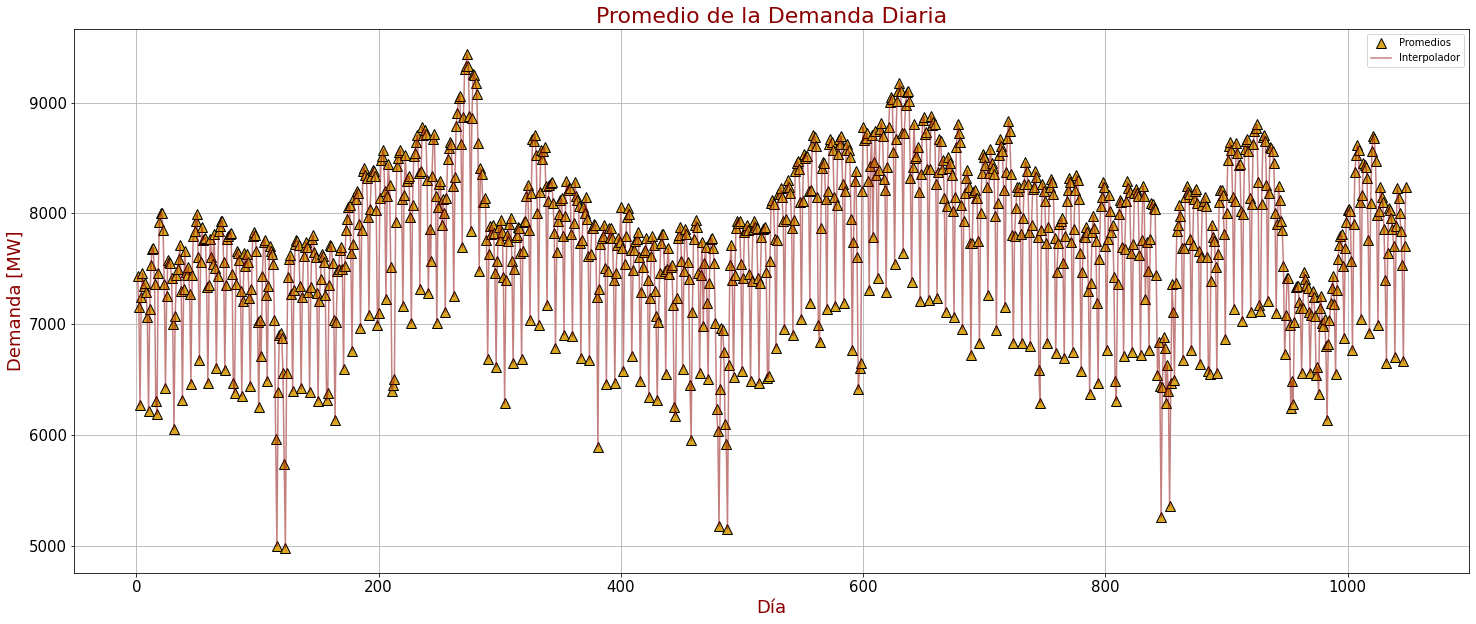

In [15]:
plt.figure(figsize=(25,10))
plt.plot(x_dia , prom_a_dia , color= 'white' ,
         marker = '^' , markersize = 10.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(x_dia_grph_1 , y_dia_grph_1 , color = 'darkred' , alpha = 0.5)
plt.title("Promedio de la Demanda Diaria" , fontsize = 22 , color = 'darkred')
plt.xlabel("Día" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Promedios","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Promedio_Demanda_Dia.png')
plt.show()

#### **Interpolador Para la Demanda Instantánea Diaria**

La función *polyfit()* sólo acepta hasta un número máximo para el grado del polinomio para interpolar, debido a ello, tomaremos una muestra cada cinco días de los promedios diarios del $80\%$ de los datos para hacer el interpolador con un polinomio de grado 140, siendo este número el máximo número que acepta para el grado del interpolador.

In [16]:
n_m = []
x = []
k = 0
n_puntos = 100 # Solo submúltiplos de 800, que representan el 76% de los datos
for i in range(n_puntos):
    n_m.append(k)
    x.append(k)
    k = int(k+(800/n_puntos))

y = []
for i in range(len(x)):
    y.append(prom_dia[n_m[i]])

coef_aj = np.polyfit(x, y, len(x))

neval = 100
xeval = np.linspace(min(x), max(x), neval)
yeval = np.polyval(coef_aj,xeval)

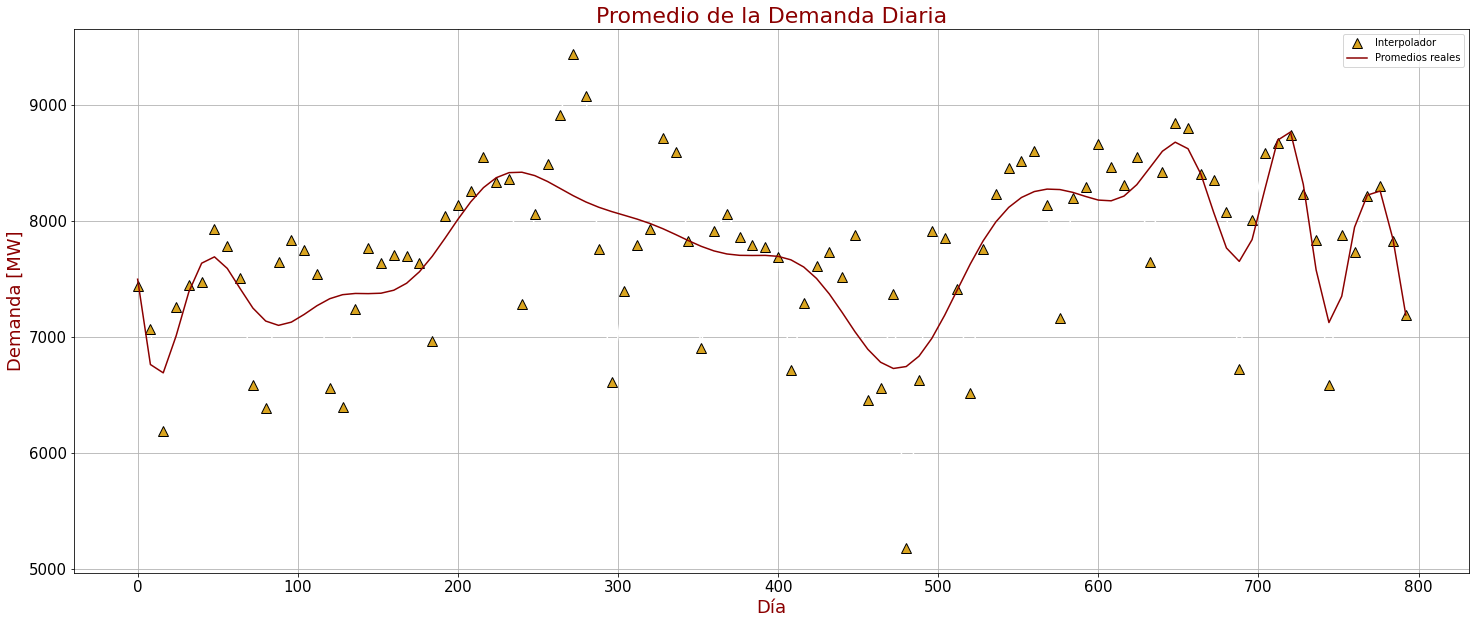

In [17]:
plt.figure(figsize=(25,10))
plt.plot(x , y , 'k-', color = 'white',
         marker = '^' , markersize = 10.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(xeval, yeval, 'b-', color = 'darkred')     
plt.title("Promedio de la Demanda Diaria" , fontsize = 22 , color = 'darkred')
plt.xlabel("Día" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Interpolador","Promedios reales","Muestras"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Promedio_Demanda_Dia_Inter.png')
plt.show()

Lo que resta ahora es poner a prueba este modelo con el resto de los datos con el objetivo de observar si este los describe

In [66]:
mpoints = len(prom_dia) + 1
x_dia_grph_2 = np.linspace(min(x_dia) , max(x_dia) , mpoints)
y_dia_grph_2 = np.polyval(coef_aj , x_dia_grph_2)

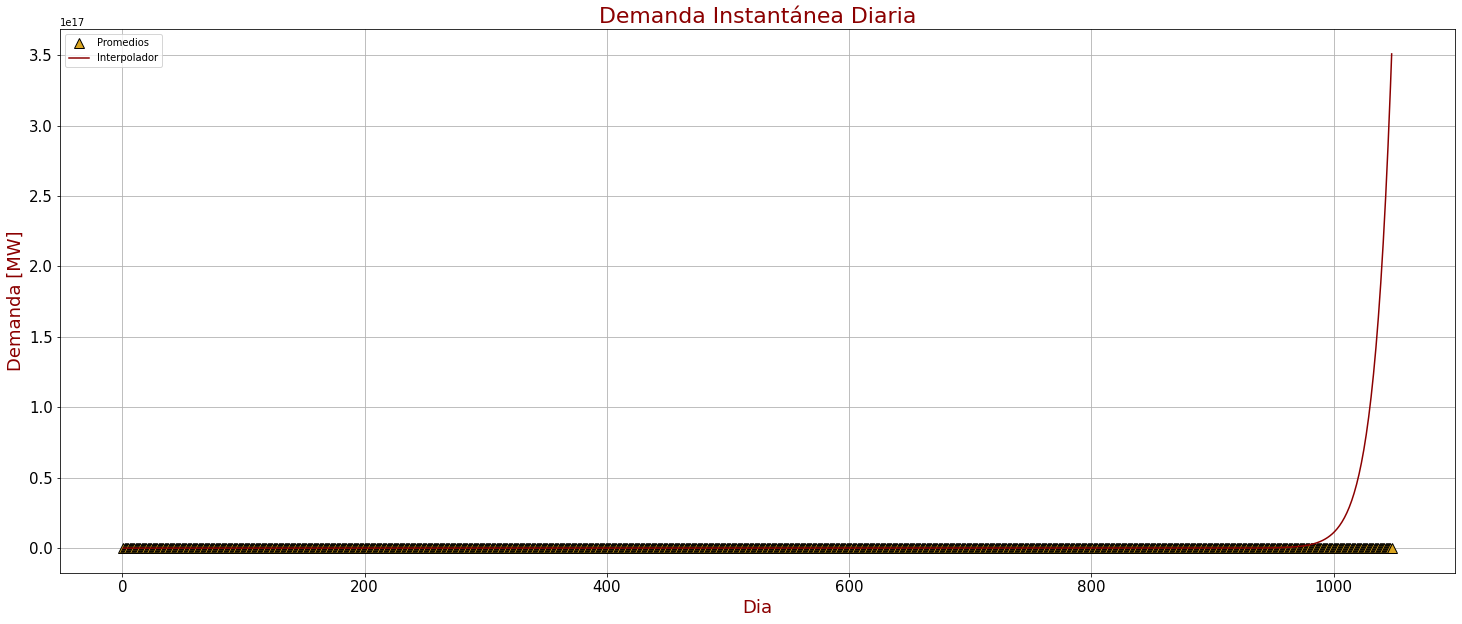

In [67]:
plt.figure(figsize=(25,10))
plt.plot(x_dia , prom_dia , color= 'white' ,
         marker = '^' , markersize = 10.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(x_dia_grph_2 , y_dia_grph_2 , color = 'darkred')
plt.title("Demanda Instantánea Diaria" , fontsize = 22 , color = 'darkred')
plt.xlabel("Dia" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Promedios","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Promedio_Demanda_Dia_Inter_2.png')
plt.show()

Hagamos un acercamiento a la región donde el interpolador diverge de los promedios diarios

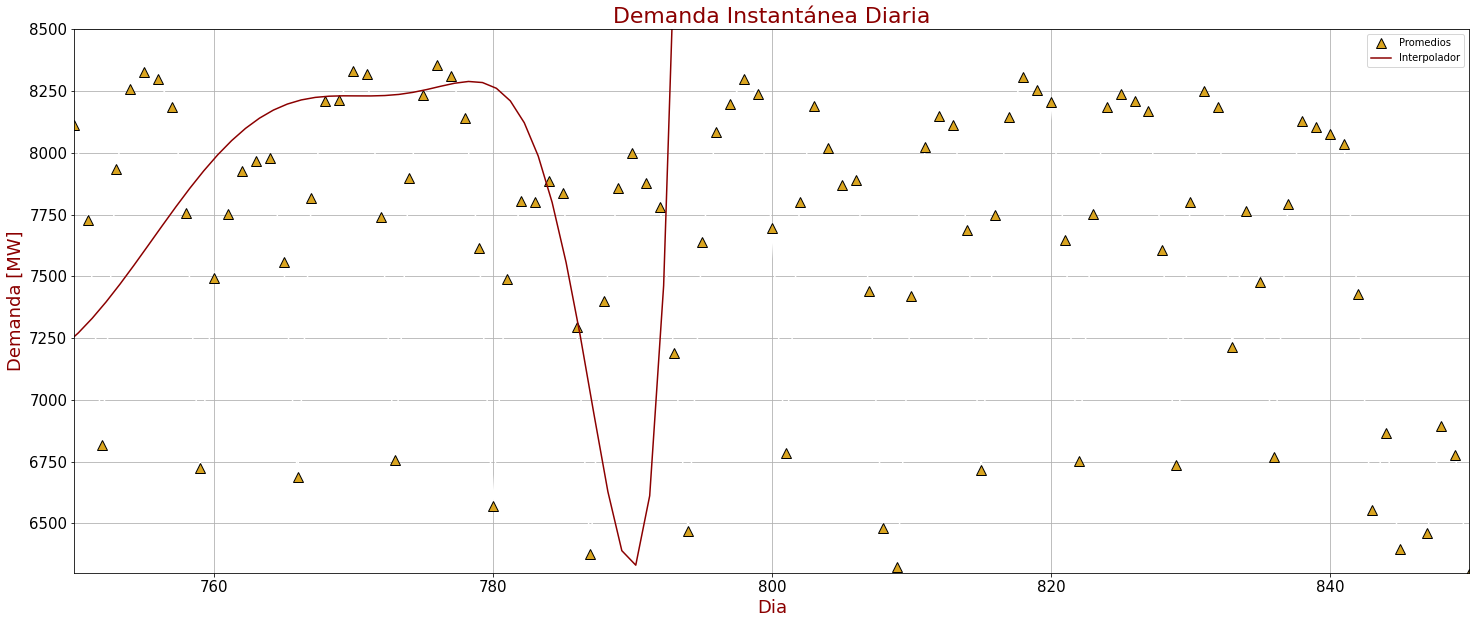

In [68]:
plt.figure(figsize=(25,10))
plt.plot(x_dia , prom_dia , color= 'white' ,
         marker = '^' , markersize = 10.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(x_dia_grph_2 , y_dia_grph_2 , color = 'darkred')
plt.title("Demanda Instantánea Diaria" , fontsize = 22 , color = 'darkred')
plt.xlabel("Dia" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Promedios","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlim(750,850)
plt.ylim(6300,8500)
plt.grid(True)
plt.savefig('Promedio_Demanda_Dia_Inter_3.png')
plt.show()

Tal como se ve la primera gráfica con el conjunto de prueba, nuestro modelo diverge y no puede describir ese conjunto de puntos por lo que se determina que en este caso el interpolador no es un modelo adecuado para este problema.

#### **Interpolador Para la Demanda Instantánea Semanal**

Ahora por semana, indistitanmente de a qué mes pertenezca, los días restantes se promediarán y se contarán como otra semana como se verá más adelante.

De acuerdo a las pruebas hechas nos damos cuenta que el límite del grado del polinomio que acepta, en este caso, polyfit, es 141. Sin embargo, para poner a prueba nuestro modelo, sólo necesitaremos el $80\%$ de los datos y el otro $20\%$ para hacer el test gráfico del modelo

In [24]:
data_dia = pd.DataFrame(prom_dia, columns = ['Promedio'])
dia = pd.DataFrame(x_dia, columns = ['Dia']) 
data_dia['Dia'] = dia['Dia']

num_s = int(len(data_dia)/7)
prom_sem = []
for i in range(0,num_s):
    ini = 7*i
    end = 7*(1+i)
    data_i = data_dia[ini:end]
    prom_sem.append(data_i["Promedio"].mean())

Agreguemos ahora el promedio de los otros seis días restantes

In [25]:
prom_sem.append(data_dia[num_s*7: num_s*7 + 6]["Promedio"].mean())
prom_a_sem = np.array(prom_sem)
x_sem = np.array(list(range(1,len(prom_sem)+1)))

Mostremos los últimos cinco datos de los promedios semanales

In [26]:
data_sem = pd.DataFrame(prom_sem, columns = ['Promedio']) 
sem = pd.DataFrame(x_sem, columns = ['Semana']) 
data_sem['Semana'] = sem['Semana']
data_sem.tail(5)

Promedio  Semana
145  8146.903320     146
146  7993.790376     147
147  7654.957781     148
148  7790.388611     149
149  7596.880754     150

Si contamos los seis días restantes como otras semana se tiene 150 semanas en total donde el $80\%$ de ellas son 120 y el número más pequeño y cercano que sea múltiplo de siete es 119. Entonces, obtengamos los arrays y dataframe con estos datos

In [27]:
num_s_i = 120
prom_sem_i = []
for i in range(0,num_s_i):
    ini = 7*i
    end = 7*(1+i)
    data_i = data_dia[ini:end]
    prom_sem_i.append(data_i["Promedio"].mean())

In [28]:
prom_a_sem_i = np.array(prom_sem_i)
x_sem_i = np.array(list(range(1,len(prom_sem_i)+1)))

data_sem_i = pd.DataFrame(prom_sem_i, columns = ['Promedio']) 
sem_i = pd.DataFrame(x_sem_i, columns = ['Semana']) 
data_sem_i['Semana'] = sem_i['Semana']
data_sem_i.tail(5)

Promedio  Semana
115  7373.456212     116
116  7831.342195     117
117  7842.172855     118
118  7700.119655     119
119  7714.911955     120

Obtengamos ahora el interpolador para el conjunto de 130 registros o conjunto de entrenamiento

In [29]:
d_sem = len(prom_sem_i) - 1
inter_sem = np.polyfit(x_sem_i , prom_a_sem_i , d_sem)

De esta manera, podemos graficarlo sobre los registros del *dataset*

In [30]:
mpoints = len(prom_sem_i) + 1
x_sem_grph_1 = np.linspace(min(x_sem_i) , max(x_sem_i) , mpoints)
y_sem_grph_1 = np.polyval(inter_sem , x_sem_grph_1)

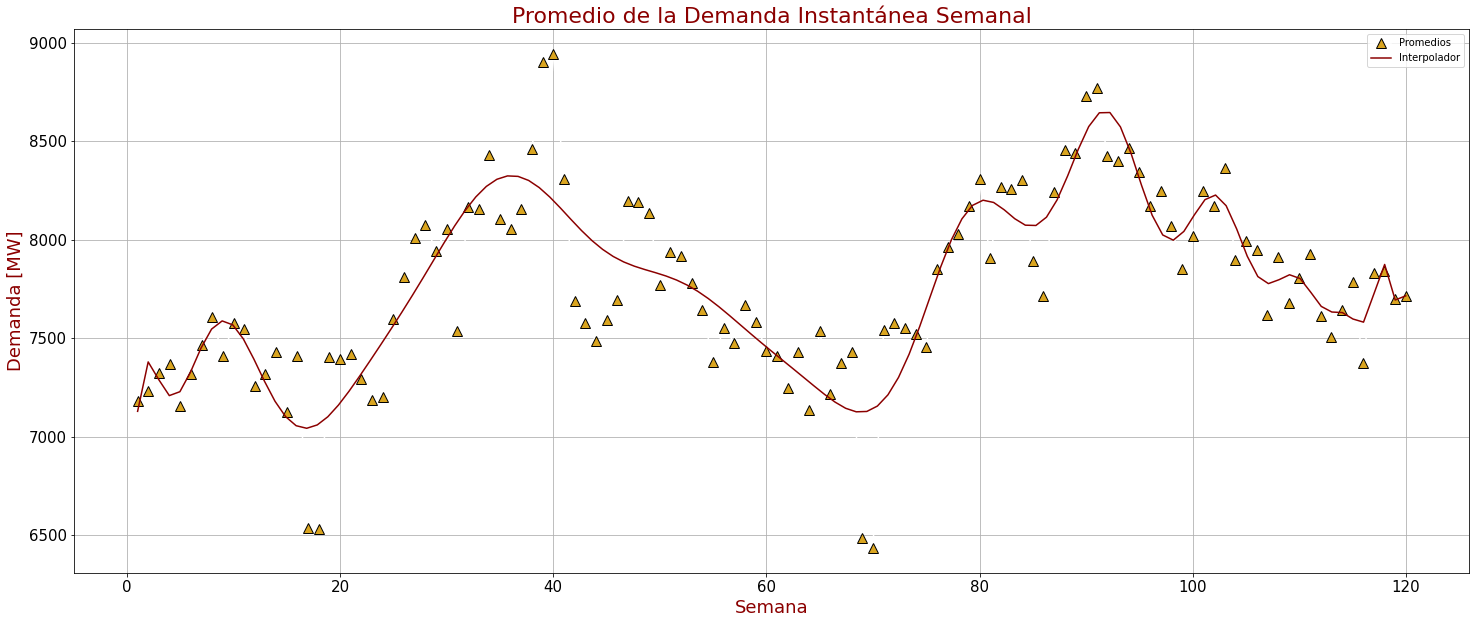

In [31]:
plt.figure(figsize=(25,10))
plt.plot(x_sem_i , prom_sem_i , color= 'white' ,
         marker = '^' , markersize = 10.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(x_sem_grph_1 , y_sem_grph_1 , color = 'darkred')
plt.title("Promedio de la Demanda Instantánea Semanal" , fontsize = 22 , color = 'darkred')
plt.xlabel("Semana" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Promedios","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Promedio_Demanda_Semana_Inter_1.png')
plt.show()

Finalmente graficaremos el interpolador junto con el conjunto de test para ver que tan fiable es el modelo obtenido

In [32]:
mpoints = len(prom_sem) + 1
x_sem_grph_2 = np.linspace(min(x_sem) , max(x_sem) , mpoints)
y_sem_grph_2 = np.polyval(inter_sem , x_sem_grph_2)

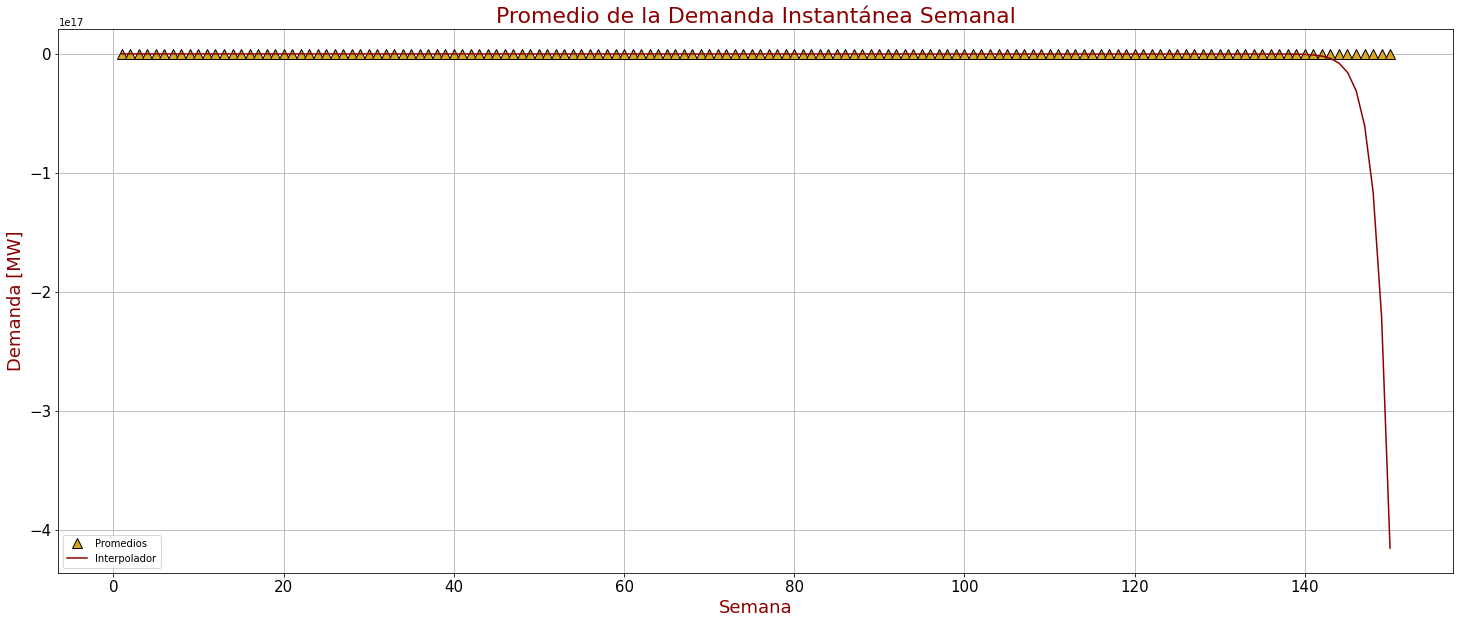

In [33]:
plt.figure(figsize=(25,10))
plt.plot(x_sem , prom_sem , color= 'white' ,
         marker = '^' , markersize = 10.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(x_sem_grph_2 , y_sem_grph_2 , color = 'darkred')
plt.title("Promedio de la Demanda Instantánea Semanal" , fontsize = 22 , color = 'darkred')
plt.xlabel("Semana" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Promedios","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Promedio_Demanda_Semana_Inter_2.png')
plt.show()

Hagamos un acercamiento en donde diverge el interpolador con los demás puntos

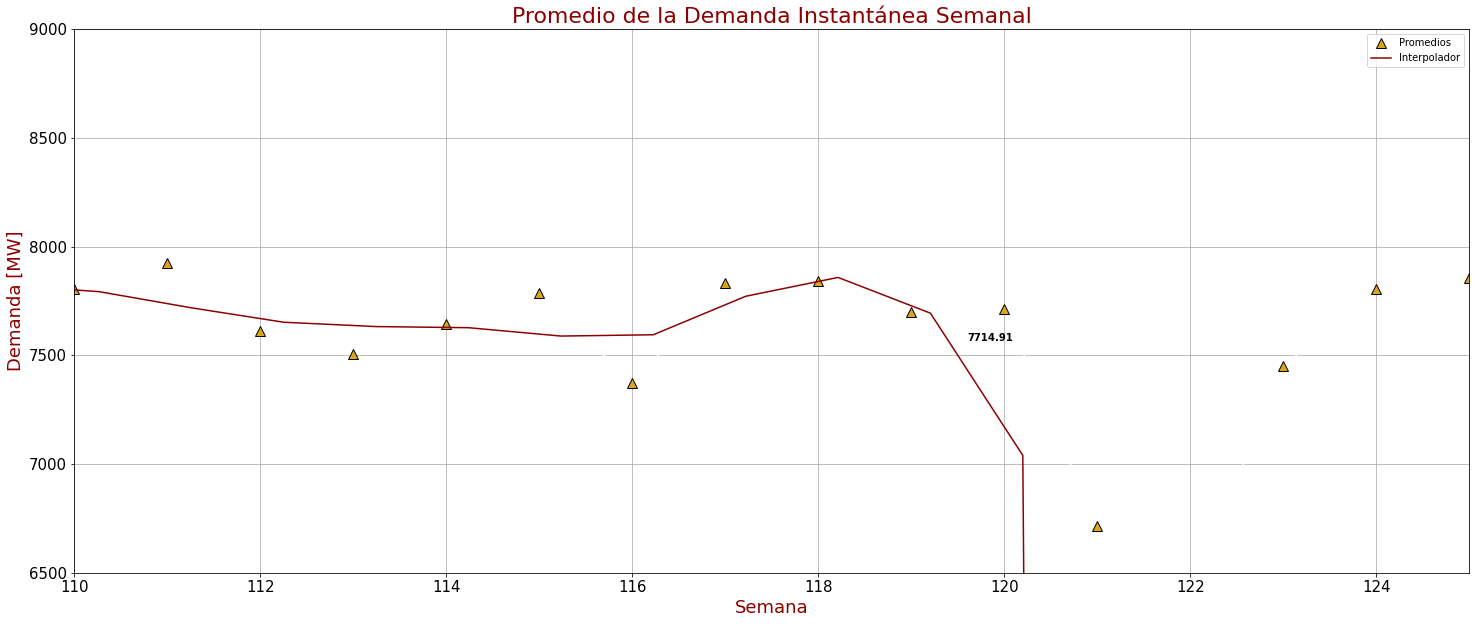

In [34]:
plt.figure(figsize=(25,10))
plt.plot(x_sem , prom_sem , color= 'white' ,
         marker = '^' , markersize = 10.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(x_sem_grph_2 , y_sem_grph_2 , color = 'darkred')
plt.text(119.6, data_sem_i.iat[119,0] -150 , str(7714.91) , horizontalalignment = 'left' , fontweight = "bold")
plt.title("Promedio de la Demanda Instantánea Semanal" , fontsize = 22 , color = 'darkred')
plt.xlabel("Semana" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Promedios","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlim([110, 125]) 
plt.ylim([6500,9000]) 
plt.grid(True)
plt.savefig('Promedio_Demanda_Semana_Inter_3.png')
plt.show()

**Errores:**

Tal como se hizó para la demanda diaria, en esta parte obtendremos los errores cuadráticos medios de nuestro modelos.

In [38]:
prom_sem_obj_80 = prom_a_sem_i
x_sem_80 = x_sem_i
prom_sem_80 = inter_sem
ecm_sem = MSE(prom_sem_obj_80 , prom_sem_80)
print(ecm_sem)

59879623.92817483


Vemos que incluso los errores cuadráticos medios osn muy grandes incluso respecto al conjunto de entrnamiento.

#### **Interpolador Para la Demanda Instantánea Mensual**

Se repetirá el procedimiento anterior para los promedios mensuales, donde habrá dos semanas que sobrarán ya que no completan el mes de Febrero del 2020.

In [39]:
num_m = int(len(prom_sem)/4)
prom_mes = []
for i in range(0,num_m):
    ini = 4*i
    end = 4*(1+i)
    data_i = data_sem[ini:end]
    prom_mes.append(data_i["Promedio"].mean())

In [40]:
prom_mes.append(data_sem[148:150]["Promedio"].mean())
prom_a_mes = np.array(prom_mes)
x_mes = np.array(list(range(1,39)))

data_mes = pd.DataFrame(prom_mes, columns = ['Promedio']) 
mes = pd.DataFrame(x_mes, columns = ['Mes']) 
data_mes['Mes'] = mes['Mes']
data_mes.tail(5)

Promedio  Mes
33  7917.955393   34
34  6999.597718   35
35  7486.651449   36
36  7991.699747   37
37  7693.634682   38

Para el conjunto de prueba tomemos hasta el mes 32 ya que sería el números de meses más aproximados al $\%80$ del conjunto total de los promedios mensuales

In [41]:
num_m_i = 32
prom_mes_i = []
for i in range(0,num_m_i):
    ini = i
    end = 1+i
    data_i = data_mes[ini:end]
    prom_mes_i.append(data_i["Promedio"].mean())
    
prom_a_mes_i = np.array(prom_mes_i)
x_mes_i = np.array(list(range(1,len(prom_mes_i)+1)))

donde el conjunto de entrenamiento es el siguiente

In [42]:
data_mes_i = pd.DataFrame(prom_mes_i, columns = ['Promedio']) 
mes_i = pd.DataFrame(x_mes_i, columns = ['Mes']) 
data_mes_i['Semana'] = mes_i['Mes']
data_mes_i.tail(5)

Promedio  Semana
27  7754.964906      28
28  7577.425080      29
29  7772.136665      30
30  7092.375620      31
31  7685.094406      32

Con esto, ya podemos construir nuestro interpolador

In [43]:
d_mes = len(prom_a_mes_i) - 1
d_mes = len(prom_mes_i) - 1
inter_mes = np.polyfit(x_mes_i , prom_a_mes_i , d_mes)

In [44]:
mpoints = len(prom_sem_i) + 1
x_mes_grph_1 = np.linspace(min(x_mes_i) , max(x_mes_i) , mpoints)
y_mes_grph_1 = np.polyval(inter_mes , x_mes_grph_1)

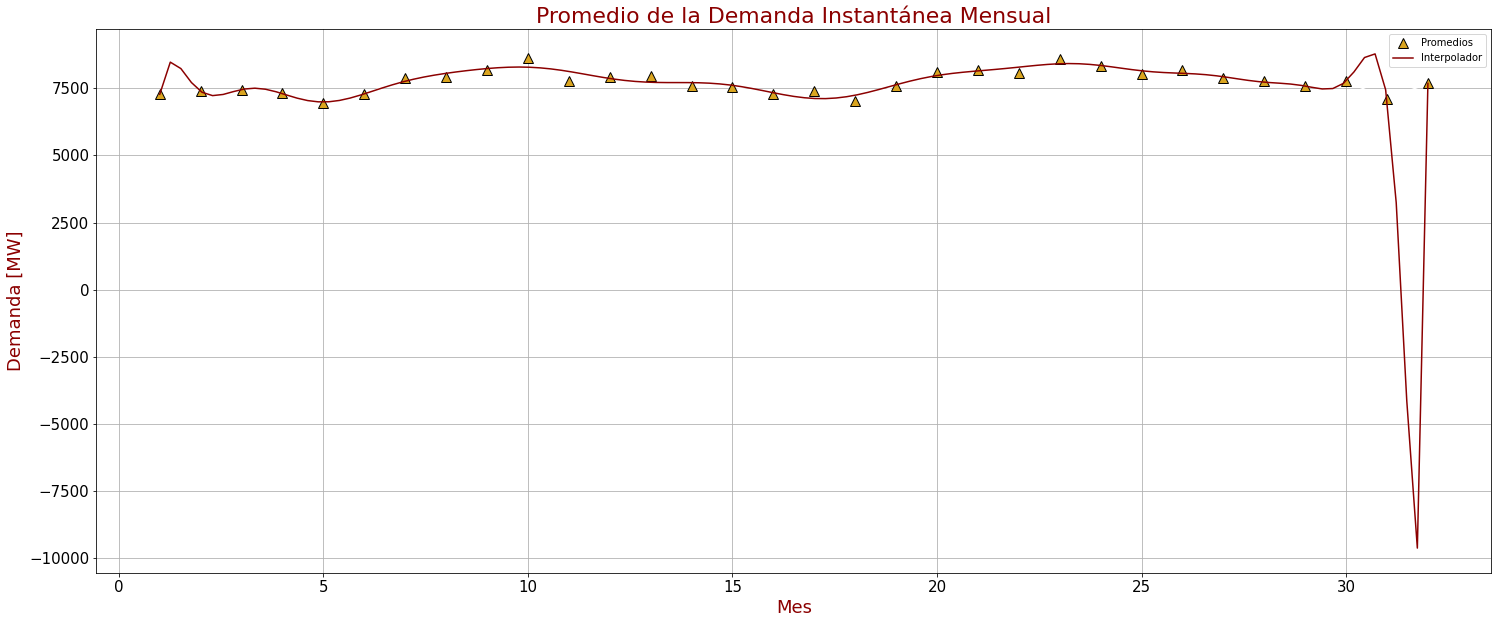

In [51]:
plt.figure(figsize=(25,10))
plt.plot(x_mes_i , prom_mes_i , color= 'white' ,
         marker = '^' , markersize = 10.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(x_mes_grph_1 , y_mes_grph_1 , color = 'darkred')
plt.title("Promedio de la Demanda Instantánea Mensual" , fontsize = 22 , color = 'darkred')
plt.xlabel("Mes" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Promedios","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Promedio_Demanda_Mes_Inter_1.png')
plt.show()

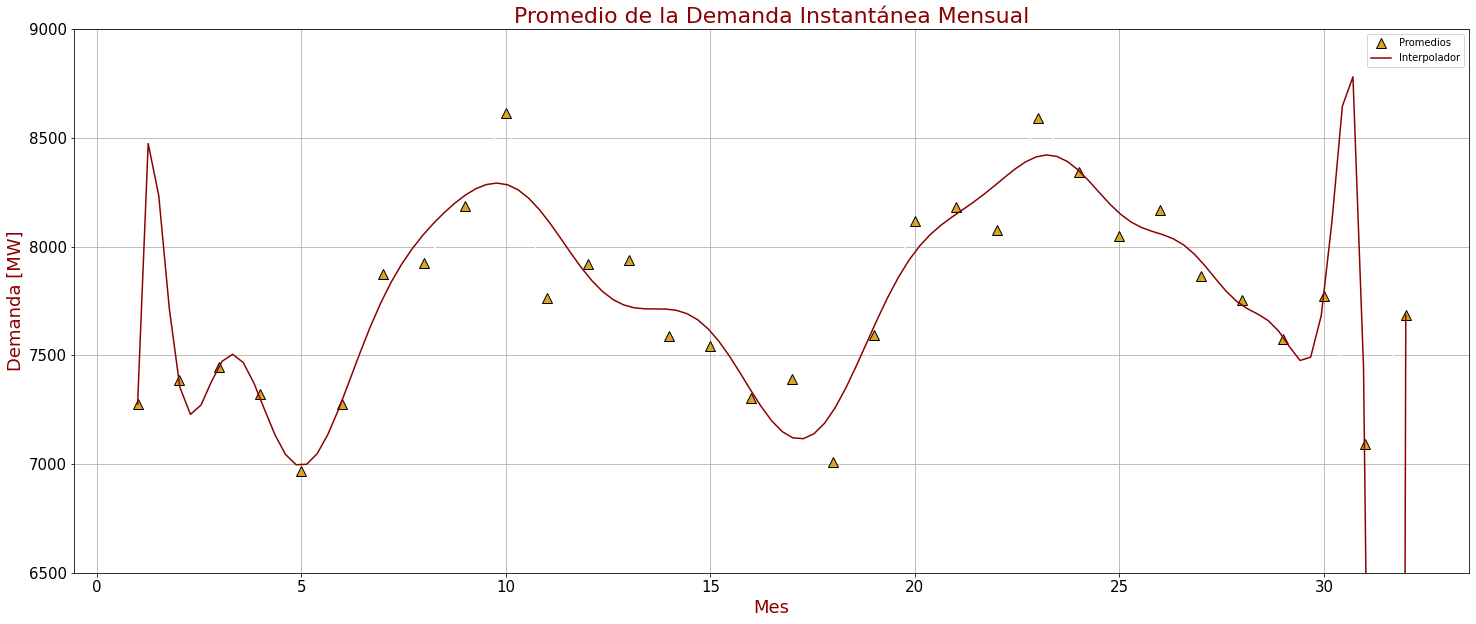

In [50]:
plt.figure(figsize=(25,10))
plt.plot(x_mes_i , prom_mes_i , color= 'white' ,
         marker = '^' , markersize = 10.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(x_mes_grph_1 , y_mes_grph_1 , color = 'darkred')
plt.title("Promedio de la Demanda Instantánea Mensual" , fontsize = 22 , color = 'darkred')
plt.xlabel("Mes" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Promedios","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylim([6500,9000]) 
plt.grid(True)
plt.savefig('Promedio_Demanda_Inter_Mes_2.png')
plt.show()

Análogamente al caso anterior, veamos si este modelo se acerca a los promedio de los meses restantes

In [48]:
mpoints = len(prom_mes) + 1
x_mes_grph_2 = np.linspace(min(x_mes) , max(x_mes) , mpoints)
y_mes_grph_2 = np.polyval(inter_mes , x_mes_grph_2)

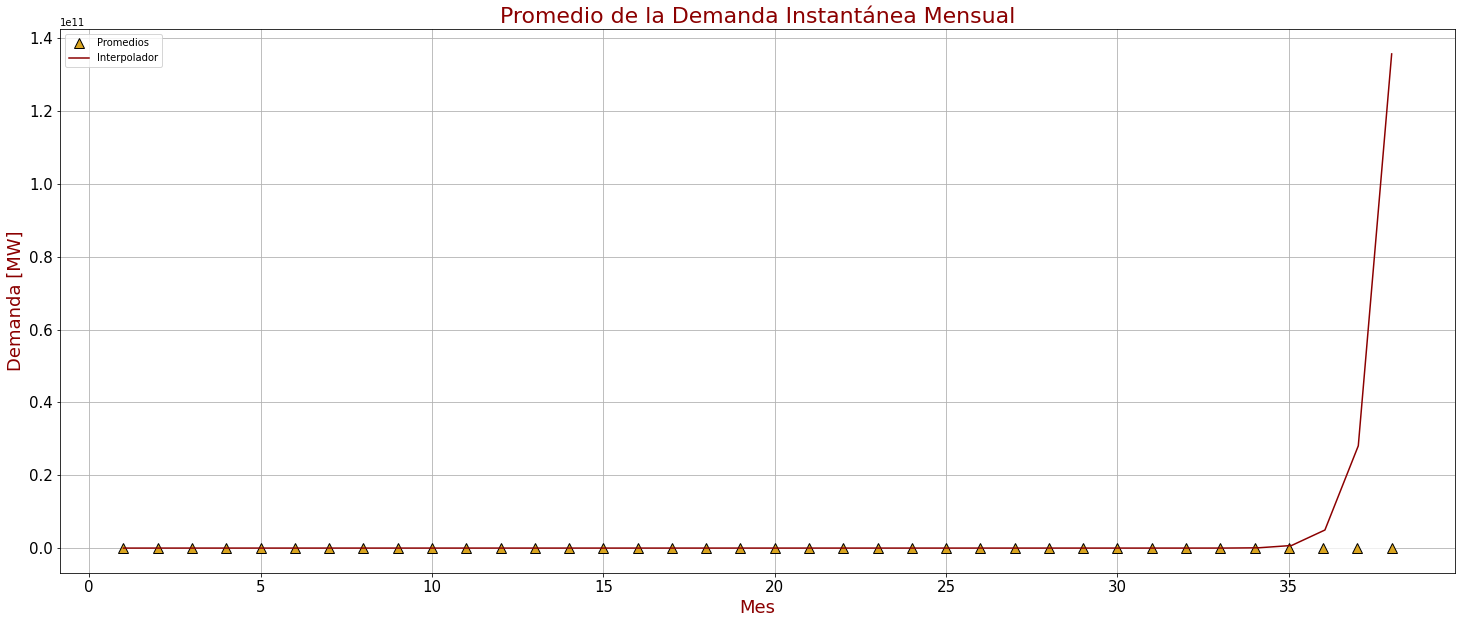

In [49]:
plt.figure(figsize=(25,10))
plt.plot(x_mes , prom_mes , color= 'white' ,
         marker = '^' , markersize = 10.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(x_mes_grph_2 , y_mes_grph_2 , color = 'darkred')
plt.title("Promedio de la Demanda Instantánea Mensual" , fontsize = 22 , color = 'darkred')
plt.xlabel("Mes" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Promedios","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Promedio_Demanda_Mes_Inter_3.png')
plt.show()

donde el *close-up* es

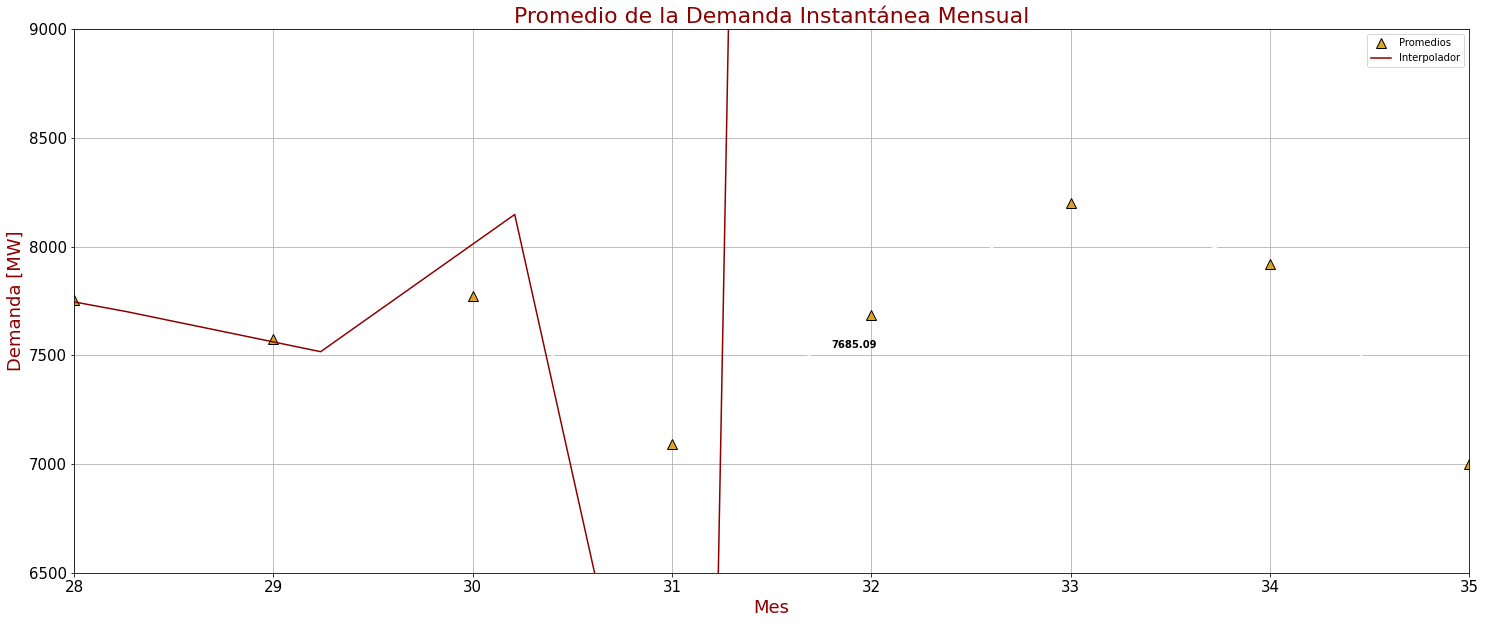

In [52]:
plt.figure(figsize=(25,10))
plt.plot(x_mes , prom_mes , color= 'white' ,
         marker = '^' , markersize = 10.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(x_mes_grph_2 , y_mes_grph_2 , color = 'darkred')
plt.text(31.8 , data_mes_i.iat[31,0] -150 , str(7685.09) , horizontalalignment = 'left' , fontweight = "bold")
plt.title("Promedio de la Demanda Instantánea Mensual" , fontsize = 22 , color = 'darkred')
plt.xlabel("Mes" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Promedios","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlim([28, 35]) 
plt.ylim([6500,9000]) 
plt.grid(True)
plt.savefig('Promedio_Demanda_Mes_Inter_4.png')
plt.show()

Se observa que el interpolador no es un buen modelo para el caso semanal ni mensual puesto que no sé acerca a los valores de su conjunto de test, respectivamente.

**Errores:**

Análogamente al caso semanal

In [53]:
prom_mes_obj_80 = prom_a_mes_i
prom_mes_80 = inter_mes

In [54]:
ecm_mes = MSE(prom_mes_obj_80 , prom_mes_80)
print(ecm_mes)

8916042848.336073


Vemos que incluso, en comparación con los promedios semanales, los errores para el caso mensual son incluso mayores.

### **Splines**

#### **Splines Para la Demanda Integrada a Segundo**

La función *interp1d()* también nos puede ayudar para generar un modelo para interpolar.  En primer lugar, usaremos la **demanda horaria** para generar un modelo interpolador, por medio de **splines cúbicos**:

In [7]:
from scipy.interpolate import interp1d

In [10]:
#Creando arreglo de las filas a remover del dataframe:
del_rows_100 = range(100,25152)
#Trabajando con 100 valores:
data_2_100 = data_2.drop(data_2.index[del_rows_100], axis = 0)

In [11]:
# Interpolación con polyfit n = 100 para el grado del polinimio
mpoints_100 = 100
d_100 = 99
x_100 = np.linspace(0, mpoints_100, mpoints_100)

In [12]:
coeff_100 = np.polyfit(x_100, data_2_100.dema_int, d_100)

Trabajaremos con splines de $n=1$

In [13]:
spline_100 = interp1d(x_100, data_2_100.dema_int, kind = 'cubic', fill_value='extrapolate')
y_eval_spline_100 = spline_100(x_100)
print('x_100.shape para verificar:', x_100.shape[0])
print('y_eval_spline_100.shape para verificar:', y_eval_spline_100.shape[0])

x_100.shape para verificar: 100
y_eval_spline_100.shape para verificar: 100


Gráfica con splines n = 100: 



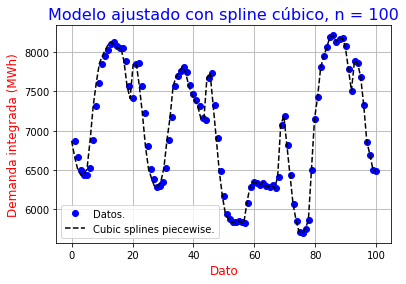

In [14]:
print("Gráfica con splines n = 100: \n")
plt.plot(data_2_100.muestras, data_2_100.dema_int, 'bo', x_100, y_eval_spline_100, 'k--')
plt.legend(['Datos.','Cubic splines piecewise.'], loc='best')
plt.title("Modelo ajustado con spline cúbico, n = 100", fontsize = 16, color ='b')
plt.xlabel('Dato', fontsize = 12, color = "red")
plt.ylabel('Demanda integrada (MWh)', fontsize= 12, color = "red")
plt.grid(True)
plt.show()

Trabajaremos con splines de $n=1500$

In [19]:
data_2_1500 = data_2.drop(data_2.index[del_rows_1500], axis = 0)

In [20]:
mpoints_1500 = 1500
d_1500 = 1499
x_1500 = np.linspace(0, mpoints_1500, mpoints_1500)

In [21]:
#Haciendo splines cúbicos, n = 1,500:
spline_1500 = interp1d(x_1500, data_2_1500.dema_int, kind = 'cubic', fill_value='extrapolate')
y_eval_spline_1500 = spline_1500(x_1500)
print('x_1500.shape para verificar:', x_1500.shape[0])
print('y_eval_spline_1500.shape para verificar:', y_eval_spline_1500.shape[0])

x_1500.shape para verificar: 1500
y_eval_spline_1500.shape para verificar: 1500


Gráfica con splines n = 1,500: 



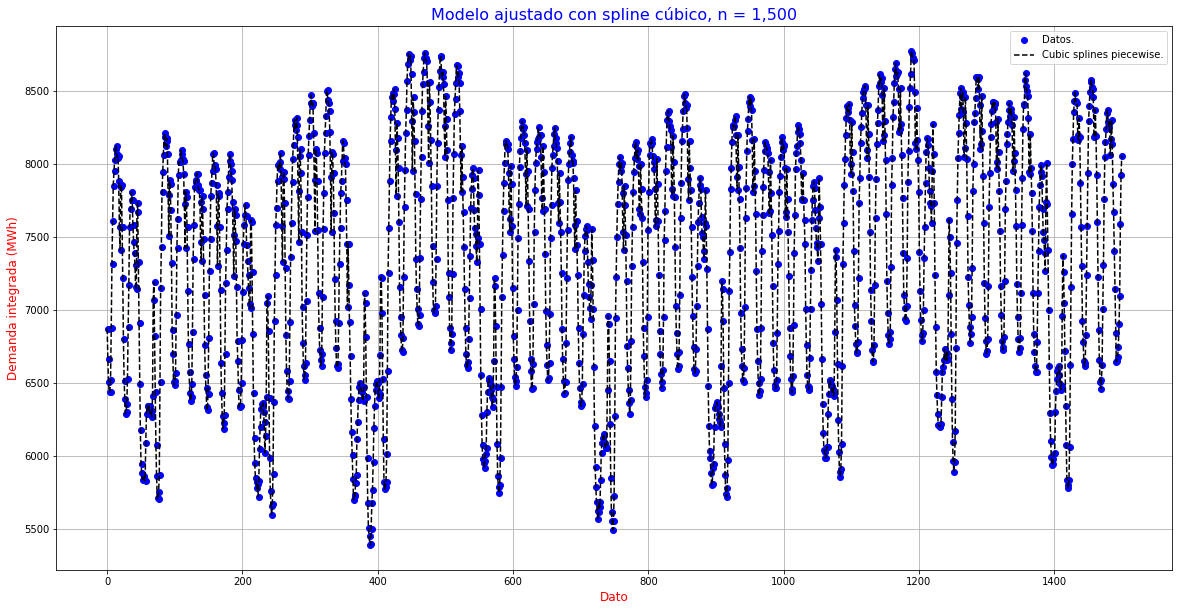

In [22]:
print("Gráfica con splines n = 1,500: \n")
fig = plt.figure(figsize=(20,10))
plt.plot(data_2_1500.muestras, data_2_1500.dema_int, 'bo', x_1500, y_eval_spline_1500, 'k--')
plt.legend(['Datos.','Cubic splines piecewise.'], loc='best')
plt.title("Modelo ajustado con spline cúbico, n = 1,500", fontsize = 16, color ='b')
plt.xlabel('Dato', fontsize = 12, color = "red")
plt.ylabel('Demanda integrada (MWh)', fontsize= 12, color = "red")
plt.grid(True)
plt.show()

Ahora iniciaremos las pruebas con splines para ver si el modelo describe bien los datos

**Trabajando con splines 100% de los datos:**

In [23]:
mpoints_100p = 25152
x_100p = np.linspace(0, mpoints_100p, mpoints_100p)
#Haciendo splines cúbicos, 100% datos:
spline_100p = interp1d(x_100p, data_2.dema_int, kind = 'cubic', fill_value='extrapolate')
y_eval_spline_100p = spline_100p(x_100p)
print('x_100%.shape para verificar:', x_100p.shape[0])
print('y_eval_spline_100%.shape para verificar:', y_eval_spline_100p.shape[0])

x_100%.shape para verificar: 25152
y_eval_spline_100%.shape para verificar: 25152


Gráfica con splines 100% datos: 



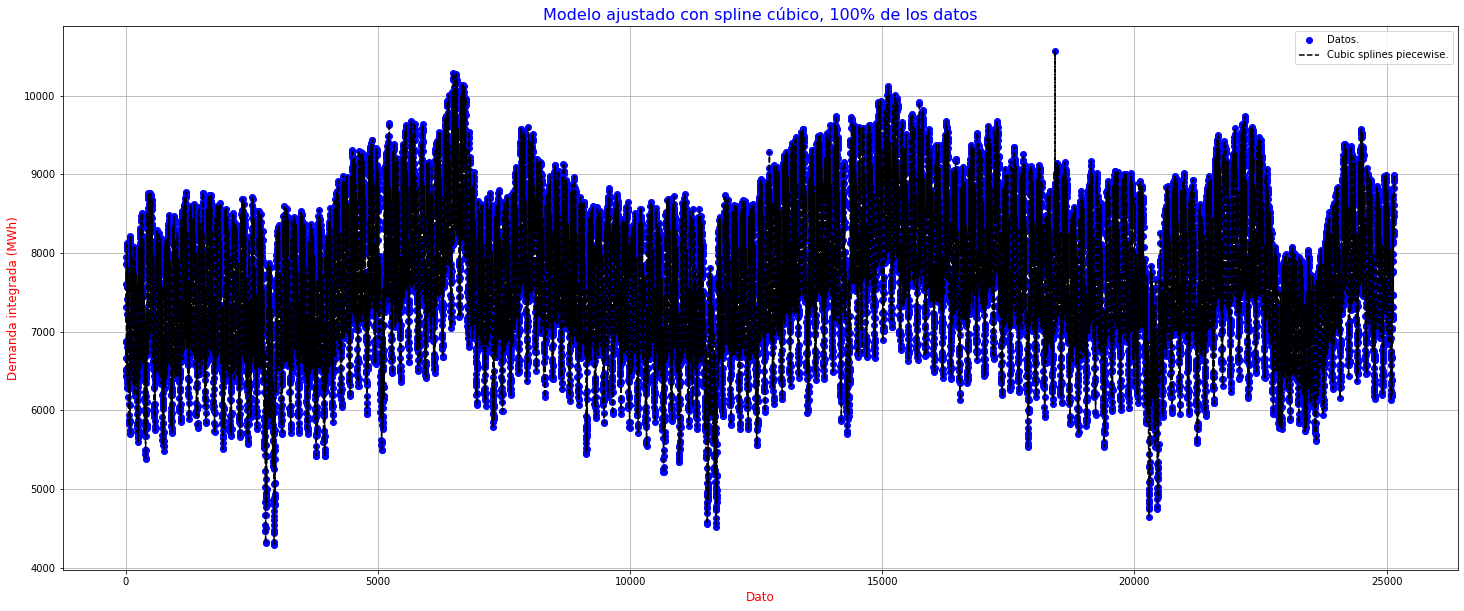

In [24]:
print("Gráfica con splines 100% datos: \n")
fig = plt.figure(figsize=(25,10))
plt.plot(data_2.index, data_2.dema_int, "bo", x_100p, y_eval_spline_100p, "k--")
plt.legend(['Datos.','Cubic splines piecewise.'], loc='best')
plt.title("Modelo ajustado con spline cúbico, 100% de los datos", fontsize = 16, color ='b')
plt.xlabel('Dato', fontsize = 12, color = "red")
plt.ylabel('Demanda integrada (MWh)', fontsize= 12, color = "red")
plt.grid(True)
plt.show()

**Trabajando con splines 80% de los datos para el conjunto de entrenamiento**

In [25]:
#Creando arreglo para eliminar el 20% final de los datos
del_rows_80p = range(20121,25152)
#Trabajando con el 80% de los valores valores:
data_2_80p = data_2.drop(data_2.index[del_rows_80p], axis = 0)
mpoints_80p = 20121
x_80p = np.linspace(0, mpoints_80p, mpoints_80p)
#Haciendo splines cúbicos, 80% datos:
spline_80p = interp1d(x_80p, data_2_80p.dema_int, kind = 'cubic', fill_value='extrapolate')

In [26]:
y_eval_spline_80p = spline_80p(x_80p)
print('x_80%.shape para verificar:', x_80p.shape[0])
print('y_eval_spline_80%.shape para verificar:', y_eval_spline_80p.shape[0])

x_80%.shape para verificar: 20121
y_eval_spline_80%.shape para verificar: 20121


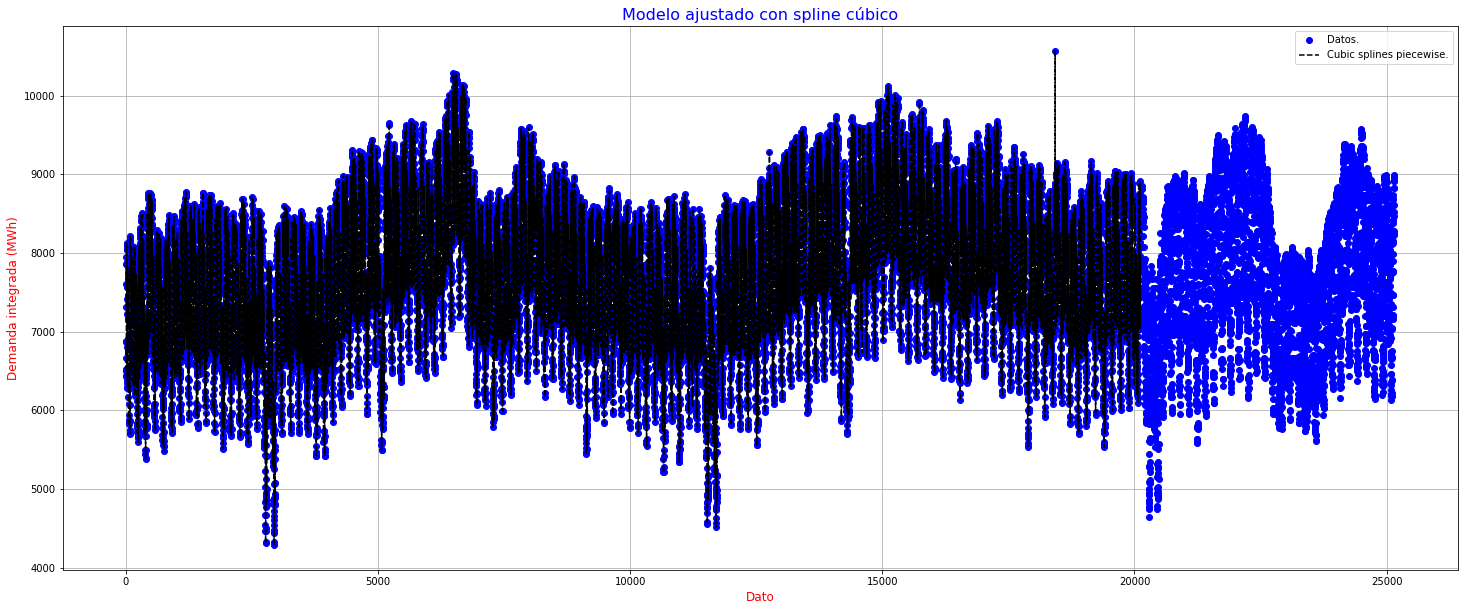

In [28]:
fig = plt.figure(figsize=(25,10))
plt.plot(data_2.index, data_2.dema_int, "bo", x_80p, y_eval_spline_80p, "k--")
plt.legend(['Datos.','Cubic splines piecewise.'], loc='best')
plt.title("Modelo ajustado con spline cúbico", fontsize = 16, color ='b')
plt.xlabel('Dato', fontsize = 12, color = "red")
plt.ylabel('Demanda integrada (MWh)', fontsize= 12, color = "red")
plt.grid(True)
plt.show()

Haciendo un zoom al spline con el $\% 80$ de los datos

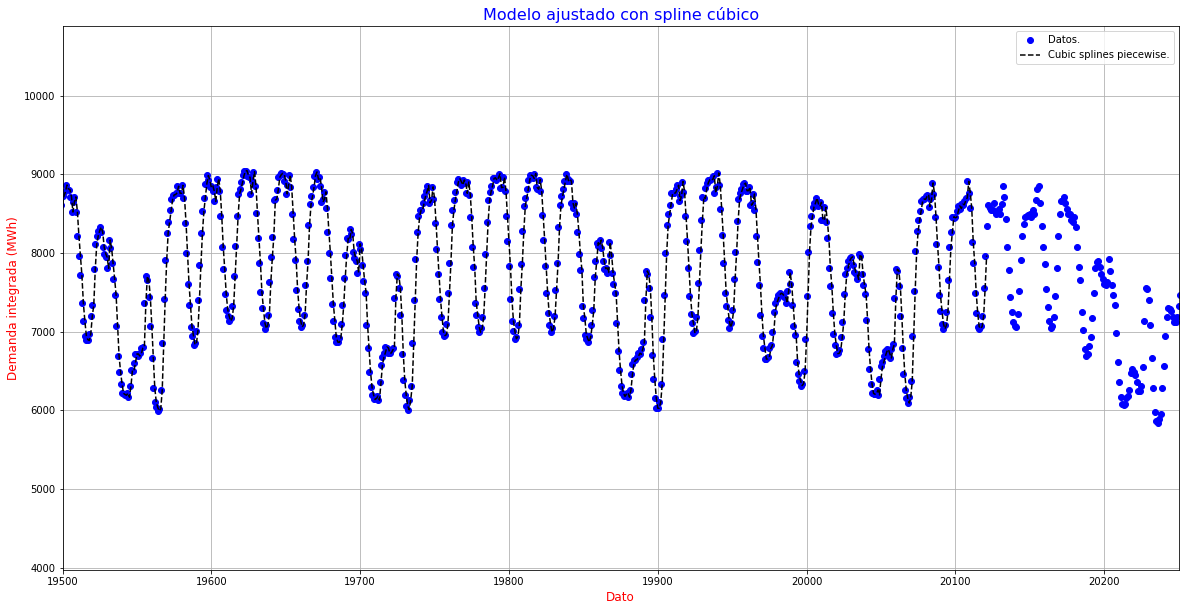

In [29]:
fig = plt.figure(figsize=(20,10))
plt.xlim(19500, 20250)
#plt.ylim(-5, 5)
plt.plot(data_2.index, data_2.dema_int, "bo", x_80p, y_eval_spline_80p, "k--")
plt.legend(['Datos.','Cubic splines piecewise.'], loc='best')
plt.title("Modelo ajustado con spline cúbico", fontsize = 16, color ='b')
plt.xlabel('Dato', fontsize = 12, color = "red")
plt.ylabel('Demanda integrada (MWh)', fontsize= 12, color = "red")
plt.grid(True)
plt.show()

Extrapolando con splines al 100% de los datos para ponerlo a prueba

In [30]:
y_eval_spline_80_100p = spline_80p(data_2.index)
print('x_80%.shape para verificar:', data_2.index)
print('y_eval_spline_80%.shape para verificar:', y_eval_spline_80_100p.shape[0])

x_80%.shape para verificar: RangeIndex(start=0, stop=25152, step=1)
y_eval_spline_80%.shape para verificar: 25152


Extrapolando con splines al 100% de los datos: 



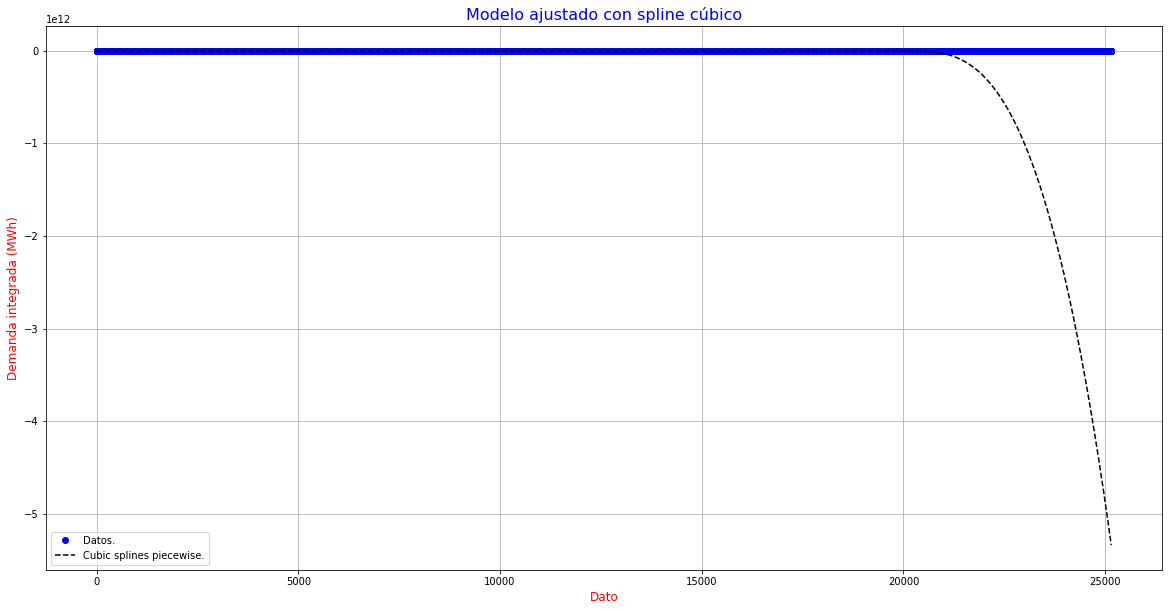

In [31]:
print("Extrapolando con splines al 100% de los datos: \n")
fig = plt.figure(figsize=(20,10))
plt.plot(data_2.index, data_2.dema_int, "bo", data_2.index, y_eval_spline_80_100p, "k--")
plt.legend(['Datos.','Cubic splines piecewise.'], loc='best')
plt.title("Modelo ajustado con spline cúbico", fontsize = 16, color ='b')
plt.xlabel('Dato', fontsize = 12, color = "red")
plt.ylabel('Demanda integrada (MWh)', fontsize= 12, color = "red")
plt.grid(True)
plt.show()

Haciendo zoom en el punto donde divergen las gráficas

Extrapolando con splines al 100% de los datos: 



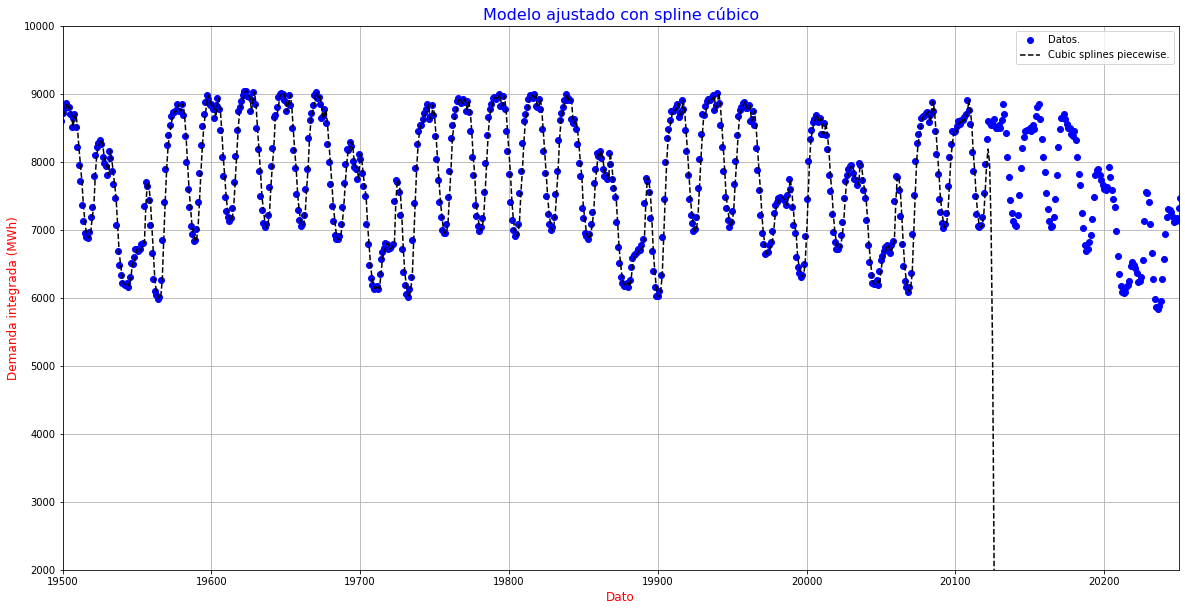

In [32]:
print("Extrapolando con splines al 100% de los datos: \n")
fig = plt.figure(figsize=(20,10))
plt.xlim(19500, 20250)
plt.ylim(2000, 10000)
plt.plot(data_2.index, data_2.dema_int, "bo", data_2.index, y_eval_spline_80_100p, "k--")
plt.legend(['Datos.','Cubic splines piecewise.'], loc='best')
plt.title("Modelo ajustado con spline cúbico", fontsize = 16, color ='b')
plt.xlabel('Dato', fontsize = 12, color = "red")
plt.ylabel('Demanda integrada (MWh)', fontsize= 12, color = "red")
plt.grid(True)
plt.show()

#### **Splines para la Demanda Integrada Semanal Promedio**

Usando splines con promedios semanales (100% de los datos):

In [33]:
prom_sem = [7193.166960541667,
 7248.862151440476,
 7331.153581321428,
 7368.65838170238,
 7169.082587488096,
 7331.714745238096,
 7482.9630442083335,
 7616.737792059524,
 7431.334553517858,
 7593.32658827381,
 7556.521984488094,
 7268.933052619047,
 7337.91220902381,
 7440.170972142857,
 7140.116526773809,
 7413.941581541666,
 6539.3820072976205,
 6550.370594440476,
 7413.5308106785715,
 7401.275319869047,
 7429.139407190477,
 7301.5526203750005,
 7190.300327196428,
 7213.042748505953,
 7609.114174238096,
 7817.782800696428,
 8019.149876482143,
 8093.100807672619,
 7947.070357208334,
 8063.0458459880965,
 7547.0522556845235,
 8186.744827011905,
 8167.383612345237,
 8440.261563178572,
 8115.990275011906,
 8062.677836351191,
 8178.600963005952,
 8476.134066755953,
 8909.141679017857,
 8947.921018113095,
 8312.816144863096,
 7696.614855089288,
 7589.655276708333,
 7499.96991792262,
 7602.322980880954,
 7710.36235335119,
 8206.044534458333,
 8195.104091000001,
 8149.365474339285,
 7783.062603738095,
 7950.33793689881,
 7932.696022065477,
 7790.477210767856,
 7661.542113309524,
 7382.688079160713,
 7558.930754809525,
 7478.252254791666,
 7678.583154208333,
 7596.379113529763,
 7453.5137827976205,
 7420.359167708334,
 7267.310636184525,
 7446.604925851191,
 7148.215668119048,
 7550.789678208334,
 7231.014473464287,
 7381.42572002976,
 7437.511726428571,
 6488.725000589286,
 6446.004482648809,
 7551.499959619046,
 7583.331814613094,
 7558.748498940476,
 7522.6331781011895,
 7456.47233092262,
 7867.368319708335,
 7970.645926375,
 8040.41864222619,
 8189.049325726191,
 8320.095403619047,
 7924.367549958333,
 8274.872974934524,
 8272.407417511906,
 8311.24906754762,
 7899.729421946428,
 7733.703677660714,
 8250.437164654762,
 8463.588675880954,
 8453.821887988097,
 8735.981564267855,
 8777.175237279762,
 8430.672419553572,
 8419.009096696429,
 8464.105880095238,
 8356.895205505953,
 8178.575219869047,
 8252.400725988095,
 8072.004479761905,
 7868.336338839284,
 8016.437208505951,
 8257.269630744047,
 8187.882181416667,
 8367.596797130955,
 7908.008033035714,
 8009.070136934525,
 7959.480421375,
 7619.935788690476,
 7924.401004321429,
 7686.114920238096,
 7827.579433380954,
 7943.894657261905,
 7616.06907172619,
 7520.413125303571,
 7665.28475510119,
 7799.769635375001,
 7389.2888105119055,
 7853.069151916667,
 7855.5966347023805,
 7709.2455980357145,
 7729.280682803571,
 6715.628269672618,
 6412.592887184524,
 7467.017612154763,
 7815.148776982142,
 7856.54204210119,
 7767.998425208333,
 7421.902177494048,
 7730.024130982142,
 8090.744672065477,
 8234.659008357145,
 8211.01438169643,
 8304.604116482142,
 8136.518385255954,
 8306.359873773808,
 7974.234591910713,
 7306.012978386904,
 6880.019552547618,
 7194.492867232142,
 7107.165434726191,
 6851.279484940475,
 6920.636410386905,
 7369.649709845237,
 7710.0343625000005,
 7981.166451255953,
 8170.70843970238,
 8153.383904208333,
 7986.661686613094,
 7670.2396034226185,
 7793.2501059999995,
 7597.501642083333]

In [34]:
prom_a_sem = np.array(prom_sem)
x_sem = np.array(list(range(1,len(prom_sem)+1)))
data_sem = pd.DataFrame(prom_sem, columns = ['Promedio'])
sem = pd.DataFrame(x_sem, columns = ['Semana']) 
data_sem['Semana'] = sem['Semana']

El dataFrame final con los promedios semanales se ve así:

In [35]:
data_sem

Promedio  Semana
0    7193.166961       1
1    7248.862151       2
2    7331.153581       3
3    7368.658382       4
4    7169.082587       5
..           ...     ...
145  8153.383904     146
146  7986.661687     147
147  7670.239603     148
148  7793.250106     149
149  7597.501642     150

[150 rows x 2 columns]

In [36]:
mpoints_sem = 150
x_sem = np.linspace(0, 149, mpoints_sem)
#Haciendo splines cúbicos, 100% promedios semanales:
spline_sem = interp1d(x_sem, data_sem.Promedio, kind = 'cubic', fill_value='extrapolate')
y_eval_spline_sem = spline_sem(x_sem)
print('x_sem.shape para verificar:', x_sem.shape[0])
print('y_eval_spline_sem.shape para verificar:', y_eval_spline_sem.shape[0])

x_sem.shape para verificar: 150
y_eval_spline_sem.shape para verificar: 150


Gráfica con splines 100% promedios semanales: 



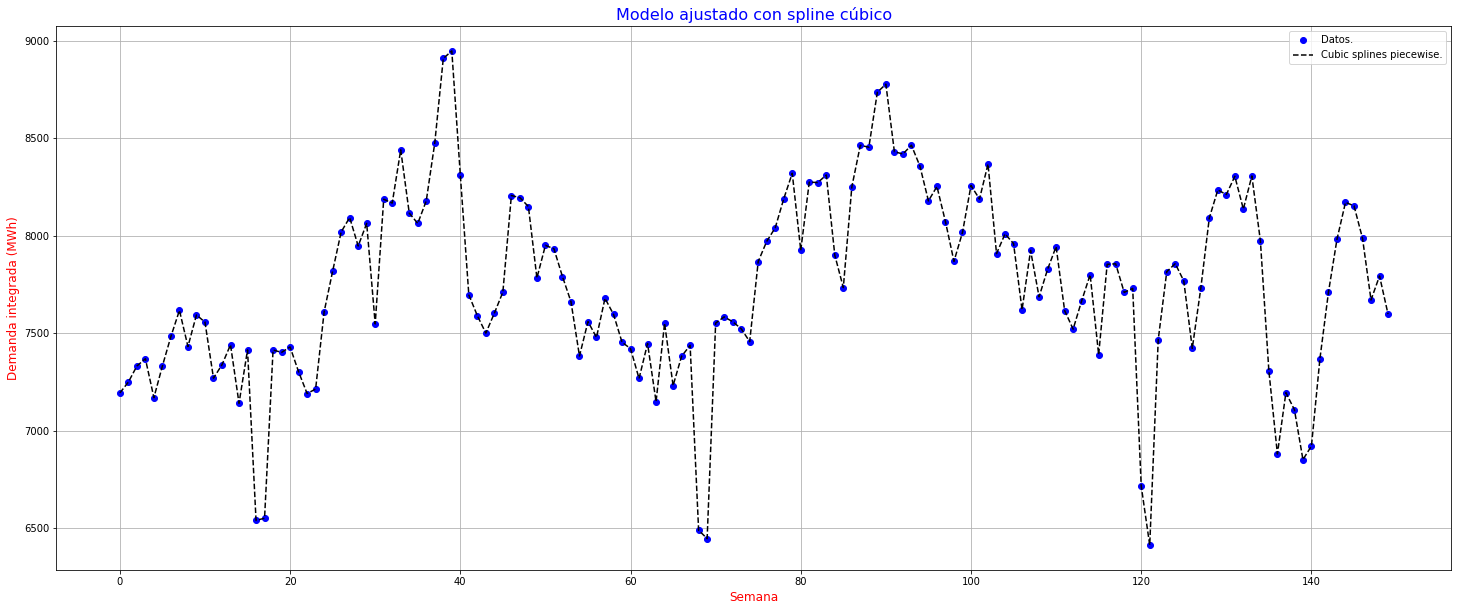

In [37]:
print("Gráfica con splines 100% promedios semanales: \n")
fig = plt.figure(figsize=(25,10))
plt.plot(data_sem.index, data_sem.Promedio, "bo", x_sem, y_eval_spline_sem, "k--")
plt.legend(['Datos.','Cubic splines piecewise.'], loc='best')
plt.title("Modelo ajustado con spline cúbico", fontsize = 16, color ='b')
plt.xlabel('Semana', fontsize = 12, color = "red")
plt.ylabel('Demanda integrada (MWh)', fontsize= 12, color = "red")
plt.grid(True)
plt.show()

**Usando splines con promedios semanales (80% de los datos):**

In [38]:
#Creando arreglo para eliminar el 20% final de los datos semanales:
del_rows_sem_80p = range(120,150)
print(del_rows_sem_80p)
#Trabajando con el 80% de los valores valores:
data_sem_80p = data_sem.drop(data_sem.index[del_rows_sem_80p], axis = 0)
data_sem_80p

range(120, 150)


Promedio  Semana
0    7193.166961       1
1    7248.862151       2
2    7331.153581       3
3    7368.658382       4
4    7169.082587       5
..           ...     ...
115  7389.288811     116
116  7853.069152     117
117  7855.596635     118
118  7709.245598     119
119  7729.280683     120

[120 rows x 2 columns]

In [39]:
mpoints_sem_80p = 120
x_sem_80p = np.linspace(0, 119, mpoints_sem_80p)
#Haciendo splines cúbicos, 80% promedios semanales:
spline_sem_80p = interp1d(x_sem_80p, data_sem_80p.Promedio, kind = 'cubic', fill_value='extrapolate')
y_eval_spline_sem_80p = spline_sem_80p(x_sem_80p)
print('x_sem.shape para verificar:', x_sem_80p.shape[0])
print('y_eval_spline_sem.shape para verificar:', y_eval_spline_sem_80p.shape[0])

x_sem.shape para verificar: 120
y_eval_spline_sem.shape para verificar: 120


Gráfica con splines 80% promedios semanales: 



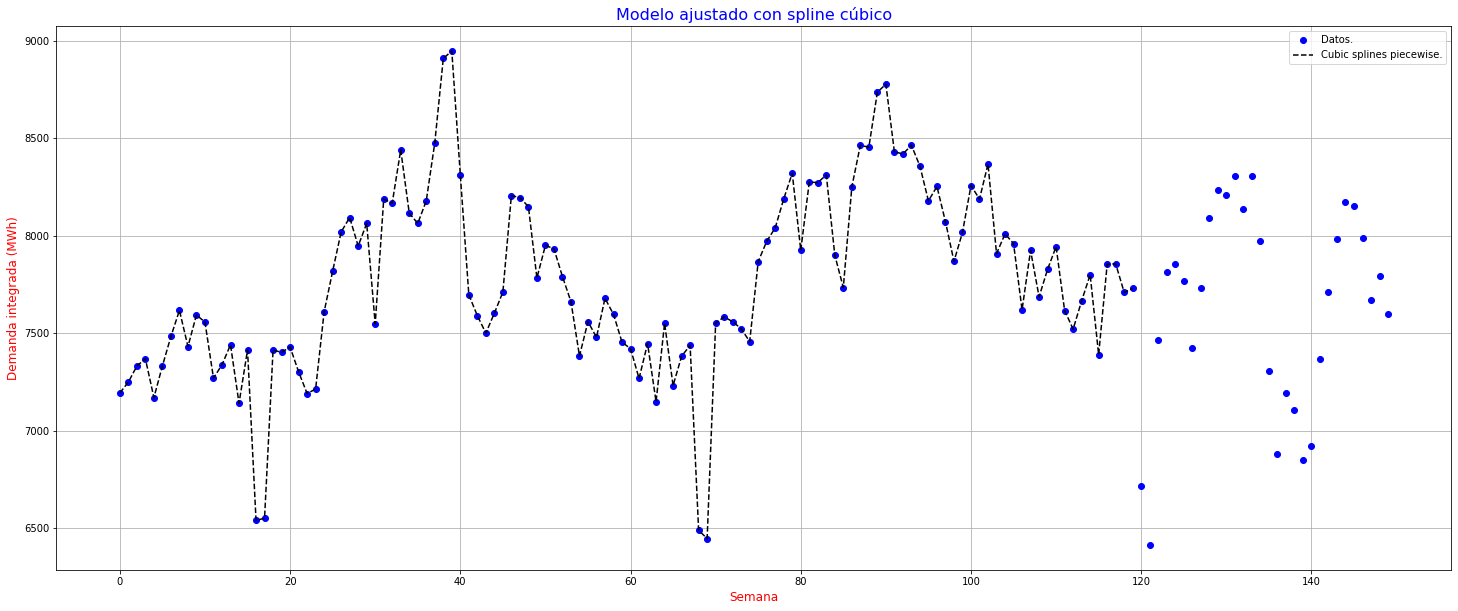

In [40]:
print("Gráfica con splines 80% promedios semanales: \n")
fig = plt.figure(figsize=(25,10))
plt.plot(data_sem.index, data_sem.Promedio, "bo", x_sem_80p, y_eval_spline_sem_80p, "k--")
plt.legend(['Datos.','Cubic splines piecewise.'], loc='best')
plt.title("Modelo ajustado con spline cúbico", fontsize = 16, color ='b')
plt.xlabel('Semana', fontsize = 12, color = "red")
plt.ylabel('Demanda integrada (MWh)', fontsize= 12, color = "red")
plt.grid(True)
plt.show()

**Extrapolando con splines al 100% de los datos semanales:**

In [41]:
y_eval_spline_sem_80_100p = spline_sem_80p(data_sem.index)
print('x_80%.shape para verificar:', data_sem.index)
print('y_eval_spline_80%.shape para verificar:', y_eval_spline_sem_80_100p.shape[0])

x_80%.shape para verificar: RangeIndex(start=0, stop=150, step=1)
y_eval_spline_80%.shape para verificar: 150


Extrapolando con splines al 100% de los datos semanales: 



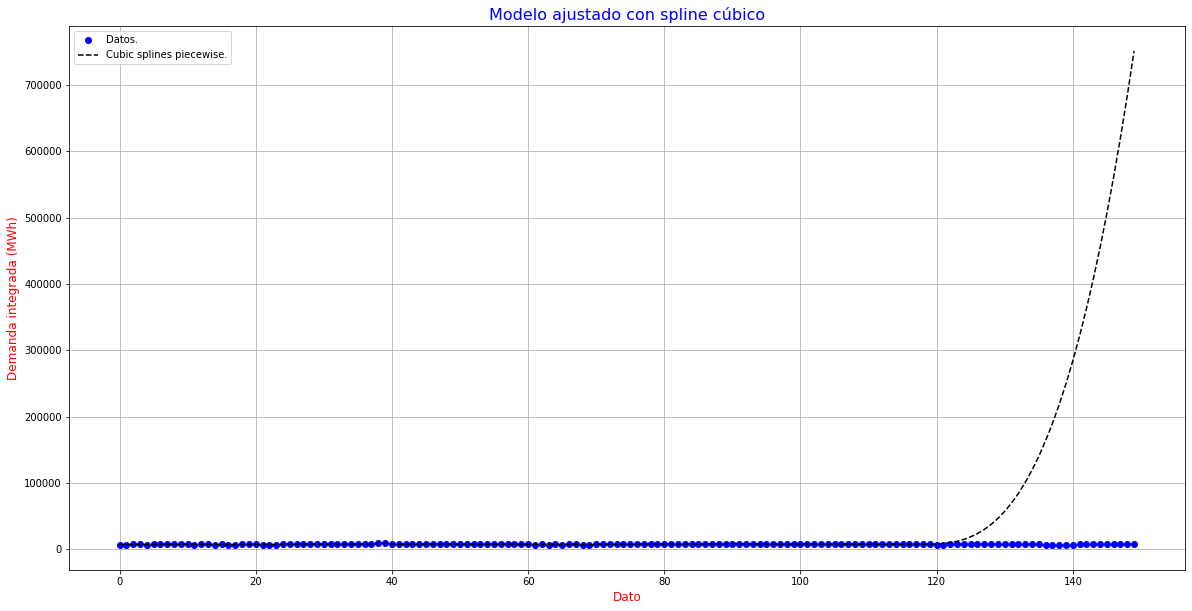

In [42]:
print("Extrapolando con splines al 100% de los datos semanales: \n")
fig = plt.figure(figsize=(20,10))
plt.plot(data_sem.index, data_sem.Promedio, "bo", data_sem.index, y_eval_spline_sem_80_100p, "k--")
plt.legend(['Datos.','Cubic splines piecewise.'], loc='best')
plt.title("Modelo ajustado con spline cúbico", fontsize = 16, color ='b')
plt.xlabel('Dato', fontsize = 12, color = "red")
plt.ylabel('Demanda integrada (MWh)', fontsize= 12, color = "red")
plt.grid(True)
plt.show()

**Haciendo zoom al final:**

Extrapolando con splines al 100% de los datos semanales: 



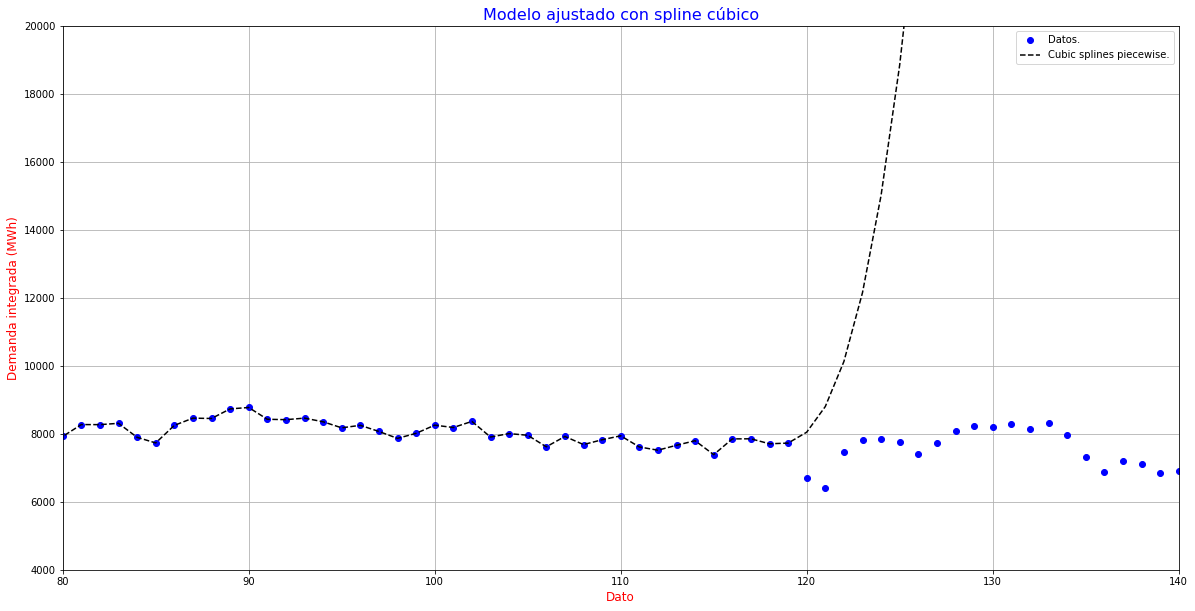

In [44]:
print("Extrapolando con splines al 100% de los datos semanales: \n")
fig = plt.figure(figsize=(20,10))
plt.xlim(80, 140)
plt.ylim(4000, 20000)
plt.plot(data_sem.index, data_sem.Promedio, "bo", data_sem.index, y_eval_spline_sem_80_100p, "k--")
plt.legend(['Datos.','Cubic splines piecewise.'], loc='best')
plt.title("Modelo ajustado con spline cúbico", fontsize = 16, color ='b')
plt.xlabel('Dato', fontsize = 12, color = "red")
plt.ylabel('Demanda integrada (MWh)', fontsize= 12, color = "red")
plt.grid(True)
plt.show()

#### **Splines Para Promedios Mensuales de la Demanda Integrada**

Usando splines con promedios mensuales (100% de los datos):

In [45]:
prom_mes = [7285.460268751487,
 7400.124542248513,
 7462.5290447247025,
 7333.035322370535,
 6976.139683071429,
 7283.508775816964,
 7884.786914772321,
 7935.978321473215,
 8196.578321721727,
 8627.949431723213,
 7774.764048645834,
 7928.458489922619,
 7953.865509260417,
 7598.409539511904,
 7551.6820763318465,
 7320.622599465774,
 7400.185399532738,
 7017.390314367559,
 7601.3055819181545,
 8130.052324486607,
 8195.724252488097,
 8086.864735035714,
 8599.412777272322,
 8354.646350541667,
 8052.294688273809,
 8180.1891605818455,
 7878.221837830358,
 7768.414520651786,
 7593.689081572917,
 7786.798016864584,
 7102.5968864985125,
 7694.116693946429,
 8210.2555446503,
 7930.781457331846,
 7008.239334861606,
 7495.371733497024,
 7995.248408486606,
 7695.375874041666]

In [46]:
prom_a_mes = np.array(prom_mes)
x_mes = np.array(list(range(1,39)))
data_mes = pd.DataFrame(prom_mes, columns = ['Promedio'])
mes = pd.DataFrame(x_mes, columns = ['Mes']) 
data_mes['Mes'] = mes['Mes']

In [48]:
data_mes.tail(4)

Promedio  Mes
34  7008.239335   35
35  7495.371733   36
36  7995.248408   37
37  7695.375874   38

In [49]:
mpoints_mes = 38
x_mes = np.linspace(0, 37, mpoints_mes)
#Haciendo splines cúbicos, 100% promedios mensuales:
spline_mes = interp1d(x_mes, data_mes.Promedio, kind = 'cubic', fill_value='extrapolate')
y_eval_spline_mes = spline_mes(x_mes)
print('x_mes.shape para verificar:', x_mes.shape[0])
print('y_eval_spline_mes.shape para verificar:', y_eval_spline_mes.shape[0])

x_mes.shape para verificar: 38
y_eval_spline_mes.shape para verificar: 38


Gráfica con splines 100% promedios mensuales: 



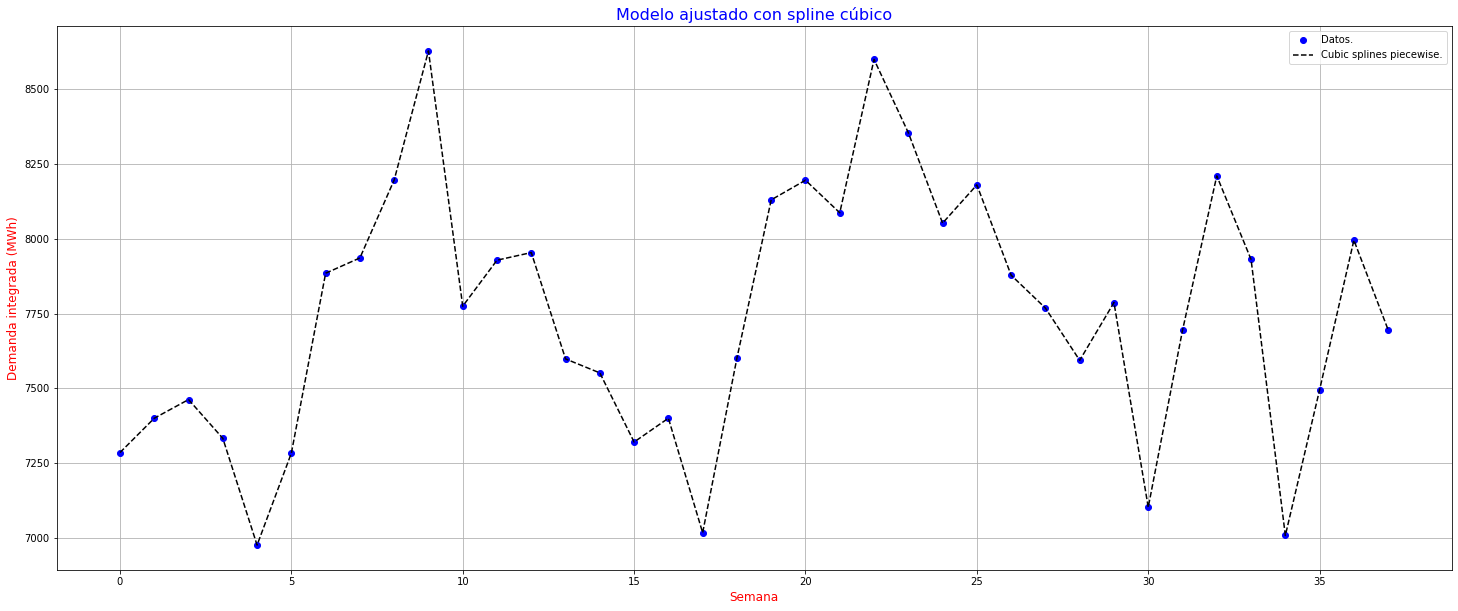

In [50]:
print("Gráfica con splines 100% promedios mensuales: \n")
fig = plt.figure(figsize=(25,10))
plt.plot(data_mes.index, data_mes.Promedio, "bo", x_mes, y_eval_spline_mes, "k--")
plt.legend(['Datos.','Cubic splines piecewise.'], loc='best')
plt.title("Modelo ajustado con spline cúbico", fontsize = 16, color ='b')
plt.xlabel('Semana', fontsize = 12, color = "red")
plt.ylabel('Demanda integrada (MWh)', fontsize= 12, color = "red")
plt.grid(True)
plt.show()

Usando splines con promedios mensuales (80% de los datos):

In [51]:
#Creando arreglo para eliminar el 20% final de los datos mensuales:
del_rows_mes_80p = range(30,38)
print(del_rows_mes_80p)
#Trabajando con el 80% de los valores valores:
data_mes_80p = data_mes.drop(data_mes.index[del_rows_mes_80p], axis = 0)

range(30, 38)


In [53]:
data_mes_80p.tail(5)

Promedio  Mes
25  8180.189161   26
26  7878.221838   27
27  7768.414521   28
28  7593.689082   29
29  7786.798017   30

In [54]:
mpoints_mes_80p = 30
x_mes_80p = np.linspace(0, 29, mpoints_mes_80p)
#Haciendo splines cúbicos, 80% promedios mensuales:
spline_mes_80p = interp1d(x_mes_80p, data_mes_80p.Promedio, kind = 'cubic', fill_value='extrapolate')
y_eval_spline_mes_80p = spline_mes_80p(x_mes_80p)
print('x_mes.shape para verificar:', x_mes_80p.shape[0])
print('y_eval_spline_mes.shape para verificar:', y_eval_spline_mes_80p.shape[0])

x_mes.shape para verificar: 30
y_eval_spline_mes.shape para verificar: 30


Gráfica con splines 80% promedios mensuales: 



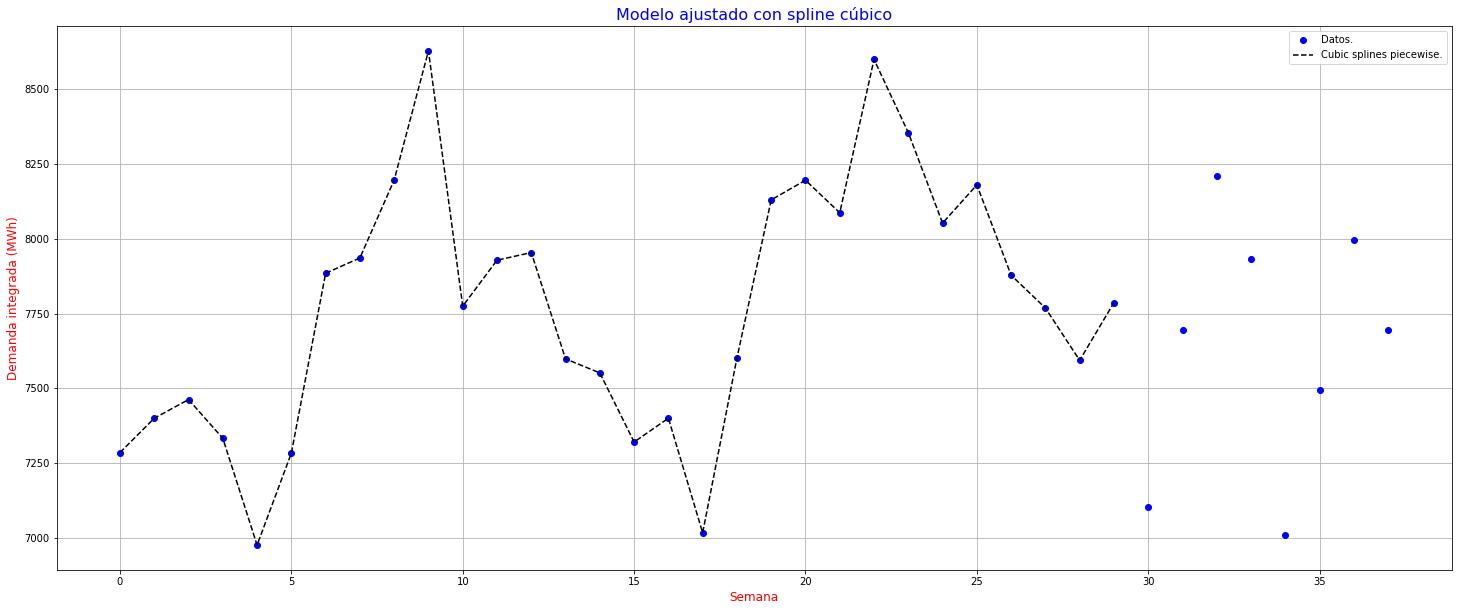

In [55]:
print("Gráfica con splines 80% promedios mensuales: \n")
fig = plt.figure(figsize=(25,10))
plt.plot(data_mes.index, data_mes.Promedio, "bo", x_mes_80p, y_eval_spline_mes_80p, "k--")
plt.legend(['Datos.','Cubic splines piecewise.'], loc='best')
plt.title("Modelo ajustado con spline cúbico", fontsize = 16, color ='b')
plt.xlabel('Semana', fontsize = 12, color = "red")
plt.ylabel('Demanda integrada (MWh)', fontsize= 12, color = "red")
plt.grid(True)
plt.show()

Extrapolando con splines al 100% de los datos mensuales:

In [56]:
y_eval_spline_mes_80_100p = spline_mes_80p(data_mes.index)
print('x_mes_80%.shape para verificar:', data_mes.index)
print('y_eval_spline_mes_80%.shape para verificar:', y_eval_spline_mes_80_100p.shape[0])

x_mes_80%.shape para verificar: RangeIndex(start=0, stop=38, step=1)
y_eval_spline_mes_80%.shape para verificar: 38


Extrapolando con splines al 100% de los datos mensuales: 



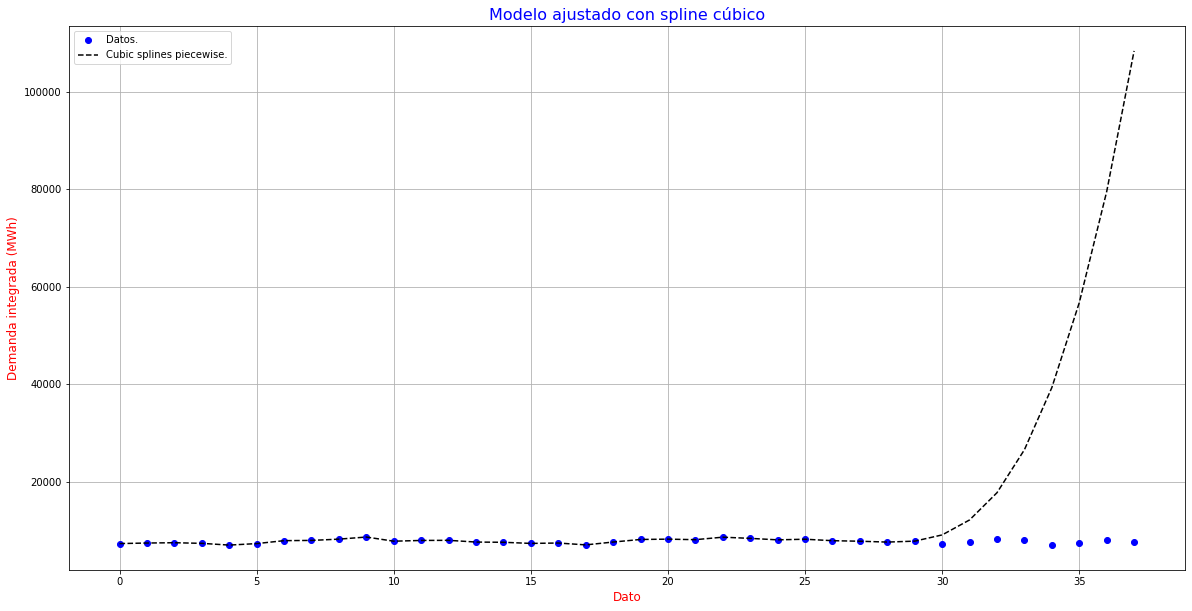

In [57]:
print("Extrapolando con splines al 100% de los datos mensuales: \n")
fig = plt.figure(figsize=(20,10))
plt.plot(data_mes.index, data_mes.Promedio, "bo", data_mes.index, y_eval_spline_mes_80_100p, "k--")
plt.legend(['Datos.','Cubic splines piecewise.'], loc='best')
plt.title("Modelo ajustado con spline cúbico", fontsize = 16, color ='b')
plt.xlabel('Dato', fontsize = 12, color = "red")
plt.ylabel('Demanda integrada (MWh)', fontsize= 12, color = "red")
plt.grid(True)
plt.show()

Haciendo zoom al final:

Extrapolando con splines al 100% de los datos mensuales: 



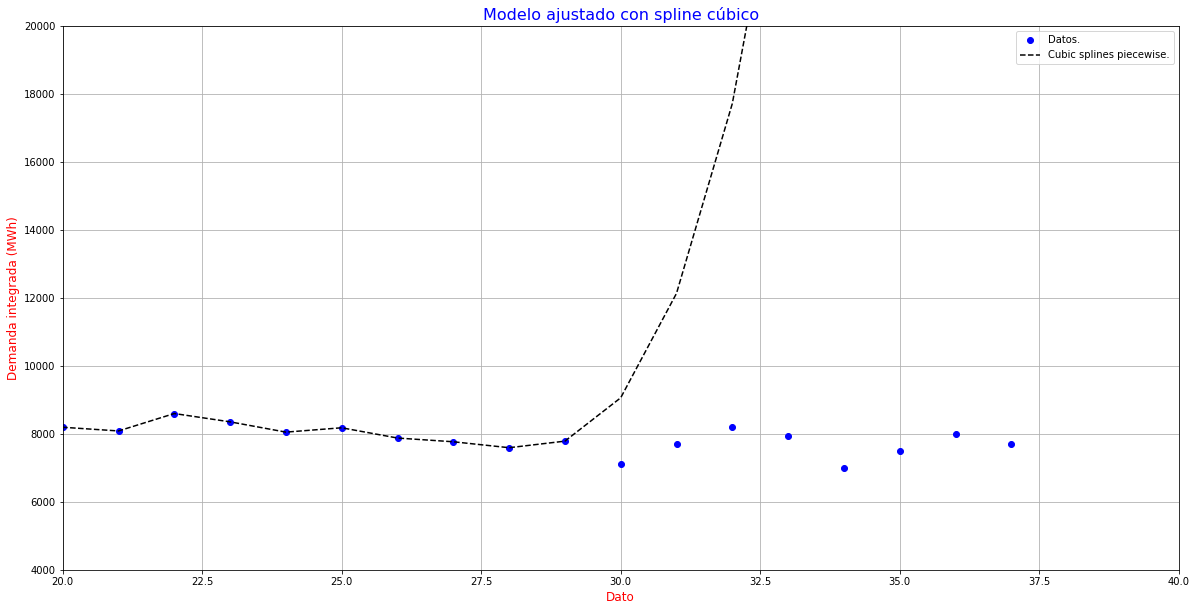

In [58]:
print("Extrapolando con splines al 100% de los datos mensuales: \n")
fig = plt.figure(figsize=(20,10))
plt.xlim(20, 40)
plt.ylim(4000, 20000)
plt.plot(data_mes.index, data_mes.Promedio, "bo", data_mes.index, y_eval_spline_mes_80_100p, "k--")
plt.legend(['Datos.','Cubic splines piecewise.'], loc='best')
plt.title("Modelo ajustado con spline cúbico", fontsize = 16, color ='b')
plt.xlabel('Dato', fontsize = 12, color = "red")
plt.ylabel('Demanda integrada (MWh)', fontsize= 12, color = "red")
plt.grid(True)
plt.show()

### **Splines Para la Demanda Instantánea**

### **Demanda por Hora**

In [103]:
mpoints_100p_l = 25152
x_100p_l = np.linspace(0, mpoints_100p_l, mpoints_100p_l)
spline_100p_l = interp1d(x_100p_l, data_int['Demanda Instantánea'], kind = 'cubic', fill_value='extrapolate')
y_eval_spline_100p_l = spline_100p_l(x_100p_l)

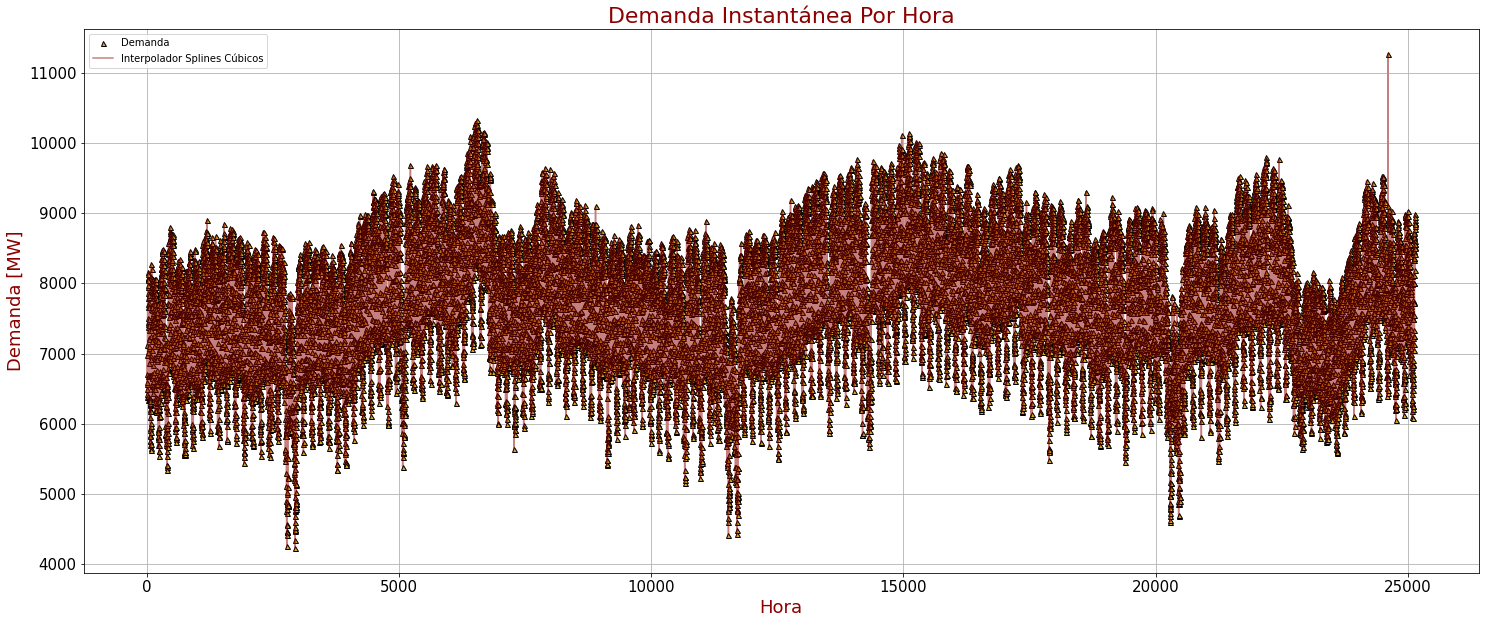

In [104]:
plt.figure(figsize=(25,10))
plt.plot(data_int.index, data_int['Demanda Instantánea'], color= 'white' ,
         marker = '^' , markersize = 5.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(x_100p_l, y_eval_spline_100p_l, color = 'darkred' , alpha = 0.5)
plt.title("Demanda Instantánea Por Hora" , fontsize = 22 , color = 'darkred')
plt.xlabel("Hora" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Demanda","Interpolador Splines Cúbicos"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Demanda_hora_spline.png')
plt.show()

#### **Demanda Promedio Diaria** 

Aunque con splines no excedemos el número máximo de elementos con los que podemos trabajar, para que la gráfica se vea menos saturada, realizamos de nuevo el modelo, ahora considerando el promedio diario:

In [105]:
spline_dia_l = interp1d(x_dia, prom_a_dia, kind = 'cubic', fill_value='extrapolate')
x_eval_spline_dia_l = np.linspace(0,len(x_dia),5000)
y_eval_spline_dia_l = spline_dia_l(x_eval_spline_dia_l)

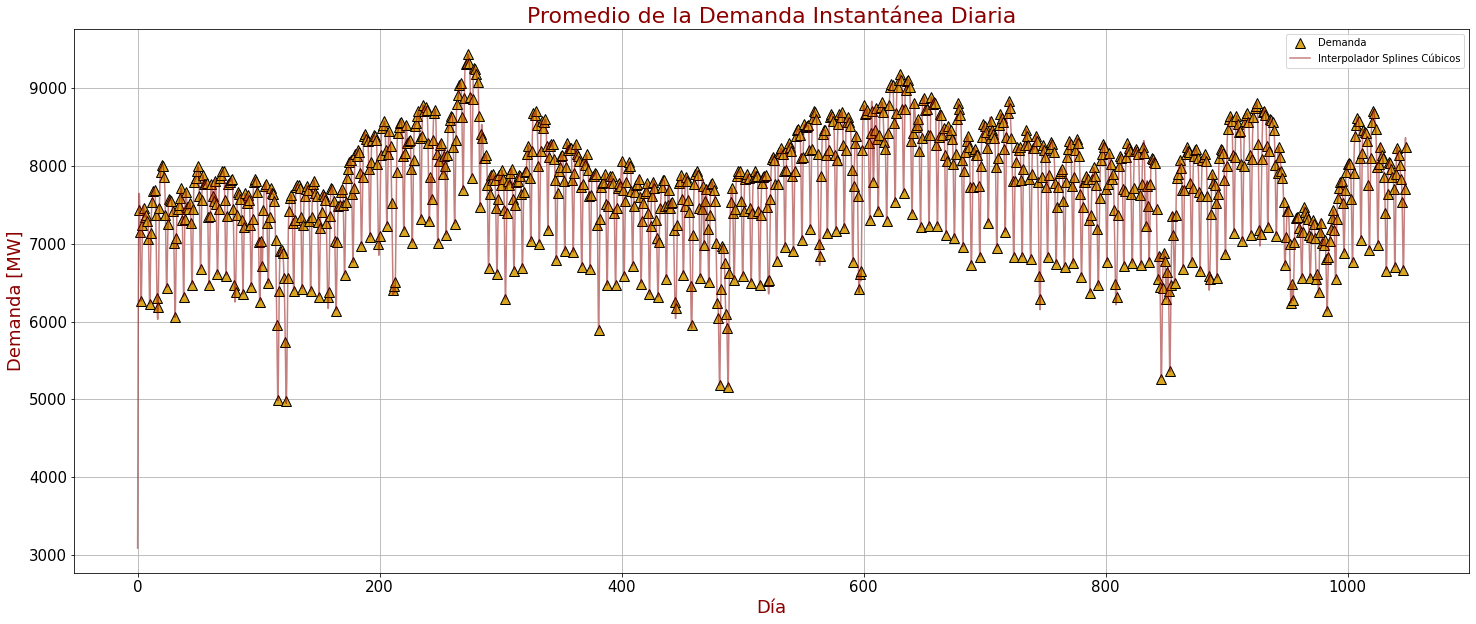

In [110]:
plt.figure(figsize=(25,10))
plt.plot(x_dia , prom_a_dia , color= 'white' ,
         marker = '^' , markersize = 10.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(x_eval_spline_dia_l, y_eval_spline_dia_l, color = 'darkred' , alpha = 0.5)
plt.title("Promedio de la Demanda Instantánea Diaria" , fontsize = 22 , color = 'darkred')
plt.xlabel("Día" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Demanda","Interpolador Splines Cúbicos"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Demanda_dia_spline.png')
plt.show()

#### **Demanda Promedio Semanal** 

Realizamos de nuevo el modelo usando splines, con el promedio semanal:

In [107]:
dias_tot_l = 1048 # Dias totales registrados
num_sem_l = int(dias_tot_l/7)
prom_sem_l = []
for i in range(0,num_sem_l):
    ini = 7*i
    end = 7*(1+i)
    data_i = prom_a_dia[ini:end]
    prom_sem_l.append(np.mean(prom_a_dia[ini:end]))
    
prom_a_sem_l = np.array(prom_sem_l)
x_sem_l = np.array(list(range(1,len(prom_sem_l)+1)))    

In [108]:
spline_sem_l = interp1d(x_sem_l, prom_a_sem_l, kind = 'cubic', fill_value='extrapolate')
x_eval_spline_sem_l = np.linspace(0,len(x_sem_l),5000)
y_eval_spline_sem_l = spline_sem_l(x_eval_spline_sem_l)

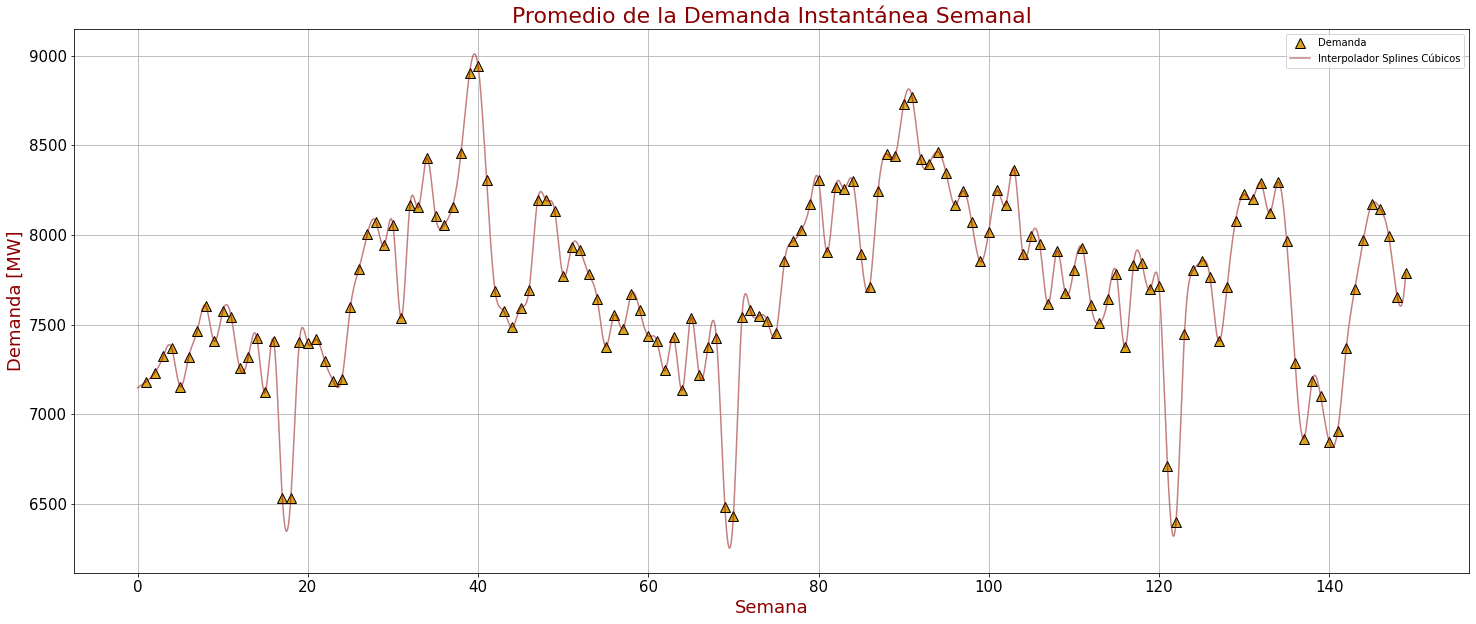

In [111]:
plt.figure(figsize=(25,10))
plt.plot(x_sem_l, prom_a_sem_l, color= 'white' ,
         marker = '^' , markersize = 10.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(x_eval_spline_sem_l, y_eval_spline_sem_l, color = 'darkred' , alpha = 0.5)
plt.title("Promedio de la Demanda Instantánea Semanal" , fontsize = 22 , color = 'darkred')
plt.xlabel("Semana" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Demanda","Interpolador Splines Cúbicos"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Demanda_semana_spline.png')
plt.show()

#### **Demanda Promedio Mensual** 

Realizamos de nuevo el modelo usando splines, con el promedio mensual:

In [113]:
sem_tot_l = 149 # Seamanas totales registradas
num_mes_l = int(sem_tot_l/4)
prom_mes_l = []
for i in range(0,num_mes_l):
    ini = 4*i
    end = 4*(1+i)
    data_i = prom_a_sem_l[ini:end]
    prom_mes_l.append(np.mean(prom_a_sem_l[ini:end]))
    
prom_a_mes_l = np.array(prom_mes_l)
x_mes_l = np.array(list(range(1,len(prom_mes_l)+1)))

spline_mes_l = interp1d(x_mes_l, prom_a_mes_l, kind = 'cubic', fill_value='extrapolate')
x_eval_spline_mes_l = np.linspace(0,len(x_mes_l),5000)
y_eval_spline_mes_l = spline_mes_l(x_eval_spline_mes_l)

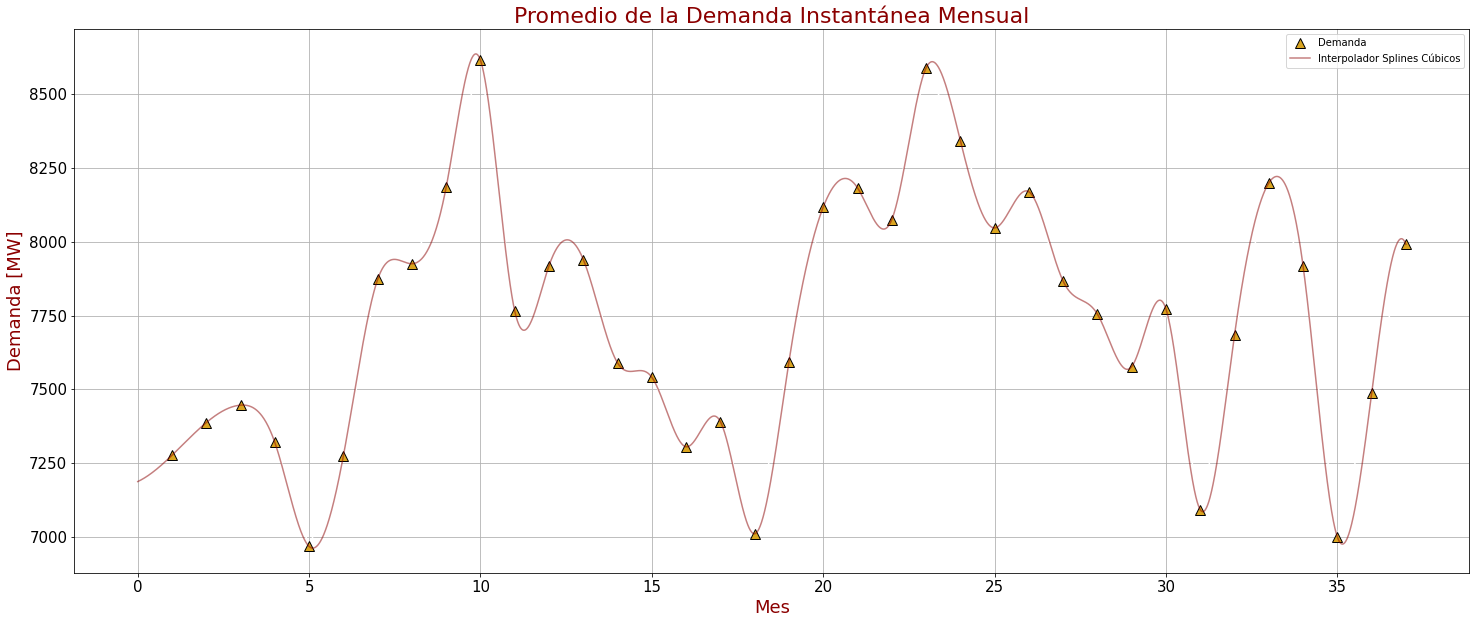

In [114]:
plt.figure(figsize=(25,10))
plt.plot(x_mes_l, prom_a_mes_l, color= 'white' ,
         marker = '^' , markersize = 10.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(x_eval_spline_mes_l, y_eval_spline_mes_l, color = 'darkred' , alpha = 0.5)
plt.title("Promedio de la Demanda Instantánea Mensual" , fontsize = 22 , color = 'darkred')
plt.xlabel("Mes" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Demanda","Interpolador Splines Cúbicos"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Demanda_mes_spline.png')
plt.show()

**Predicción de Demanda Promedio Mensual, considerando el 80% de los datos:** 

Utilizando splines, crearemos un modelo de Demanda Promedio Mensual con el 80% de los datos, para predecir el 20% restante;

In [115]:
prom_a_mes_80_l = np.delete(prom_a_mes_l, [30,31,32,33,34,35,36])
x_mes_80_l = np.delete(x_mes_l, [30,31,32,33,34,35,36])

spline_mes_80_l = interp1d(x_mes_80_l, prom_a_mes_80_l, kind = 'cubic', fill_value='extrapolate')
x_eval_spline_mes_80_l = np.linspace(0,len(x_mes_80_l),5000)
y_eval_spline_mes_80_l = spline_mes_80_l(x_eval_spline_mes_80_l)

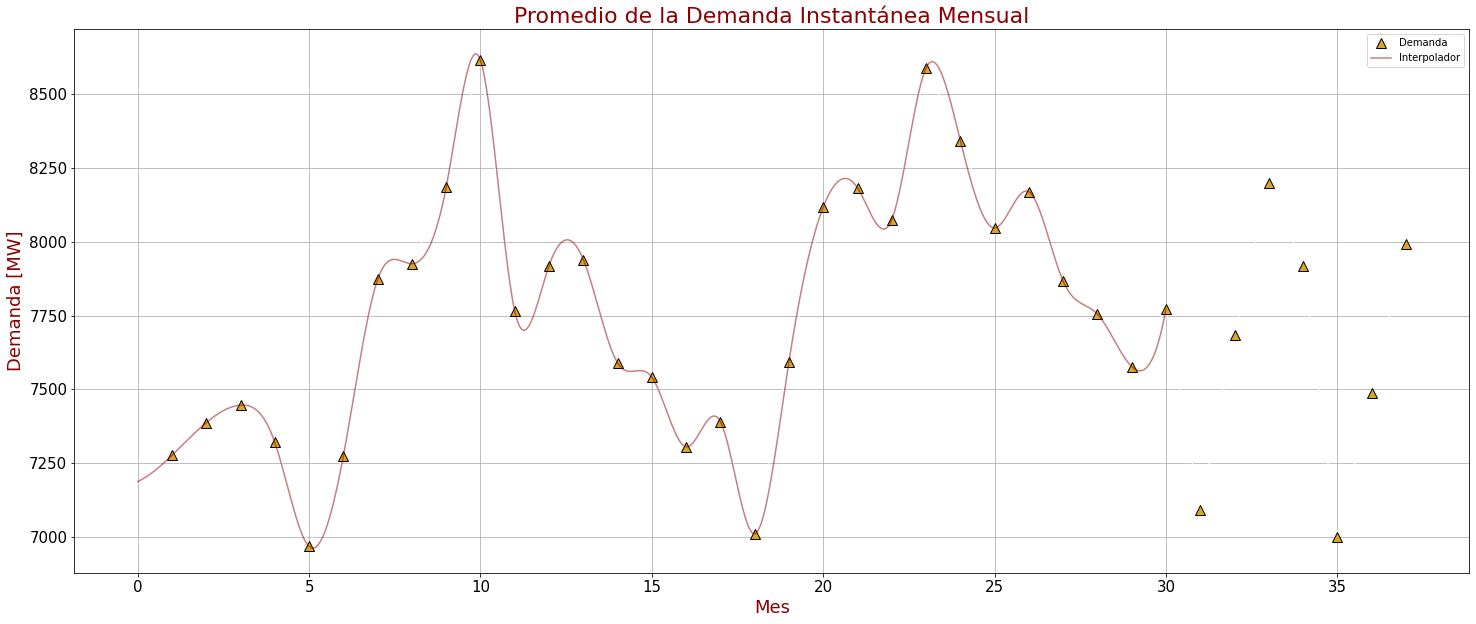

In [116]:
plt.figure(figsize=(25,10))
plt.plot(x_mes_l, prom_a_mes_l, color= 'white' ,
         marker = '^' , markersize = 10.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(x_eval_spline_mes_80_l, y_eval_spline_mes_80_l, color = 'darkred' , alpha = 0.5)
plt.title("Promedio de la Demanda Instantánea Mensual" , fontsize = 22 , color = 'darkred')
plt.xlabel("Mes" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Demanda","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
#plt.savefig('Demanda_mes_80_spline.png')
plt.show()

Pongamos a prueba

In [117]:
y_eval_spline_mes_80_100_l = spline_mes_80_l(x_eval_spline_mes_l)

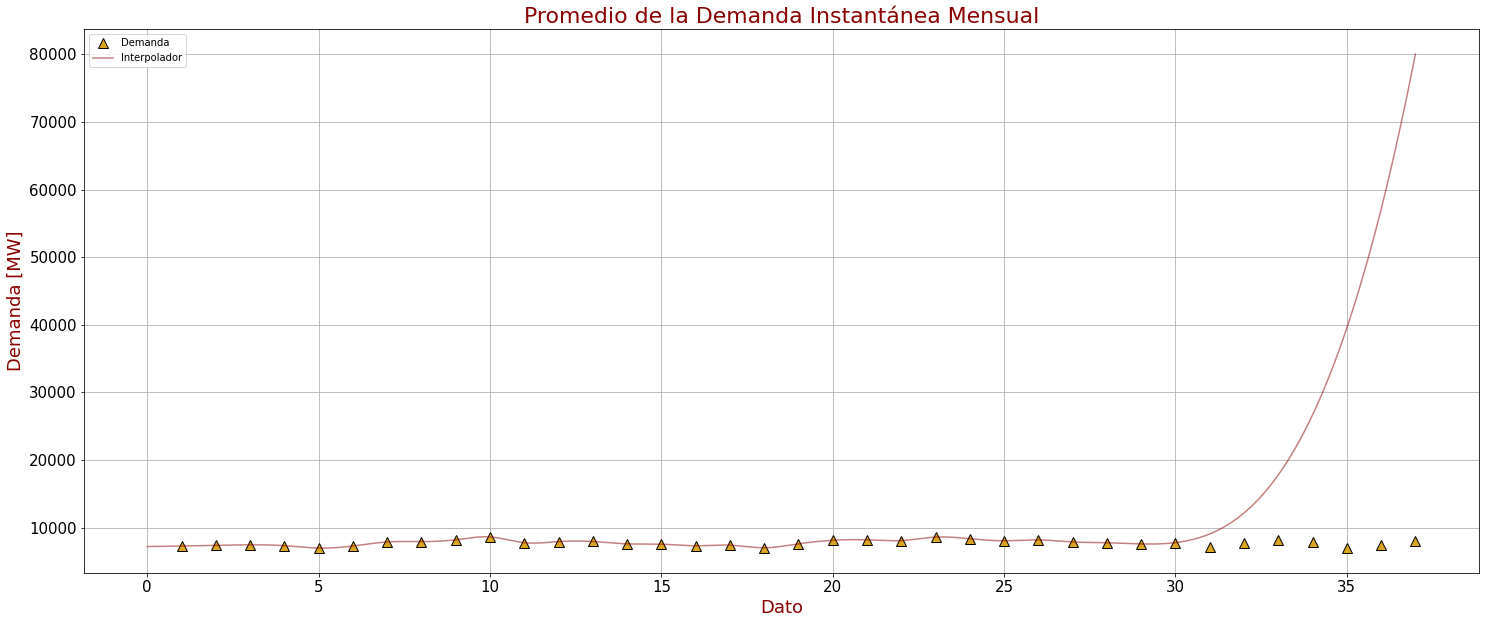

In [118]:
plt.figure(figsize=(25,10))
plt.plot(x_mes_l, prom_a_mes_l, color= 'white' ,
         marker = '^' , markersize = 10.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(x_eval_spline_mes_l, y_eval_spline_mes_80_100_l, color = 'darkred' , alpha = 0.5)
plt.title("Promedio de la Demanda Instantánea Mensual" , fontsize = 22 , color = 'darkred')
plt.xlabel("Dato" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Demanda","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Demanda_mes_80_100_spline.png')
plt.show()

Haciendo zoom al final de la gráfica:

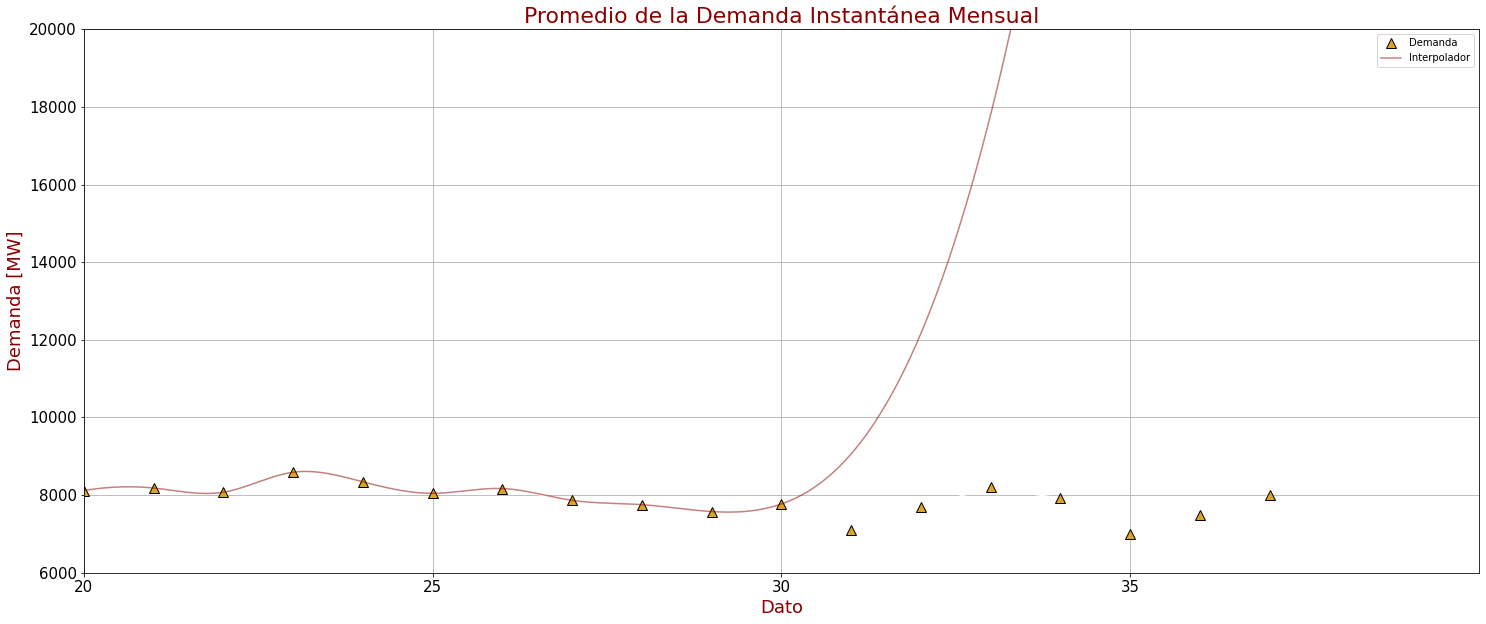

In [119]:
plt.figure(figsize=(25,10))
plt.plot(x_mes_l, prom_a_mes_l, color= 'white' ,
         marker = '^' , markersize = 10.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(x_eval_spline_mes_l, y_eval_spline_mes_80_100_l, color = 'darkred' , alpha = 0.5)
plt.title("Promedio de la Demanda Instantánea Mensual" , fontsize = 22 , color = 'darkred')
plt.xlabel("Dato" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Demanda","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.xlim(20, 40)
plt.ylim(6000, 20000)
plt.xticks(np.arange(20, 40, step=5))
plt.savefig('Demanda_mes_80_100_spline_zoom.png')
plt.show()

Podemos apreciar cómo el modelo por medio de splines cúbicos, aunque nos ayuda para interpolar en el rango establecido, debido a la oscilación de los datos, no ayuda para extrapolar datos e intentar hacer predicciones.

### **Demanda Integrada**

A diferencia de la demanda instantánea, aquí nos interesa la demanda integrada la cual representa la energía promedio de una hora.

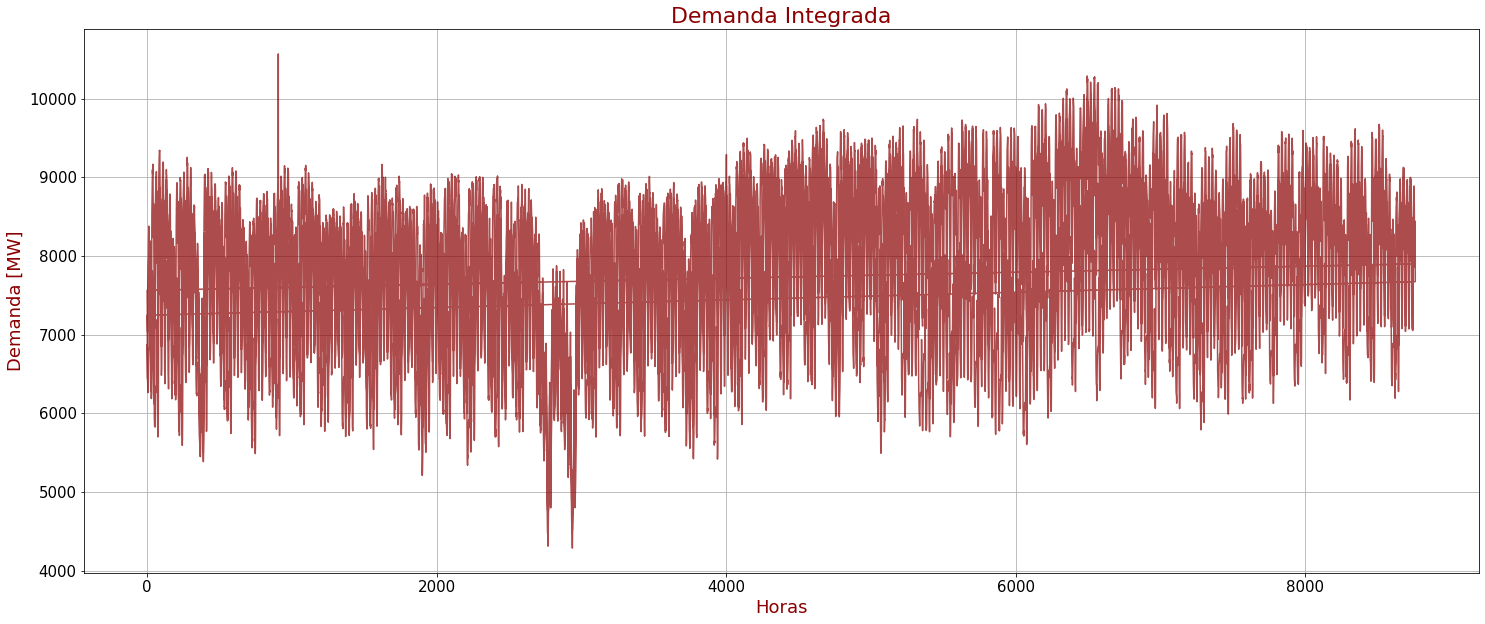

In [55]:
plt.figure(figsize=(25,10))
plt.plot(data_horas.muestras, data_horas.dema_int, 'b-', color = 'darkred' , alpha = 0.7)
plt.title("Demanda Integrada" , fontsize = 22 , color = 'darkred')
plt.xlabel("Horas" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Demanda_Integrada.png')
plt.show()

Como vemos, los datos presentan muchas oscilaciones, debido a ello, tomaremos los promedios por día, semanas y meses con el objetivo de observar si los datos se simplifican lo suficiente como para hallar un modelo simple que se ajuste a ellos.


#### **Demanda Integrada Promedio Díaria** 

De acuerdo a los datos del análisis descriptivo se cuentan con 25152 registros de horas, por ello, sacaremos los promedios de cada 24 registros consecutivos para obtener el promedio de la demanda diaría.

In [57]:
horas_tot = 25152 # Horas totales registradas
num_d_2 = int(horas_tot/24)
prom_dia_2 = []
for i in range(0,num_d_2):
    ini = 24*i
    end = 24*(1+i)
    data_i = data_horas[ini:end]
    prom_dia_2.append(data_i["dema_int"].mean())

In [58]:
prom_a_dia_2 = np.array(prom_dia_2)
x_dia_2 = np.array(list(range(1,len(prom_dia_2)+1)))

In [59]:
mpoints = len(prom_dia_2)
x_dia_grph_1_2 = np.linspace(min(x_dia_2) , max(x_dia_2) , mpoints)
y_dia_grph_1_2 = np.array(prom_dia_2)

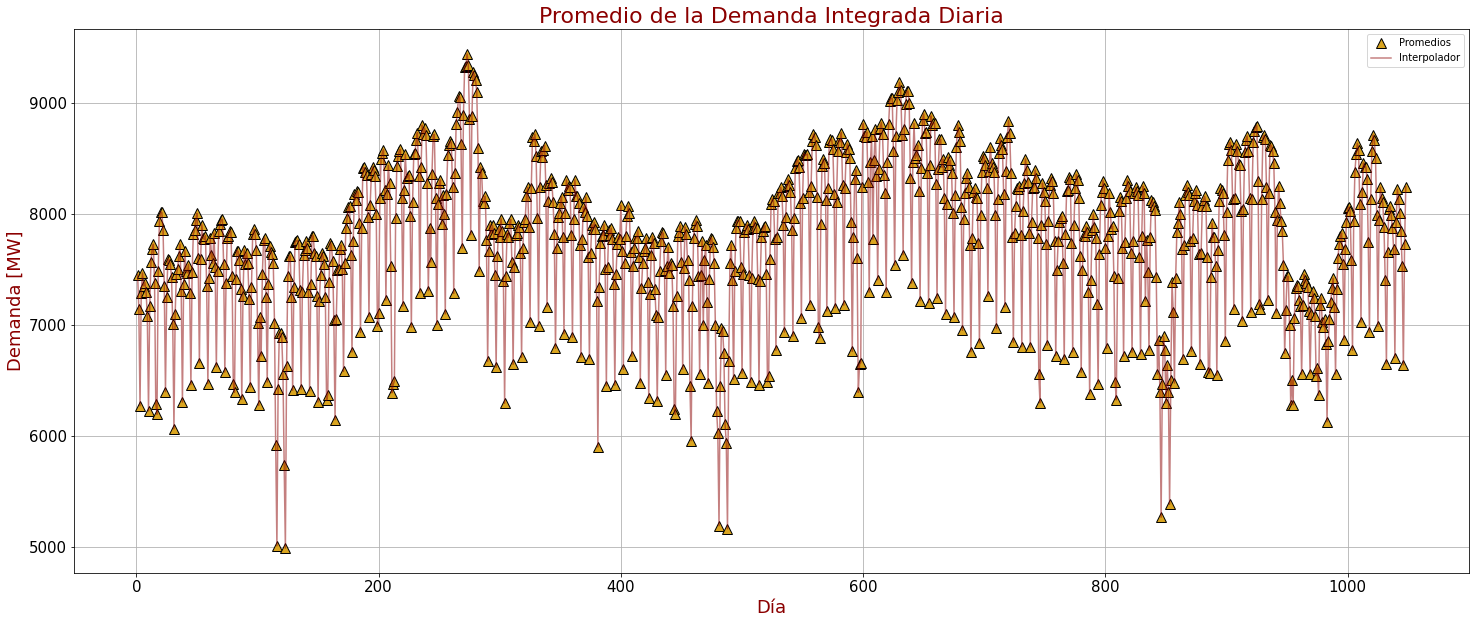

In [60]:
plt.figure(figsize=(25,10))
plt.plot(x_dia_2 , prom_a_dia_2 , color= 'white' ,
         marker = '^' , markersize = 10.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(x_dia_grph_1_2 , y_dia_grph_1_2 , color = 'darkred' , alpha = 0.5)
plt.title("Promedio de la Demanda Integrada Diaria" , fontsize = 22 , color = 'darkred')
plt.xlabel("Día" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Promedios","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Promedio_Demanda_Integrada_Dia.png')
plt.show()

### **Interpolador Demanda Instantánea**

#### **Interpolador Para la Demanda Instantánea Diaria**

La función *polyfit()* sólo acepta hasta un número máximo para el grado del polinomio para interpolar, debido a ello, tomaremos una muestra cada cinco días de los promedios diarios del $80\%$ de los datos para hacer el interpolador con un polinomio de grado 140, siendo este número el máximo número que acepta para el grado del interpolador.

In [61]:
n_m = []
x = []
k = 0
n_puntos = 100 # Solo submúltiplos de 800, que representan el 76% de los datos
for i in range(n_puntos):
    n_m.append(k)
    x.append(k)
    k = int(k+(800/n_puntos))

y = []
for i in range(len(x)):
    y.append(prom_dia_2[n_m[i]])

coef_aj = np.polyfit(x, y, len(x))

neval = 100
xeval = np.linspace(min(x), max(x), neval)
yeval = np.polyval(coef_aj,xeval)

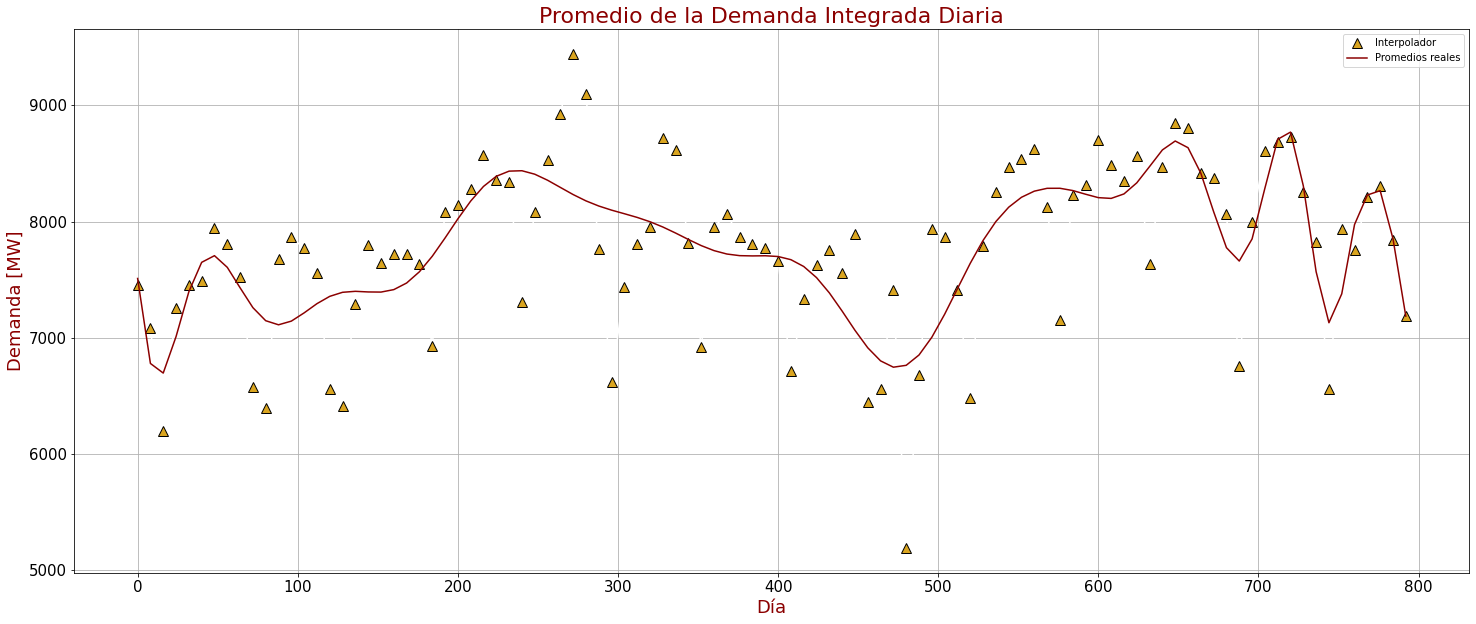

In [62]:
plt.figure(figsize=(25,10))
plt.plot(x , y , 'k-', color = 'white',
         marker = '^' , markersize = 10.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(xeval, yeval, 'b-', color = 'darkred')     
plt.title("Promedio de la Demanda Integrada Diaria" , fontsize = 22 , color = 'darkred')
plt.xlabel("Día" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Interpolador","Promedios reales","Muestras"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Promedio_Demanda_Integrada_Dia_Inter.png')
plt.show()

Lo que resta ahora es poner a prueba este modelo con el resto de los datos con el objetivo de observar si este los describe

In [70]:
mpoints = len(prom_dia_2) + 1
x_dia_grph_2 = np.linspace(min(x_dia_2) , max(x_dia_2) , mpoints)
y_dia_grph_2 = np.polyval(coef_aj , x_dia_grph_2)

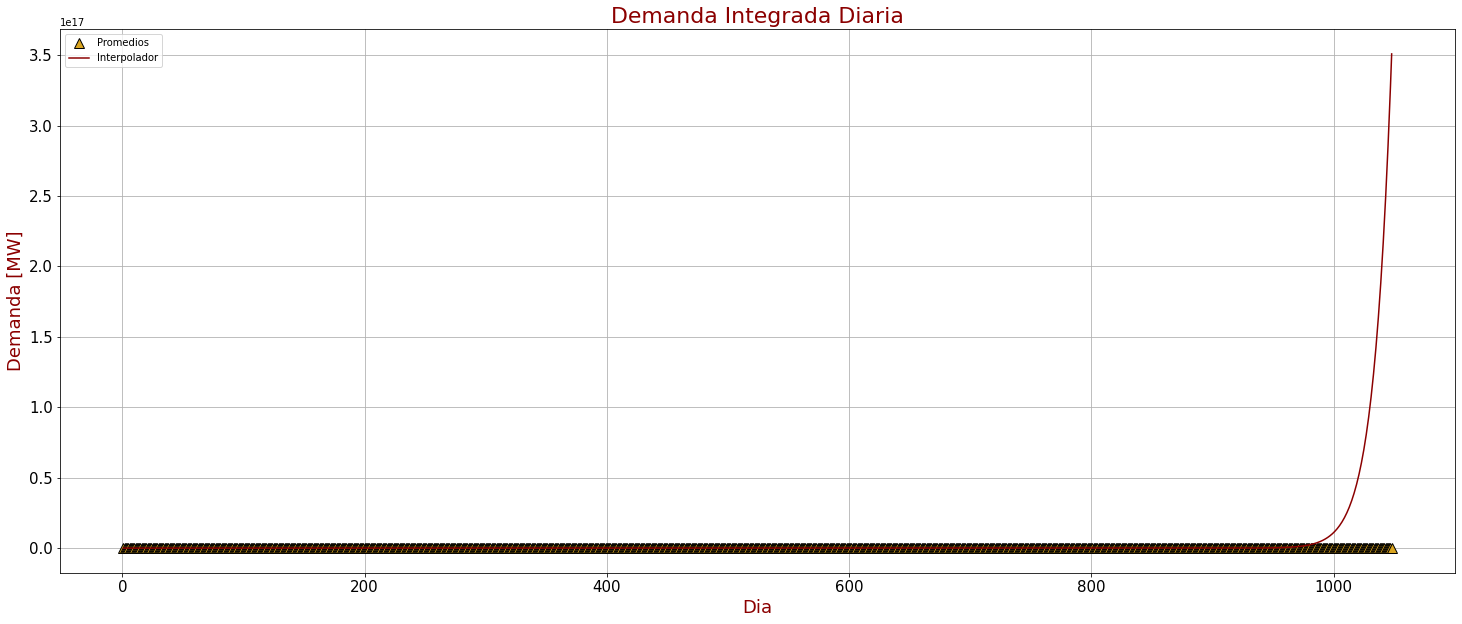

In [71]:
plt.figure(figsize=(25,10))
plt.plot(x_dia , prom_dia , color= 'white' ,
         marker = '^' , markersize = 10.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(x_dia_grph_2 , y_dia_grph_2 , color = 'darkred')
plt.title("Demanda Integrada Diaria" , fontsize = 22 , color = 'darkred')
plt.xlabel("Dia" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Promedios","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Promedio_Demanda_Integrada_Dia_Inter_2.png')
plt.show()

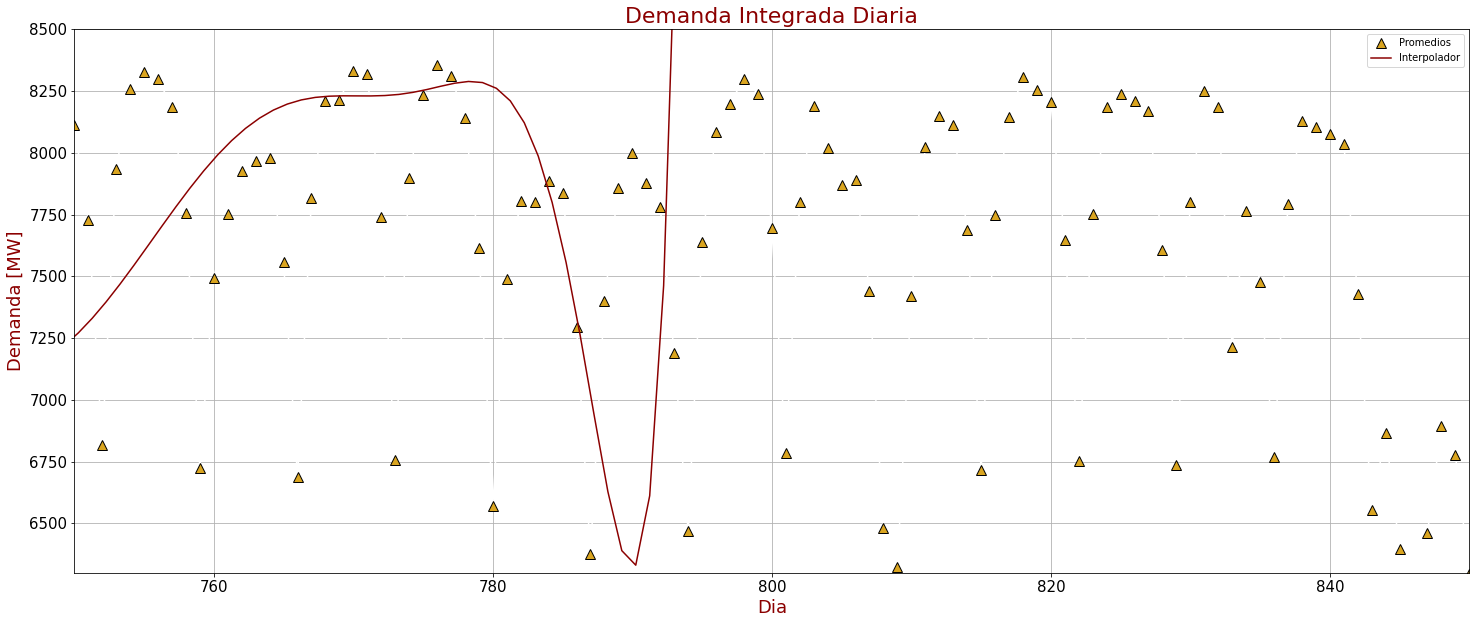

In [72]:
plt.figure(figsize=(25,10))
plt.plot(x_dia , prom_dia , color= 'white' ,
         marker = '^' , markersize = 10.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(x_dia_grph_2 , y_dia_grph_2 , color = 'darkred')
plt.title("Demanda Integrada Diaria" , fontsize = 22 , color = 'darkred')
plt.xlabel("Dia" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Promedios","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlim(750,850)
plt.ylim(6300,8500)
plt.grid(True)
plt.savefig('Promedio_Demanda_Integrada_Dia_Inter_3.png')
plt.show()

Tal como se ve la primera gráfica con el conjunto de prueba, nuestro modelo diverge y no puede describir ese conjunto de puntos por lo que se determina que en este caso el interpolador no es un modelo adecuado para este problema.

#### **Interpolador Para la Demanda Integrada Semanal**

Ahora por semana, indistitanmente de a qué mes pertenezca, los días restantes se promediarán y se contarán como otra semana como se verá más adelante.

De acuerdo a las pruebas hechas nos damos cuenta que el límite del grado del polinomio que acepta, en este caso, polyfit, es 141. Sin embargo, para poner a prueba nuestro modelo, sólo necesitaremos el $80\%$ de los datos y el otro $20\%$ para hacer el test gráfico del modelo

In [76]:
data_dia = pd.DataFrame(prom_dia_2, columns = ['Promedio'])
dia = pd.DataFrame(x_dia_2, columns = ['Dia']) 
data_dia['Dia'] = dia['Dia']

num_s = int(len(data_dia)/7)
prom_sem = []
for i in range(0,num_s):
    ini = 7*i
    end = 7*(1+i)
    data_i = data_dia[ini:end]
    prom_sem.append(data_i["Promedio"].mean())

In [77]:
prom_sem.append(data_dia[num_s*7: num_s*7 + 6]["Promedio"].mean())
prom_a_sem = np.array(prom_sem)
x_sem = np.array(list(range(1,len(prom_sem)+1)))

Mostremos los últimos cinco datos de los promedios semanales

In [78]:
data_sem = pd.DataFrame(prom_sem, columns = ['Promedio']) 
sem = pd.DataFrame(x_sem, columns = ['Semana']) 
data_sem['Semana'] = sem['Semana']
data_sem.tail(5)

Promedio  Semana
145  8153.383904     146
146  7986.661687     147
147  7670.239603     148
148  7793.250106     149
149  7597.501642     150

Si contamos los seis días restantes como otras semana se tiene 150 semanas en total donde el $80\%$ de ellas son 120 y el número más pequeño y cercano que sea múltiplo de siete es 119. Entonces, obtengamos los arrays y dataframe con estos datos

In [79]:
num_s_i = 120
prom_sem_i = []
for i in range(0,num_s_i):
    ini = 7*i
    end = 7*(1+i)
    data_i = data_dia[ini:end]
    prom_sem_i.append(data_i["Promedio"].mean())

In [80]:
prom_a_sem_i = np.array(prom_sem_i)
x_sem_i = np.array(list(range(1,len(prom_sem_i)+1)))

data_sem_i = pd.DataFrame(prom_sem_i, columns = ['Promedio']) 
sem_i = pd.DataFrame(x_sem_i, columns = ['Semana']) 
data_sem_i['Semana'] = sem_i['Semana']
data_sem_i.tail(5)

Promedio  Semana
115  7389.288811     116
116  7853.069152     117
117  7855.596635     118
118  7709.245598     119
119  7729.280683     120

Obtengamos ahora el interpolador para el conjunto de 130 registros o conjunto de entrenamiento

In [81]:
d_sem = len(prom_sem_i) - 1
inter_sem = np.polyfit(x_sem_i , prom_a_sem_i , d_sem)

De esta manera, podemos graficarlo sobre los registros del *dataset*

In [82]:
mpoints = len(prom_sem_i) + 1
x_sem_grph_1 = np.linspace(min(x_sem_i) , max(x_sem_i) , mpoints)
y_sem_grph_1 = np.polyval(inter_sem , x_sem_grph_1)

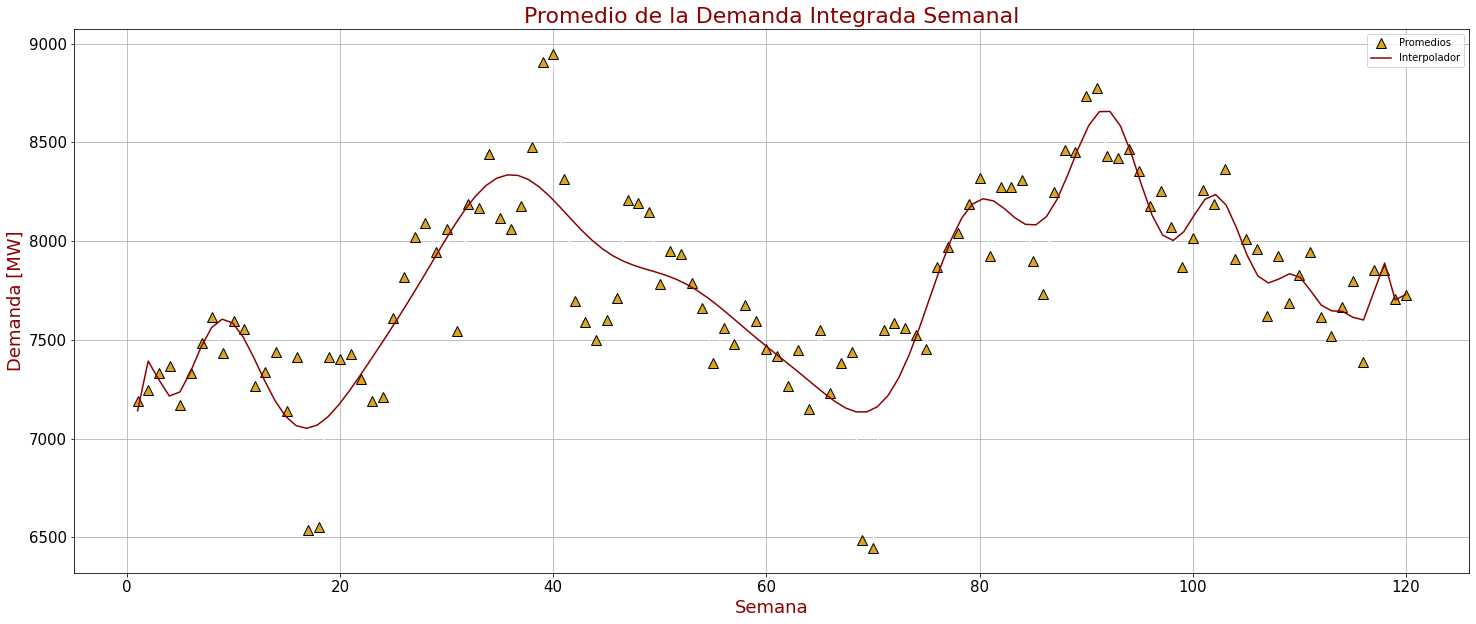

In [83]:
plt.figure(figsize=(25,10))
plt.plot(x_sem_i , prom_sem_i , color= 'white' ,
         marker = '^' , markersize = 10.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(x_sem_grph_1 , y_sem_grph_1 , color = 'darkred')
plt.title("Promedio de la Demanda Integrada Semanal" , fontsize = 22 , color = 'darkred')
plt.xlabel("Semana" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Promedios","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Promedio_Demanda_Integrada_Semana_Inter_1.png')
plt.show()

Finalmente graficaremos el interpolador junto con el conjunto de test para ver que tan fiable es el modelo obtenido

In [84]:
mpoints = len(prom_sem) + 1
x_sem_grph_2 = np.linspace(min(x_sem) , max(x_sem) , mpoints)
y_sem_grph_2 = np.polyval(inter_sem , x_sem_grph_2)

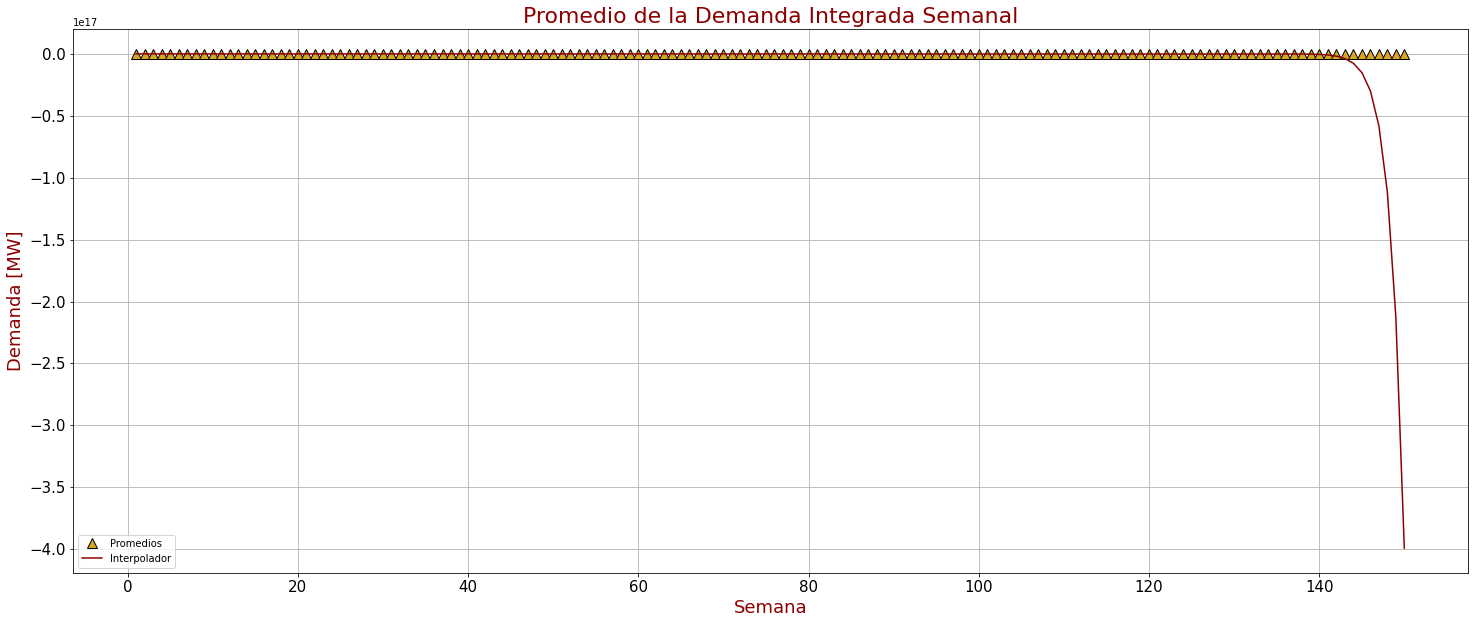

In [85]:
plt.figure(figsize=(25,10))
plt.plot(x_sem , prom_sem , color= 'white' ,
         marker = '^' , markersize = 10.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(x_sem_grph_2 , y_sem_grph_2 , color = 'darkred')
plt.title("Promedio de la Demanda Integrada Semanal" , fontsize = 22 , color = 'darkred')
plt.xlabel("Semana" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Promedios","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Promedio_Demanda_Integrada_Semana_Inter_2.png')
plt.show()

Hagamos un acercamiento en donde diverge el interpolador con los demás puntos

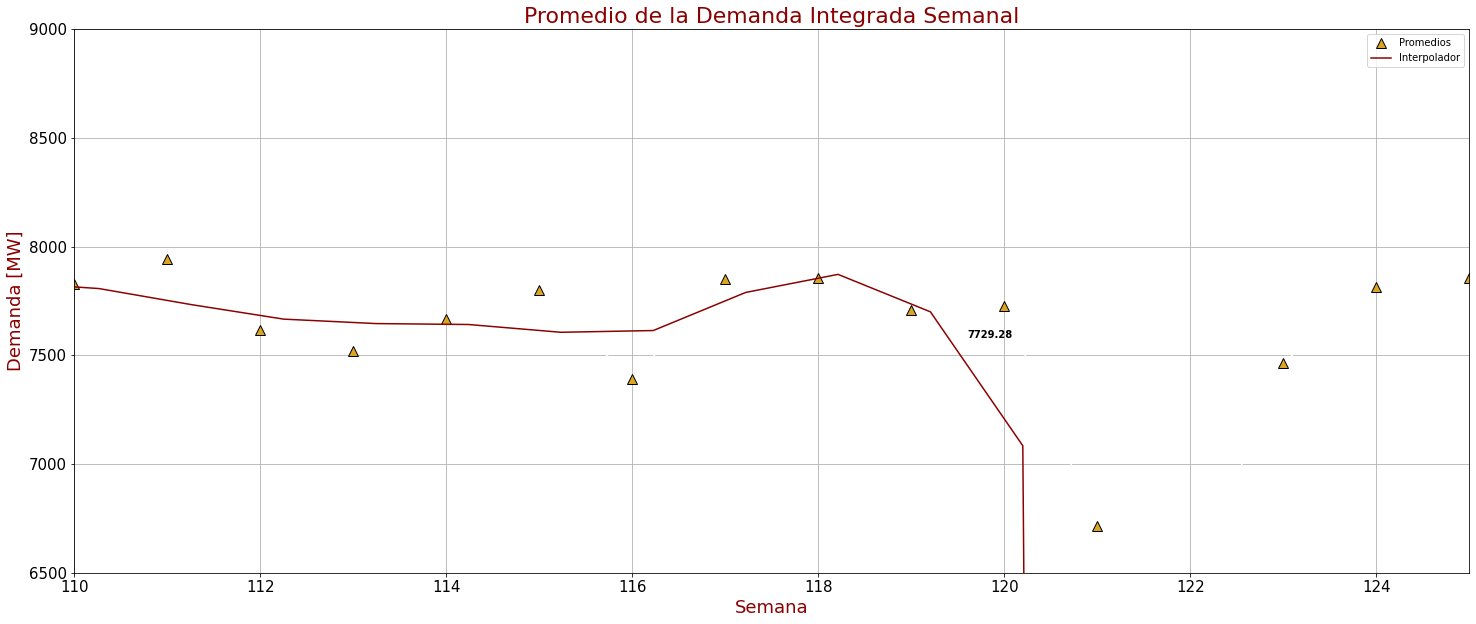

In [87]:
plt.figure(figsize=(25,10))
plt.plot(x_sem , prom_sem , color= 'white' ,
         marker = '^' , markersize = 10.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(x_sem_grph_2 , y_sem_grph_2 , color = 'darkred')
plt.text(119.6, data_sem_i.iat[119,0] -150 , str(7729.28) , horizontalalignment = 'left' , fontweight = "bold")
plt.title("Promedio de la Demanda Integrada Semanal" , fontsize = 22 , color = 'darkred')
plt.xlabel("Semana" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Promedios","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlim([110, 125]) 
plt.ylim([6500,9000]) 
plt.grid(True)
plt.savefig('Promedio_Demanda_Integrada_Semana_Inter_3.png')
plt.show()

**Errores:**

Tal como se hizó para la demanda diaria, en esta parte obtendremos los errores cuadráticos medios de nuestro modelos.

In [88]:
prom_sem_obj_80 = prom_a_sem_i
x_sem_80 = x_sem_i
prom_sem_80 = inter_sem
ecm_sem = MSE(prom_sem_obj_80 , prom_sem_80)
print(ecm_sem)

60048346.82587992


Vemos que incluso los errores cuadráticos medios osn muy grandes incluso respecto al conjunto de entrnamiento.

#### **Interpolador Para la Demanda Integrada Mensual**

Se repetirá el procedimiento anterior para los promedios mensuales, donde habrá dos semanas que sobrarán ya que no completan el mes de Febrero del 2020.

In [89]:
num_m = int(len(prom_sem)/4)
prom_mes = []
for i in range(0,num_m):
    ini = 4*i
    end = 4*(1+i)
    data_i = data_sem[ini:end]
    prom_mes.append(data_i["Promedio"].mean())

In [90]:
prom_mes.append(data_sem[148:150]["Promedio"].mean())
prom_a_mes = np.array(prom_mes)
x_mes = np.array(list(range(1,39)))

data_mes = pd.DataFrame(prom_mes, columns = ['Promedio']) 
mes = pd.DataFrame(x_mes, columns = ['Mes']) 
data_mes['Mes'] = mes['Mes']
data_mes.tail(5)

Promedio  Mes
33  7930.781457   34
34  7008.239335   35
35  7495.371733   36
36  7995.248408   37
37  7695.375874   38

Para el conjunto de prueba tomemos hasta el mes 32 ya que sería el números de meses más aproximados al $\%80$ del conjunto total de los promedios mensuales

In [91]:
num_m_i = 32
prom_mes_i = []
for i in range(0,num_m_i):
    ini = i
    end = 1+i
    data_i = data_mes[ini:end]
    prom_mes_i.append(data_i["Promedio"].mean())
    
prom_a_mes_i = np.array(prom_mes_i)
x_mes_i = np.array(list(range(1,len(prom_mes_i)+1)))

In [92]:
data_mes_i = pd.DataFrame(prom_mes_i, columns = ['Promedio']) 
mes_i = pd.DataFrame(x_mes_i, columns = ['Mes']) 
data_mes_i['Semana'] = mes_i['Mes']
data_mes_i.tail(5)

Promedio  Semana
27  7768.414521      28
28  7593.689082      29
29  7786.798017      30
30  7102.596886      31
31  7694.116694      32

Con esto, ya podemos construir nuestro interpolador

In [93]:
d_mes = len(prom_a_mes_i) - 1
d_mes = len(prom_mes_i) - 1
inter_mes = np.polyfit(x_mes_i , prom_a_mes_i , d_mes)

In [94]:
mpoints = len(prom_sem_i) + 1
x_mes_grph_1 = np.linspace(min(x_mes_i) , max(x_mes_i) , mpoints)
y_mes_grph_1 = np.polyval(inter_mes , x_mes_grph_1)

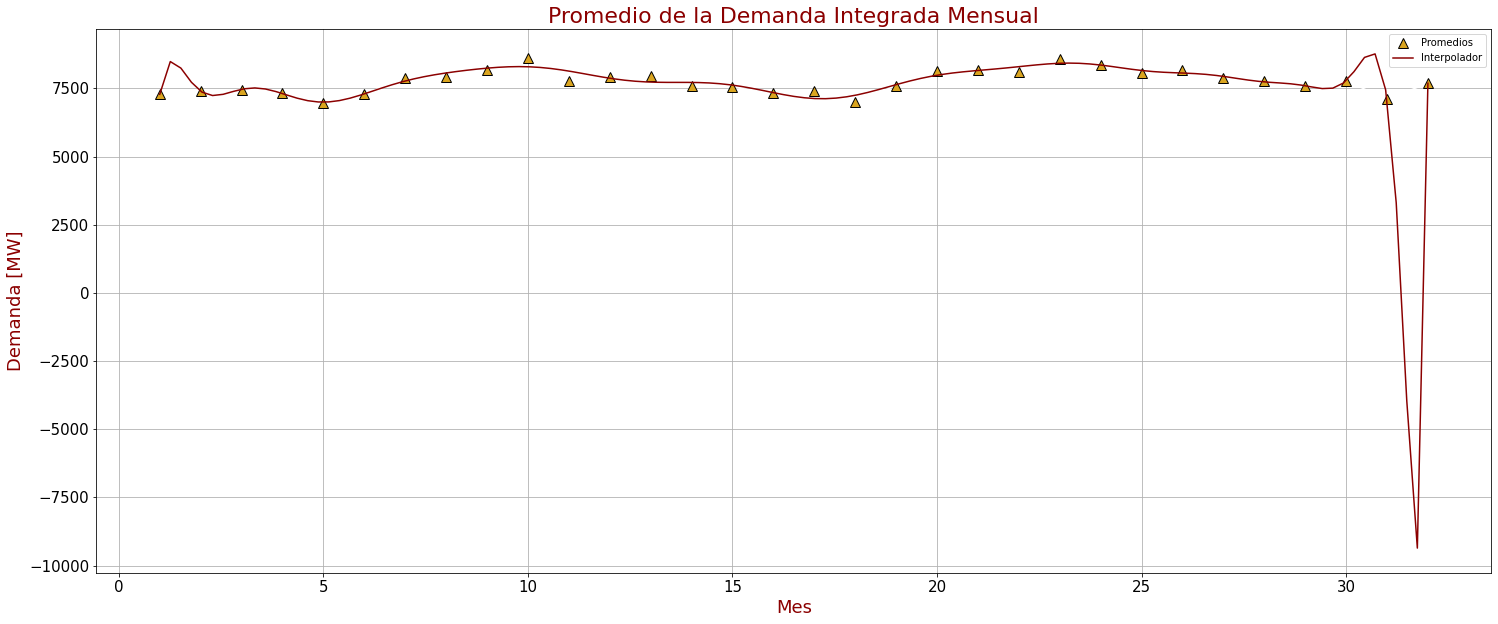

In [95]:
plt.figure(figsize=(25,10))
plt.plot(x_mes_i , prom_mes_i , color= 'white' ,
         marker = '^' , markersize = 10.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(x_mes_grph_1 , y_mes_grph_1 , color = 'darkred')
plt.title("Promedio de la Demanda Integrada Mensual" , fontsize = 22 , color = 'darkred')
plt.xlabel("Mes" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Promedios","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Promedio_Demanda_Integrada_Mes_Inter_1.png')
plt.show()

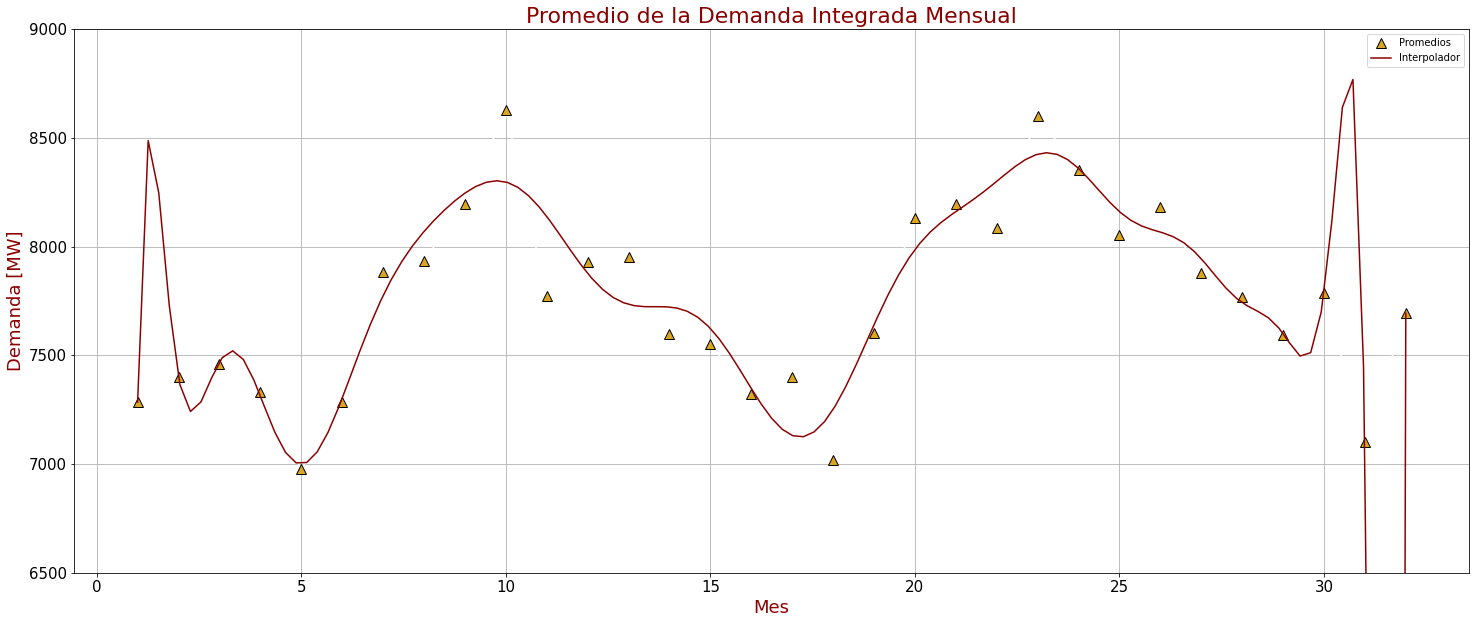

In [96]:
plt.figure(figsize=(25,10))
plt.plot(x_mes_i , prom_mes_i , color= 'white' ,
         marker = '^' , markersize = 10.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(x_mes_grph_1 , y_mes_grph_1 , color = 'darkred')
plt.title("Promedio de la Demanda Integrada Mensual" , fontsize = 22 , color = 'darkred')
plt.xlabel("Mes" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Promedios","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.ylim([6500,9000]) 
plt.grid(True)
plt.savefig('Promedio_Demanda_Integrada_Inter_Mes_2.png')
plt.show()

Análogamente al caso anterior, veamos si este modelo se acerca a los promedio de los meses restantes

In [97]:
mpoints = len(prom_mes) + 1
x_mes_grph_2 = np.linspace(min(x_mes) , max(x_mes) , mpoints)
y_mes_grph_2 = np.polyval(inter_mes , x_mes_grph_2)

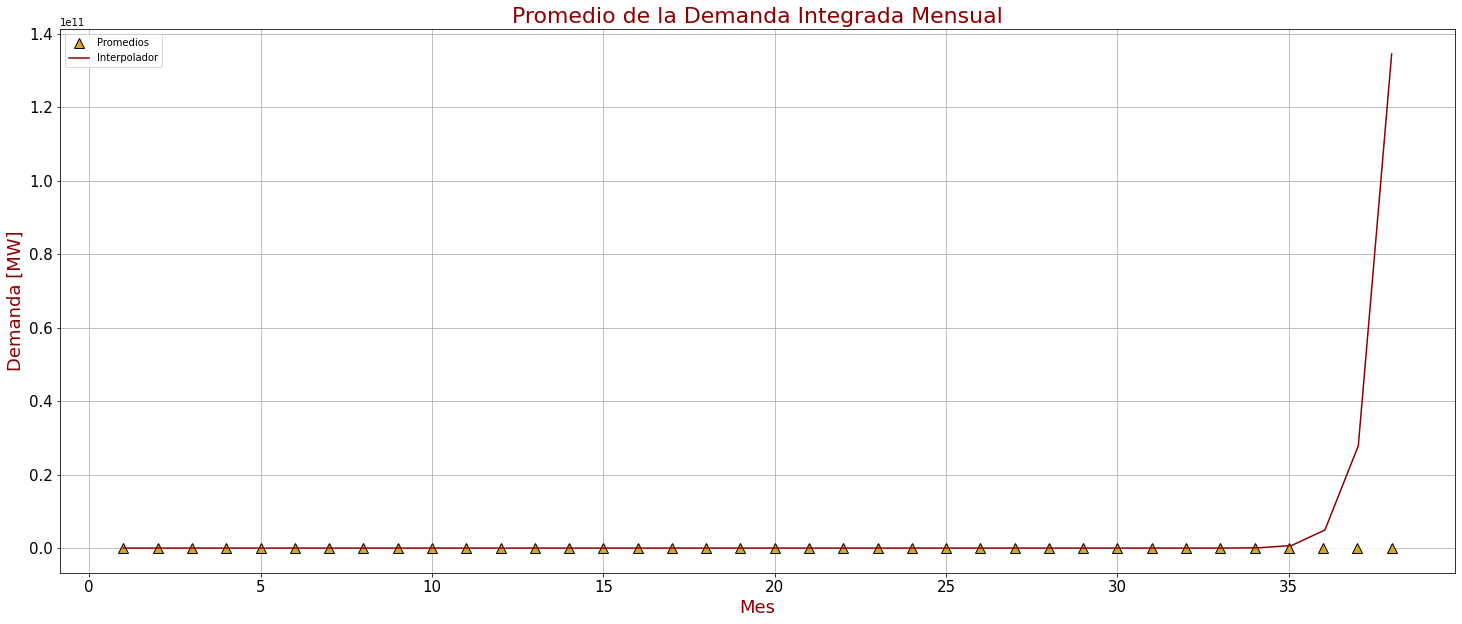

In [98]:
plt.figure(figsize=(25,10))
plt.plot(x_mes , prom_mes , color= 'white' ,
         marker = '^' , markersize = 10.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(x_mes_grph_2 , y_mes_grph_2 , color = 'darkred')
plt.title("Promedio de la Demanda Integrada Mensual" , fontsize = 22 , color = 'darkred')
plt.xlabel("Mes" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Promedios","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Promedio_Demanda_Integrada_Mes_Inter_3.png')
plt.show()

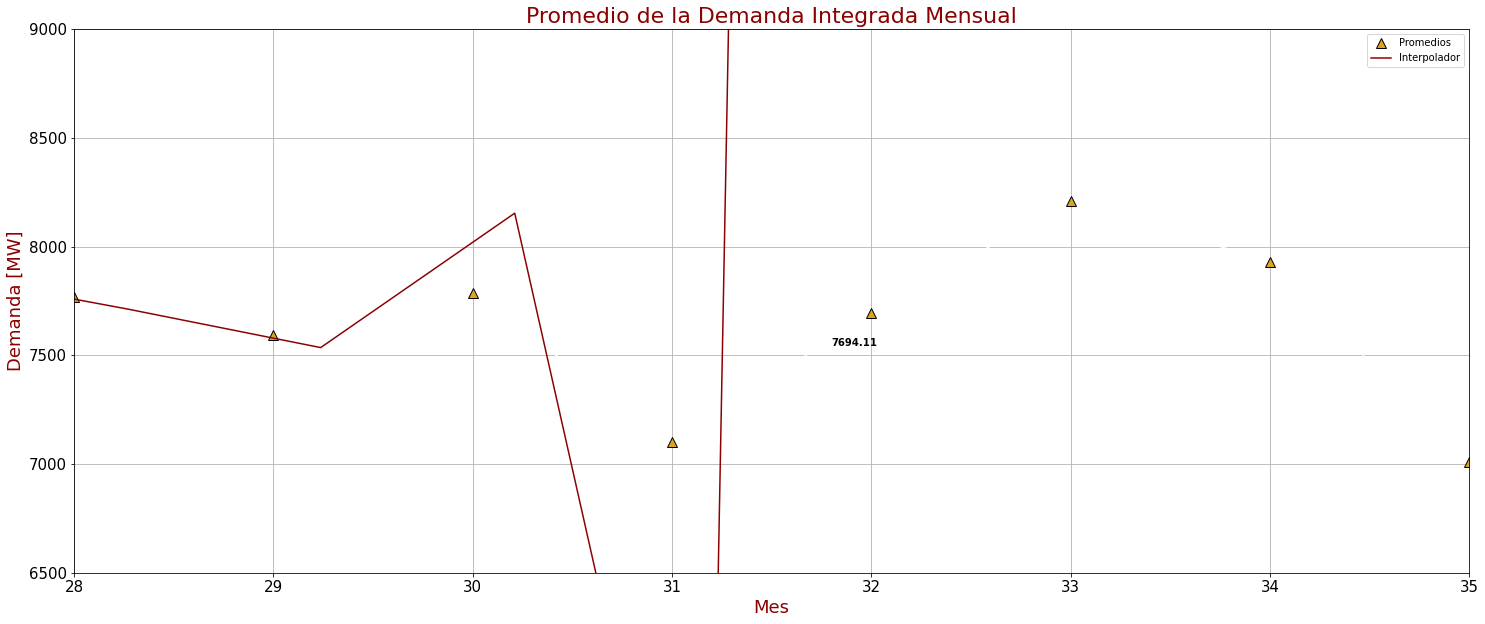

In [100]:
plt.figure(figsize=(25,10))
plt.plot(x_mes , prom_mes , color= 'white' ,
         marker = '^' , markersize = 10.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(x_mes_grph_2 , y_mes_grph_2 , color = 'darkred')
plt.text(31.8 , data_mes_i.iat[31,0] -150 , str(7694.11) , horizontalalignment = 'left' , fontweight = "bold")
plt.title("Promedio de la Demanda Integrada Mensual" , fontsize = 22 , color = 'darkred')
plt.xlabel("Mes" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Promedios","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.xlim([28, 35]) 
plt.ylim([6500,9000]) 
plt.grid(True)
plt.savefig('Promedio_Demanda_Integrada_Mes_Inter_4.png')
plt.show()

Se observa que el interpolador no es un buen modelo para el caso semanal ni mensual puesto que no sé acerca a los valores de su conjunto de test, respectivamente.

**Errores:**

Análogamente al caso semanal

In [101]:
prom_mes_obj_80 = prom_a_mes_i
prom_mes_80 = inter_mes
ecm_mes = MSE(prom_mes_obj_80 , prom_mes_80)
print(ecm_mes)

8977674858.347164


Vemos que incluso, en comparación con los promedios semanales, los errores para el caso mensual son incluso mayores.

### **Promedio de Consumo en Verano**

El sistema que toma los datos a lo largo de una hora toma como promeio tomando el máximo yy mínimo dato regustrado para después dividirlos entre dos veces los segundos en la hora. Sin embargo, contrastaremos este métodos con los vistos en clase para integrar.

La gráfica de los valores tomados durante una hora en Verano es la siguiente

In [61]:
hora = pd.read_csv("Muestra_1h.csv")

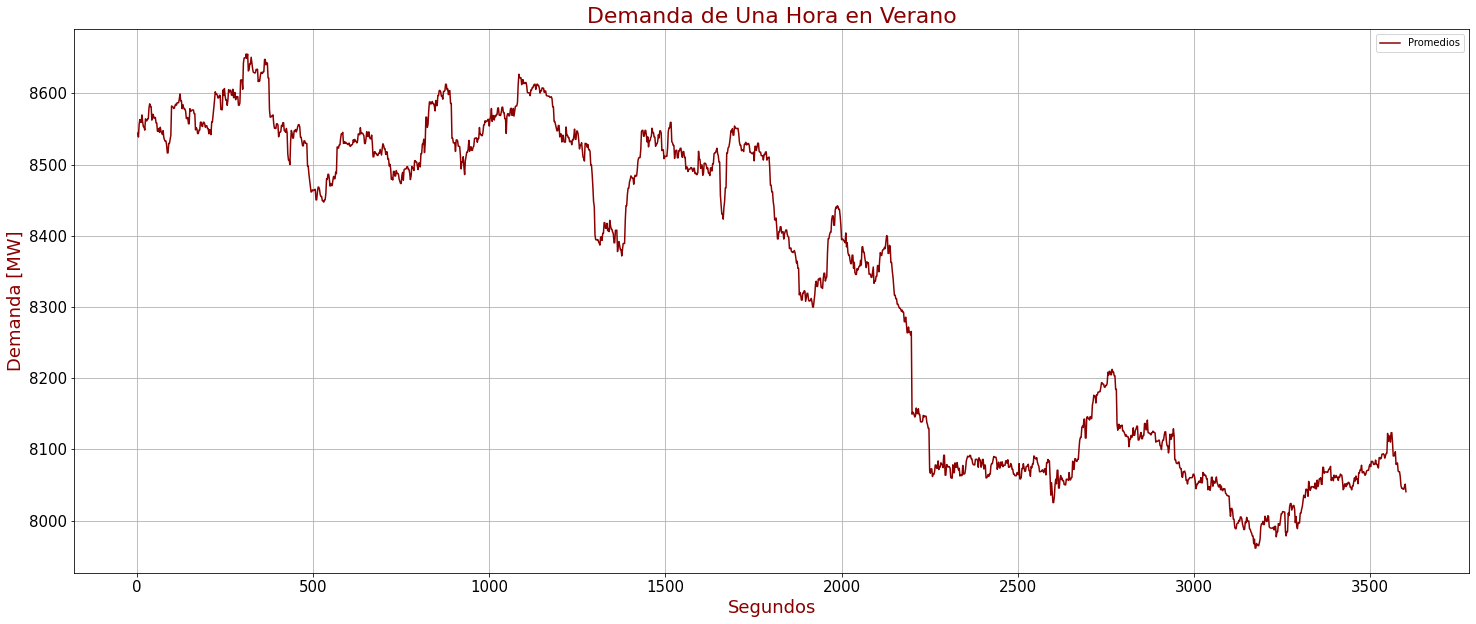

In [151]:
plt.figure(figsize=(25,10))
plt.plot(hora.seg, hora.dem, color = 'darkred')
plt.title("Demanda de Una Hora en Verano" , fontsize = 22 , color = 'darkred')
plt.xlabel("Segundos" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Promedios","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Verano_h_1.png')
plt.show()

Veamos que una recta no es la mejor idea para ajustar esta curva

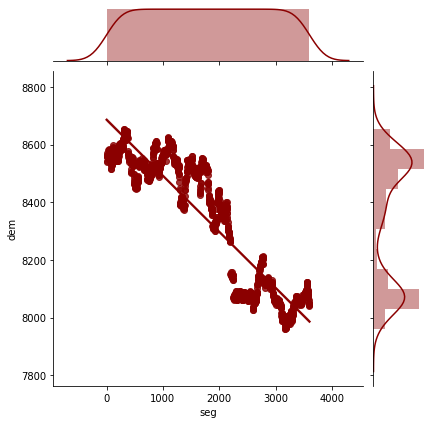

In [66]:
hora_reg = sns.jointplot(data = hora , x = 'seg' , y = 'dem' , kind = 'reg' , color = 'darkred')

Probaremos con polinomio de grado dos hasta ocho con el objetivo de ver cuál obtiene una mayor área

+ **Polinomio grado dos**

In [152]:
n_m = []
x = []
k = 0
n_puntos = 2 # Solo submúltiplos de 1,800
for i in range(n_puntos):
    n_m.append(k)
    x.append(k*2)
    k = k+(1800/n_puntos)

y = []
for i in range(len(x)):
    y.append(hora.dem[n_m[i]])

x.append(3598)
y.append(hora.orden[1799])

coef_aj = np.polyfit(x, y, len(x)-1)

neval = 100
xeval = np.linspace(min(x), max(x), neval)
yeval = np.polyval(coef_aj,xeval)

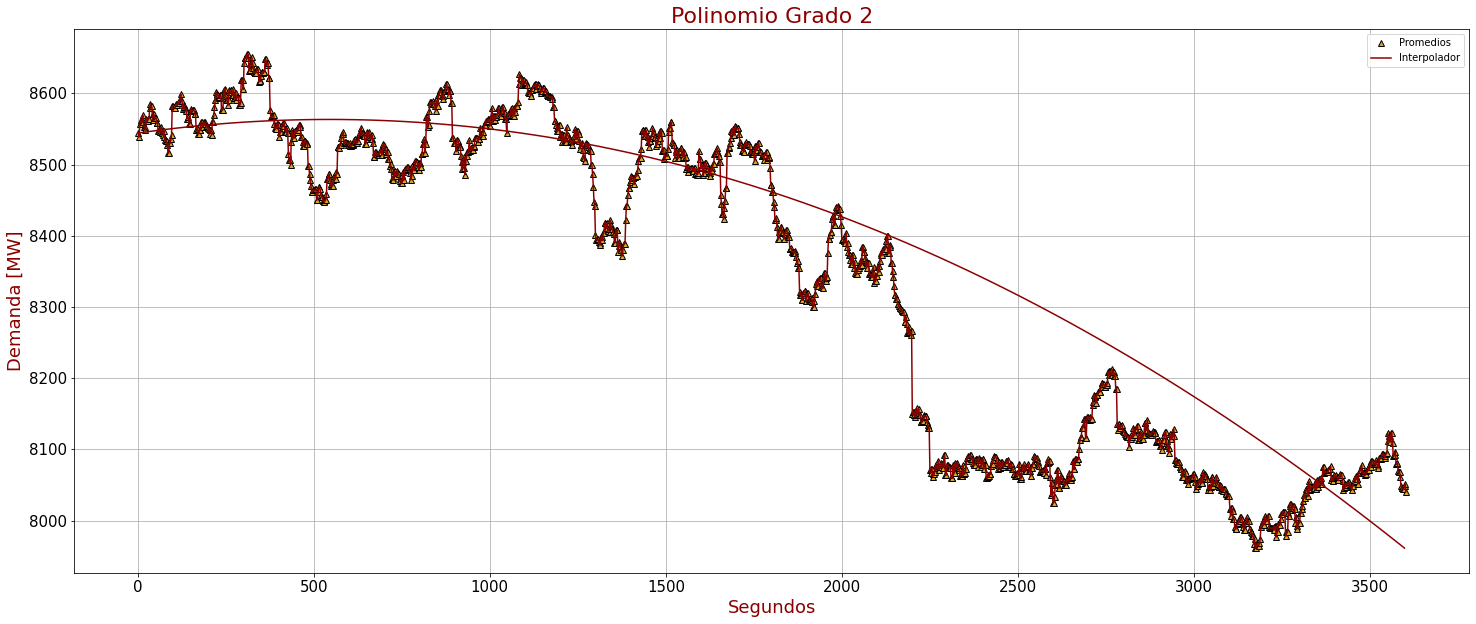

In [155]:
plt.figure(figsize=(25,10))
plt.plot(hora.seg, hora.dem, color= 'white' ,
         marker = '^' , markersize = 6.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(xeval, yeval, color = 'darkred')
plt.plot(hora.seg, hora.dem, color = 'darkred')
plt.title("Polinomio Grado 2" , fontsize = 22 , color = 'darkred')
plt.xlabel("Segundos" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Promedios","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Verano_h_2.png')
plt.show()

Cuyo valor para la integral es el siguiente

In [ ]:
f_2 = lambda x: coef_aj[0]

In [ ]:
Tcf(f,0,3600,10000)

+ **Polinomio grado tres**

In [156]:
n_m = []
x = []
k = 0
n_puntos = 3 # Solo submúltiplos de 1,800
for i in range(n_puntos):
    n_m.append(k)
    x.append(k*2)
    k = k+(1800/n_puntos)

y = []
for i in range(len(x)):
    y.append(hora.dem[n_m[i]])

x.append(3598)
y.append(hora.orden[1799])

coef_aj = np.polyfit(x, y, len(x)-1)

neval = 100
xeval = np.linspace(min(x), max(x), neval)
yeval = np.polyval(coef_aj,xeval)

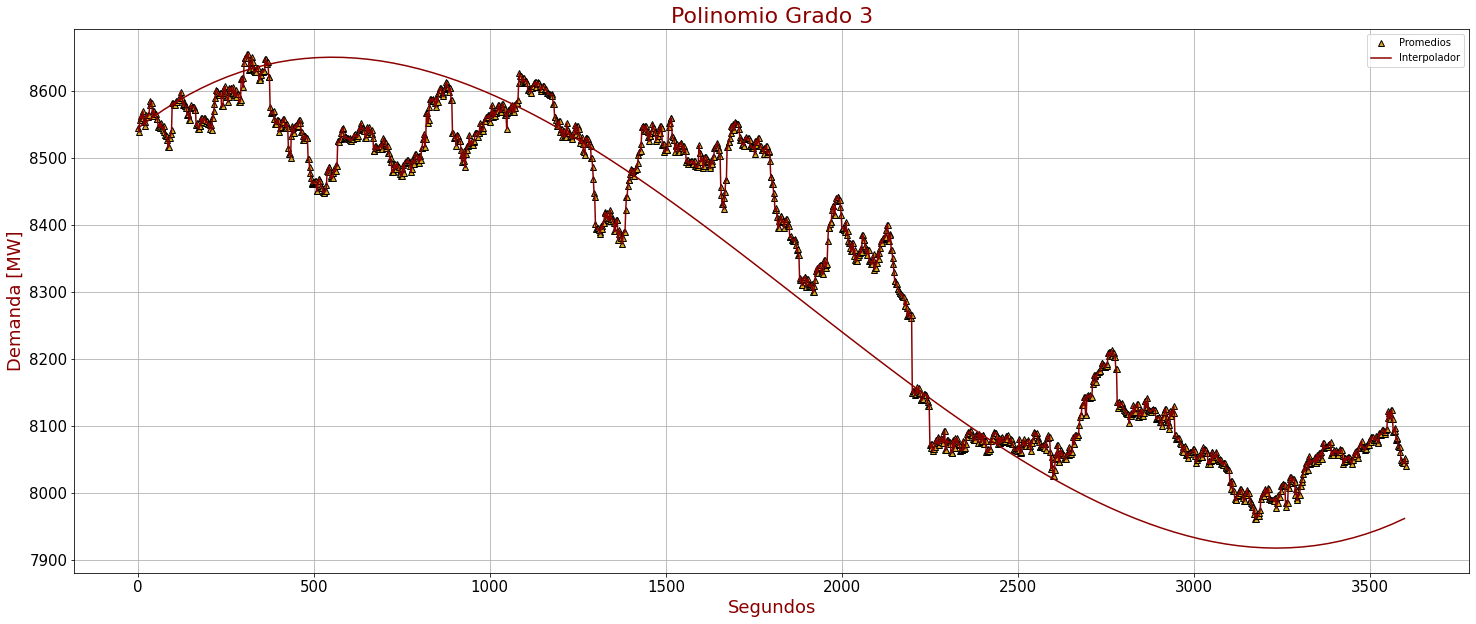

In [157]:
plt.figure(figsize=(25,10))
plt.plot(hora.seg, hora.dem, color= 'white' ,
         marker = '^' , markersize = 6.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(xeval, yeval, color = 'darkred')
plt.plot(hora.seg, hora.dem, color = 'darkred')
plt.title("Polinomio Grado 3" , fontsize = 22 , color = 'darkred')
plt.xlabel("Segundos" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Promedios","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Verano_h_3.png')
plt.show()

In [ ]:
a = coef_aj[0]
b = coef_aj[1]
c = coef_aj[2]
d = coef_aj[3]

f=lambda x: a*(x**3)+b*(x**2)+c*x+d

Tcf(f,0,3600,10000)

+ **Polinomio grado cuatro**

In [158]:
n_m = []
x = []
k = 0
n_puntos = 4 # Solo submúltiplos de 1,800
for i in range(n_puntos):
    n_m.append(k)
    x.append(k*2)
    k = k+(1800/n_puntos)

y = []
for i in range(len(x)):
    y.append(hora.dem[n_m[i]])

x.append(3598)
y.append(hora.orden[1799])

coef_aj = np.polyfit(x, y, len(x)-1)

neval = 100
xeval = np.linspace(min(x), max(x), neval)
yeval = np.polyval(coef_aj,xeval)

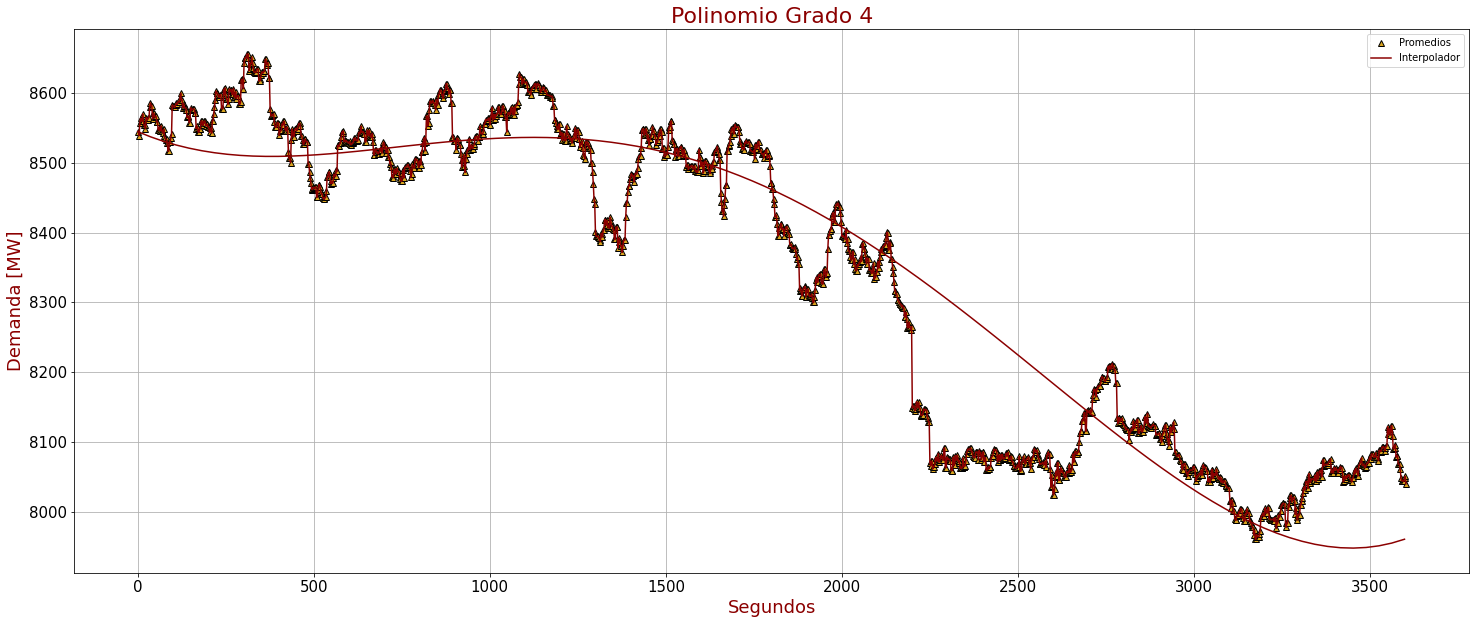

In [159]:
plt.figure(figsize=(25,10))
plt.plot(hora.seg, hora.dem, color= 'white' ,
         marker = '^' , markersize = 6.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(xeval, yeval, color = 'darkred')
plt.plot(hora.seg, hora.dem, color = 'darkred')
plt.title("Polinomio Grado 4" , fontsize = 22 , color = 'darkred')
plt.xlabel("Segundos" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Promedios","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Verano_h_4.png')
plt.show()

+ **Polinomio grado cinco**

In [160]:
n_m = []
x = []
k = 0
n_puntos = 5 # Solo submúltiplos de 1,800
for i in range(n_puntos):
    n_m.append(k)
    x.append(k*2)
    k = k+(1800/n_puntos)

y = []
for i in range(len(x)):
    y.append(hora.dem[n_m[i]])

x.append(3598)
y.append(hora.orden[1799])

coef_aj = np.polyfit(x, y, len(x)-1)

neval = 100
xeval = np.linspace(min(x), max(x), neval)
yeval = np.polyval(coef_aj,xeval)

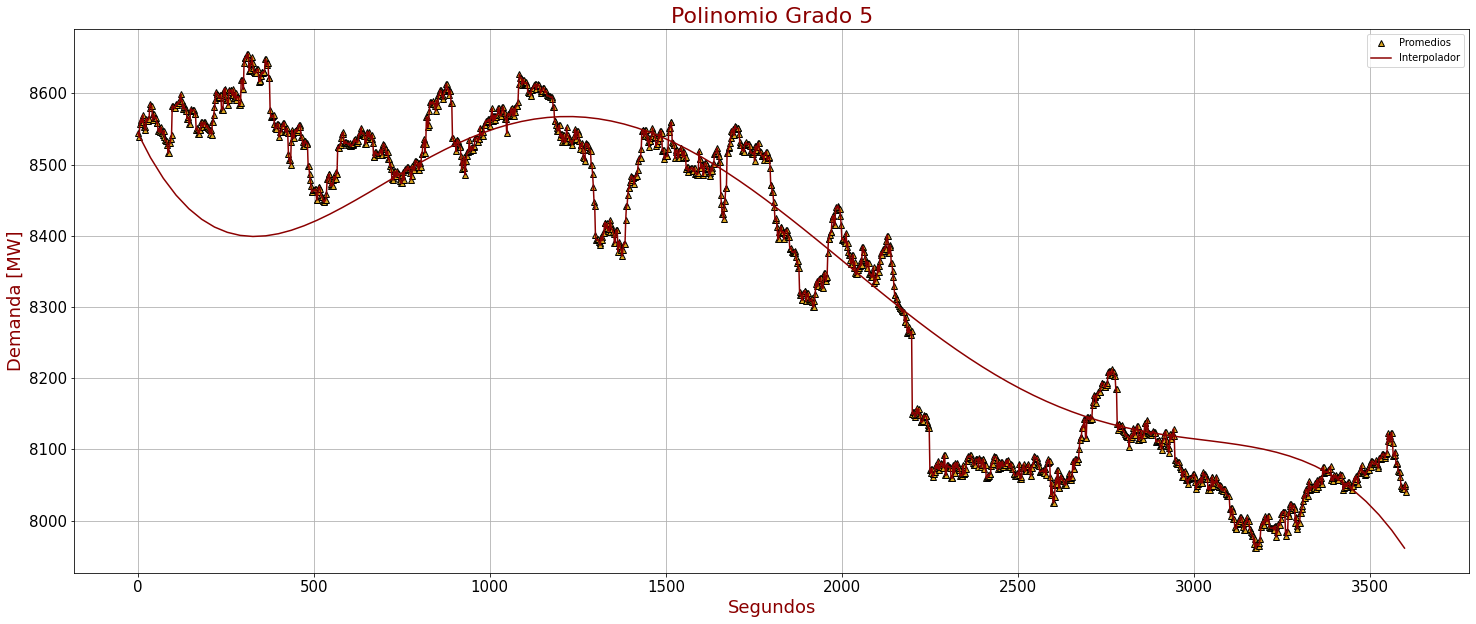

In [161]:
plt.figure(figsize=(25,10))
plt.plot(hora.seg, hora.dem, color= 'white' ,
         marker = '^' , markersize = 6.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(xeval, yeval, color = 'darkred')
plt.plot(hora.seg, hora.dem, color = 'darkred')
plt.title("Polinomio Grado 5" , fontsize = 22 , color = 'darkred')
plt.xlabel("Segundos" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Promedios","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Verano_h_5.png')
plt.show()

+ **Polinomio grado seis**

In [162]:
n_m = []
x = []
k = 0
n_puntos = 6 # Solo submúltiplos de 1,800
for i in range(n_puntos):
    n_m.append(k)
    x.append(k*2)
    k = k+(1800/n_puntos)

y = []
for i in range(len(x)):
    y.append(hora.dem[n_m[i]])

x.append(3598)
y.append(hora.orden[1799])

coef_aj = np.polyfit(x, y, len(x)-1)

neval = 100
xeval = np.linspace(min(x), max(x), neval)
yeval = np.polyval(coef_aj,xeval)

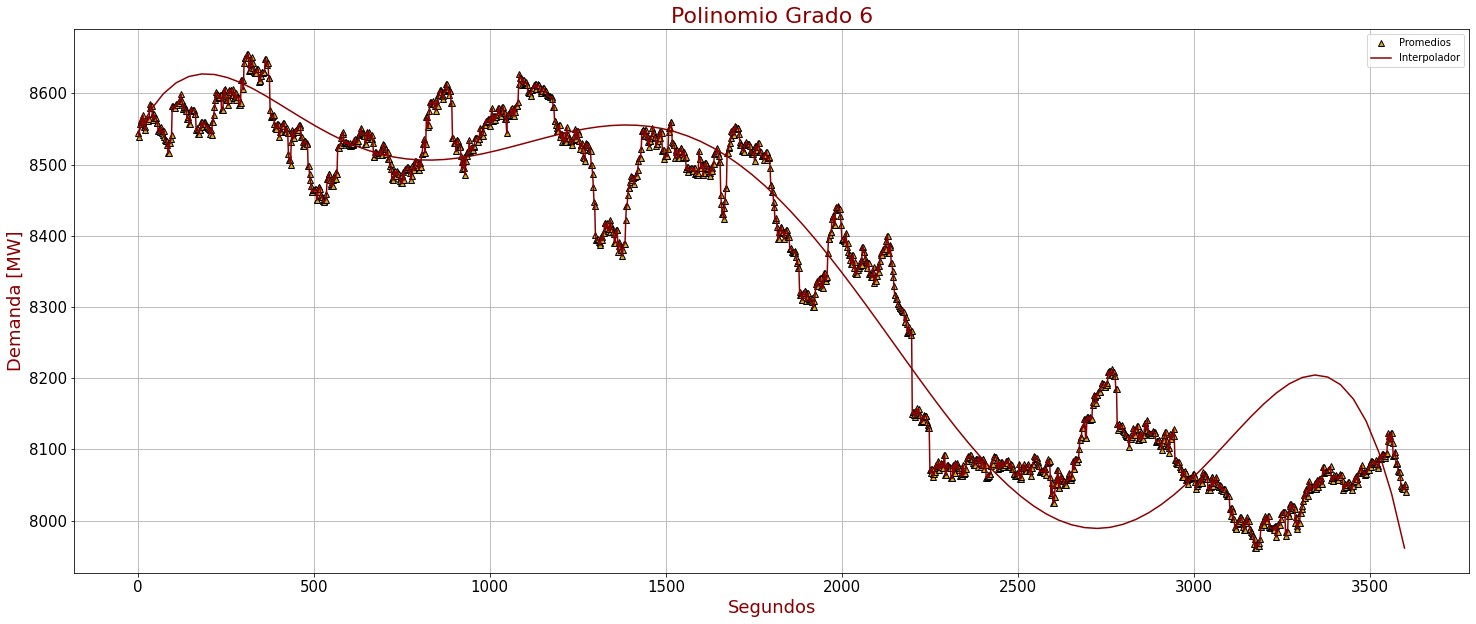

In [163]:
plt.figure(figsize=(25,10))
plt.plot(hora.seg, hora.dem, color= 'white' ,
         marker = '^' , markersize = 6.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(xeval, yeval, color = 'darkred')
plt.plot(hora.seg, hora.dem, color = 'darkred')
plt.title("Polinomio Grado 6" , fontsize = 22 , color = 'darkred')
plt.xlabel("Segundos" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Promedios","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Verano_h_6.png')
plt.show()

+ **Polinomio Grado Siete**

In [170]:
1806/7

258.0

In [173]:
n_m = []
x = []
k = 0
n_puntos = 7 # Solo submúltiplos de 1,800
for i in range(n_puntos):
    n_m.append(k)
    x.append(k*2)
    k = k+(1806/n_puntos)

y = []
for i in range(len(x)):
    y.append(hora.dem[n_m[i]])

x.append(3598)
y.append(hora.orden[1799])

coef_aj = np.polyfit(x, y, len(x)-1)

neval = 100
xeval = np.linspace(min(x), max(x), neval)
yeval = np.polyval(coef_aj,xeval)

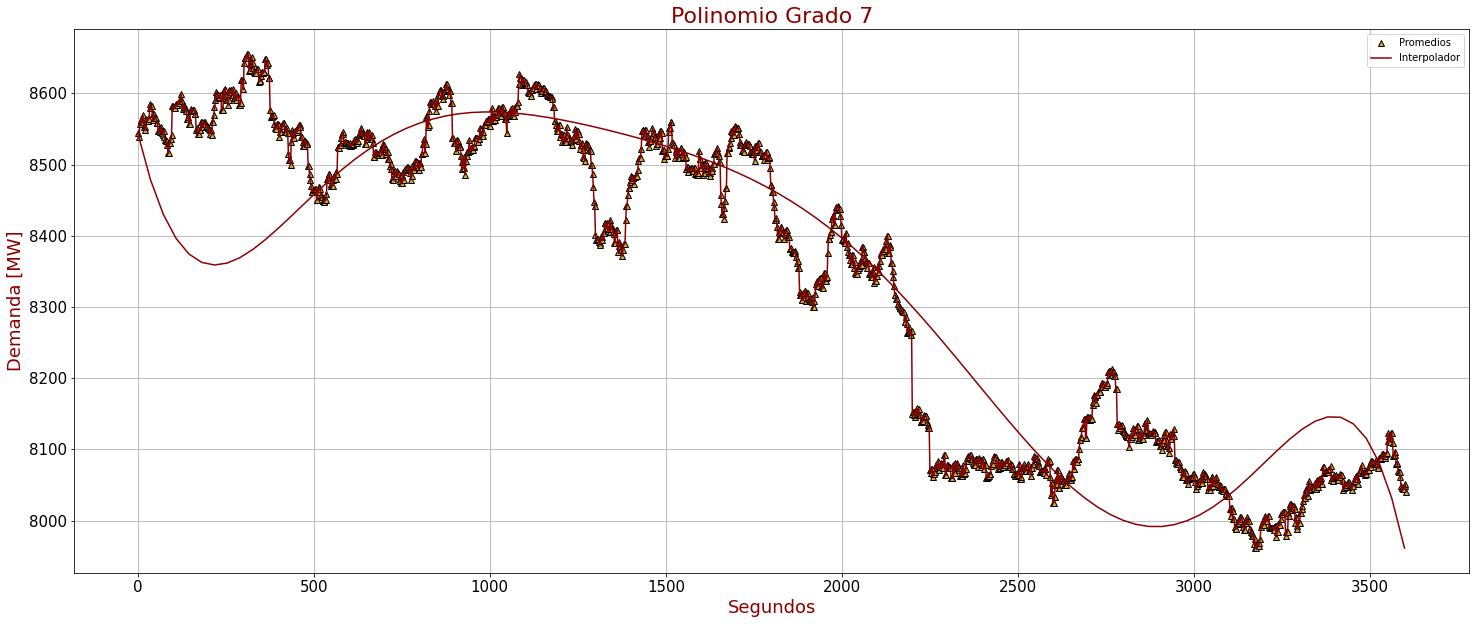

In [174]:
plt.figure(figsize=(25,10))
plt.plot(hora.seg, hora.dem, color= 'white' ,
         marker = '^' , markersize = 6.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(xeval, yeval, color = 'darkred')
plt.plot(hora.seg, hora.dem, color = 'darkred')
plt.title("Polinomio Grado 7" , fontsize = 22 , color = 'darkred')
plt.xlabel("Segundos" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Promedios","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Verano_h_7.png')
plt.show()

In [176]:
n_m = []
x = []
k = 0
n_puntos = 8 # Solo submúltiplos de 1,800
for i in range(n_puntos):
    n_m.append(k)
    x.append(k*2)
    k = k+(1800/n_puntos)

y = []
for i in range(len(x)):
    y.append(hora.dem[n_m[i]])

x.append(3598)
y.append(hora.orden[1799])

coef_aj = np.polyfit(x, y, len(x)-1)

neval = 100
xeval = np.linspace(min(x), max(x), neval)
yeval = np.polyval(coef_aj,xeval)

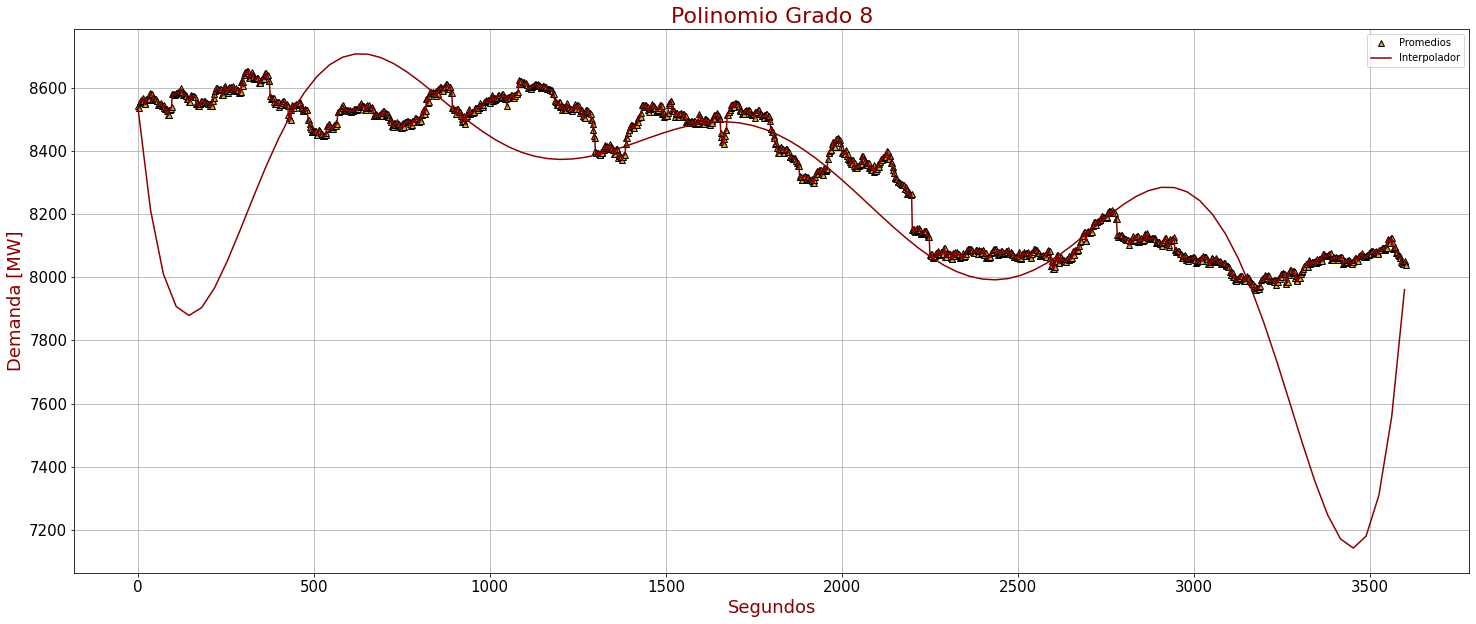

In [177]:
plt.figure(figsize=(25,10))
plt.plot(hora.seg, hora.dem, color= 'white' ,
         marker = '^' , markersize = 6.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.plot(xeval, yeval, color = 'darkred')
plt.plot(hora.seg, hora.dem, color = 'darkred')
plt.title("Polinomio Grado 8" , fontsize = 22 , color = 'darkred')
plt.xlabel("Segundos" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.legend(["Promedios","Interpolador"] , loc=0)
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
plt.grid(True)
plt.savefig('Verano_h_8.png')
plt.show()

+ **Splines**

In [132]:
data_segundos = pd.read_csv("Verano_16.csv")
seg = np.linspace(0, 86400, 43201)
a_seg = np.array(seg)
data_seg = pd.DataFrame(seg, columns = ["Segundo"]) 
DEM = pd.DataFrame(data_segundos.Demanda, columns = ["Demanda"])
data_seg["Demanda"] = DEM["Demanda"]

In [133]:
#Dejando sólo los datos de una hora:
del_rows_1hr = range(1801,43201)
data_seg_1hr = data_seg.drop(data_seg.index[del_rows_1hr], axis = 0)

#### Calculando área bajo la curva usando trapz:

In [134]:
dem_trapz_1hr = np.trapz(data_seg_1hr.Demanda, data_seg_1hr.Segundo)
print(f"{dem_trapz_1hr:,.2f}")

30,009,637.63


#### Calculando área bajo la curva usando promedio de altura mínima y máxima:

In [135]:
dem_1hr = data_seg_1hr["Demanda"]
dem_max_1hr = dem_1hr.max()
dem_min_1hr = dem_1hr.min()
print("Max: ", f"{dem_max_1hr:,.2f}")
print("Min: ", f"{dem_min_1hr:,.2f}")

Max:  8,655.43
Min:  7,961.38


In [136]:
dem_prom_1hr = ((dem_max_1hr+dem_min_1hr)/2)*3600
print(f"{dem_prom_1hr:,.2f}")

29,910,260.74


#### Diferencia en porcentajes de datos de 1 hora, usando trapz y considerando promedio de mínimo y máximo:

In [137]:
dif_1hr = dem_trapz_1hr - dem_prom_1hr
dif_pc_1hr = dif_1hr*100/dem_trapz_1hr
print(f"{dif_pc_1hr:,.2f}", "%")

0.33 %


### **Promedios Totales de la Demanda Anual**

En este caso, se sacarón los promedio por mes de los tres años y luego promediarlos de acurdo al número de veces que ese mes apareciera en el *dataframe*

In [42]:
Meses = ['Enero' , 'Febrero' , 'Marzo' , 'Abril' , 'Mayo' , 'Junio' , 'Julio' , 'Agosto' , 'Septiembre' , 'Octubre' , 'Nobiembre' , 'Diciembre']

x_hist = list(range(1,13))
prom_hist = [1,2,3,4,5,6,7,8,9,10,11,12]
prom_hist[8] = (data_mes.iat[0,0] + data_mes.iat[12,0] + data_mes.iat[24,0])/3
prom_hist[9] = (data_mes.iat[1,0] + data_mes.iat[13,0] + data_mes.iat[25,0])/3
prom_hist[10] = (data_mes.iat[2,0] + data_mes.iat[14,0] + data_mes.iat[26,0])/3
prom_hist[11] = (data_mes.iat[3,0] + data_mes.iat[15,0] + data_mes.iat[27,0])/3
prom_hist[0] = (data_mes.iat[4,0] + data_mes.iat[16,0] + data_mes.iat[28,0])/3
prom_hist[1] = (data_mes.iat[5,0] + data_mes.iat[17,0] + data_mes.iat[29,0] + data_mes.iat[36,0])/4
prom_hist[2] = (data_mes.iat[6,0] + data_mes.iat[18,0] + data_mes.iat[30,0] + data_mes.iat[37,0])/4
prom_hist[3] = (data_mes.iat[7,0] + data_mes.iat[19,0] + data_mes.iat[31,0])/3
prom_hist[4] = (data_mes.iat[8,0] + data_mes.iat[20,0] + data_mes.iat[32,0])/3
prom_hist[5] = (data_mes.iat[9,0] + data_mes.iat[21,0] + data_mes.iat[33,0])/3
prom_hist[6] = (data_mes.iat[10,0] + data_mes.iat[22,0] + data_mes.iat[34,0])/3
prom_hist[7] = (data_mes.iat[11,0] + data_mes.iat[23,0] + data_mes.iat[35,0])/3

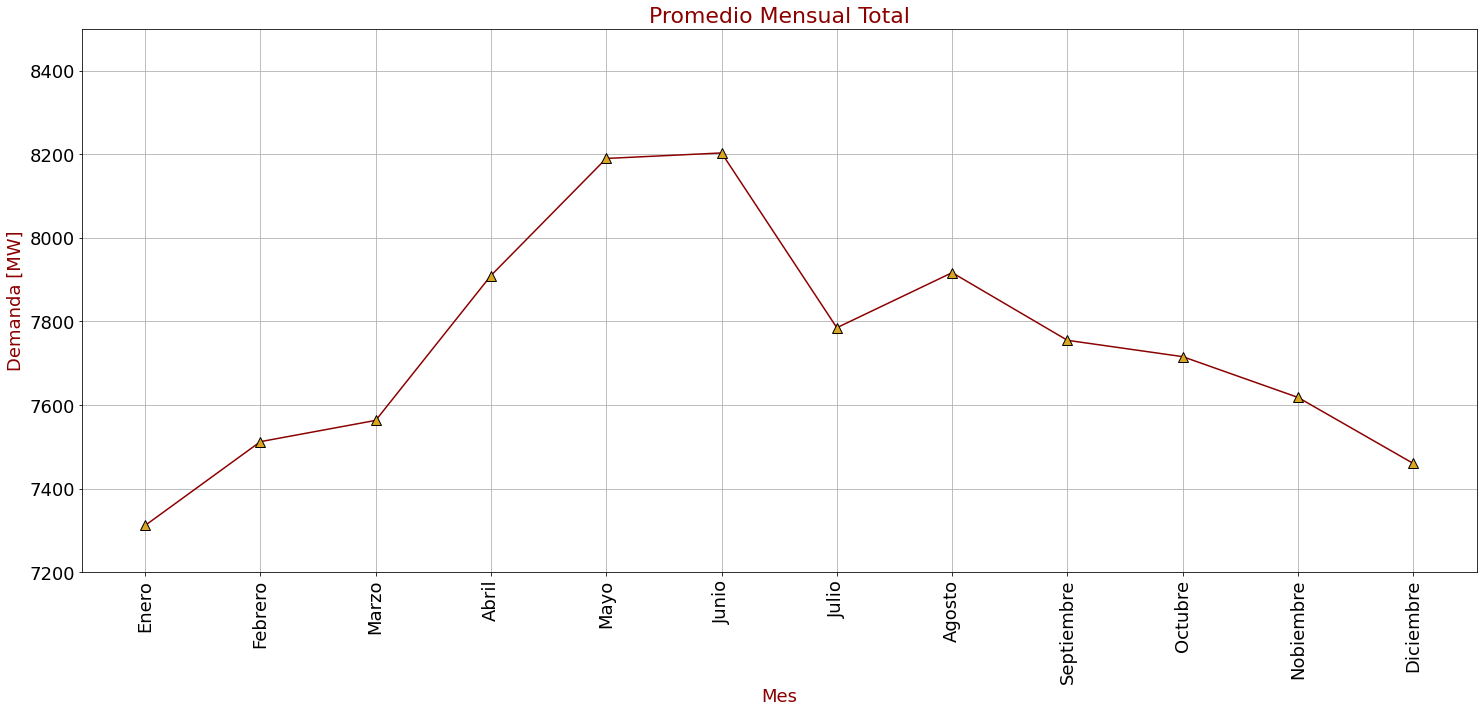

In [49]:
plt.figure(figsize=(25,10))
plt.plot(x_hist , prom_hist , color= 'darkred' ,
         marker = '^' , markersize = 10.0 , markeredgecolor='black' , markerfacecolor = 'goldenrod')
plt.title("Promedio Mensual Total" , fontsize = 22 , color = 'darkred')
plt.xlabel("Mes" , fontsize = 18 , color = 'darkred')
plt.ylabel("Demanda [MW]" , fontsize = 18 , color = 'darkred')
plt.yticks(fontsize = 18)
plt.xticks(list(range(1,13)), Meses , rotation = 'vertical' , fontsize = 18)
plt.ylim([0,9000]) 
plt.grid(True)
plt.ylim([7200,8500]) 
plt.savefig('Inter_mes_tot_2.png')
plt.show()

Lo que nos dice el gráfico es que hay una mayor demanda de energía en Verano siendo el de mayor consumo en Junio, mientras que el mínimo se reporta para Enero. Este se puede deber a que en Verano, la gente usa más el aire condicionado, ventiladores y a fines por el calor.